# Tucker Decomposition
This decomposition aims to dins a core matrix and factor matrices that approximate to the given tensor:

$X \approx G \times U_s \times U_t \times U_p$, 

where:
- $G$: Core matrix.
- $U_s$: Factor matrix corresponding to the **TCR sequences** dimension.
- $U_t$: Factor matrix corresponding to the **time** dimension. 
- $U_p$: Factor matrix corresponding to the **patients** dimension. 


# Imports

## Import General Libraries

In [23]:
import pandas as pd
import numpy as np
import tensorly as tl
import matplotlib.pyplot as plt
import seaborn as sns
from tensorly.decomposition import tucker, non_negative_tucker

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

# Ensure all rows and columns are displayed
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Adjust width to ºprevent line breaks
pd.set_option('display.max_colwidth', None)  # Prevent truncation of cell content

## Import tensors
We don't need to convert to tensorly tensor as the numpy tensor already works (and give same results).

In [9]:
# Define tensor labels
tensor_names = ["tensor_70", "tensor_100", "tensor_200", "tensor_300"]

# Load tensors
tensor_70 = np.load("tensors_center/tensor_70.npy")
tensor_100 = np.load("tensors_center/tensor_100.npy")
tensor_200 = np.load("tensors_center/tensor_200.npy")
tensor_300 = np.load("tensors_center/tensor_300.npy")

tensors = [tensor_70, tensor_100, tensor_200, tensor_300]


# Plotting functions 
We can visualise 4 different plots, one for each core and factor matrices from the decomposition. 
- `factors[0]` $ = U_s$: Factor matrix corresponding to the **TCR sequences** dimension. Can be visualised using heatmaps and barplots.
- `factors[1]` $ = U_t$: Factor matrix corresponding to the **time** dimension. Can be visualised using time series.
- `factors[2]` $ = U_p$: Factor matrix corresponding to the **patients** dimension. Can be visualised using heatmaps and barplots.
- `core` $ = G$: Core matrix. Can be visualised by sorting the most relevant indices.

In [10]:
plt.rcParams.update({
    "font.size": 15,       # Default text size
    "axes.titlesize": 17,  # Title size
    "axes.labelsize": 15,  # X and Y label size
    "xtick.labelsize": 12, # X tick labels
    "ytick.labelsize": 13, # Y tick labels
    "legend.fontsize": 13  # Legend text size
})

## Time series

In [11]:
def plot_factor_matrix_timeseries(factor_matrix, y_label=None, x_label='Time (Days)', title="Factor Matrix Timeseries", step=10, max_ticks=10,folder_name=None):
    """
    Plots the factor matrix as multiple time series, one per rank.

    Parameters:
    - factor_matrix (np.array): The factor matrix (time x ranks).
    - y_label (str): Label for y-axis (optional).
    - x_label (str): Label for x-axis.
    - title (str): Title of the plot.
    - step (int): Step size between time steps.
    - max_ticks (int): Maximum number of x-axis ticks to show (to avoid overlap).
    """
    ranks = factor_matrix.shape[1]
    fig, ax = plt.subplots(ranks, 1, figsize=(10, 2 * ranks), sharex=True)

    time_steps = np.arange(0, factor_matrix.shape[0] * step, step)

    if ranks == 1:
        ax = [ax]  # Make iterable

    for i in range(ranks):
        ax[i].plot(time_steps, factor_matrix[:, i])
        ax[i].set_ylabel(f'Comp. {i+1}', fontsize=14)
        ax[i].tick_params(axis='y', labelsize=12)
        ax[i].set_xlim(time_steps[0], time_steps[-1])

    # Set x-axis ticks and labels on the last plot
    ax[-1].set_xlabel(x_label, fontsize=14)
    ax[-1].tick_params(axis='x', labelsize=12)

    # Set ticks every 10 days
    ax[-1].set_xticks(time_steps)

    # Show labels only on every Nth tick to avoid overlap
    label_every = max(1, len(time_steps) // max_ticks)
    xtick_labels = [str(t) if i % label_every == 0 else "" for i, t in enumerate(time_steps)]
    ax[-1].set_xticklabels(xtick_labels)

    # Title and spacing
    # plt.suptitle(title, fontsize=16)
    # plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save with safe filename
    save_title = title.replace(" ", "_").replace("|", "").replace("(", "").replace(")", "").replace(",", "")
    plt.savefig(f"{folder_name}{save_title}.png", format="png", bbox_inches="tight")
    plt.savefig(f"{folder_name}{save_title}.pdf", format="pdf", bbox_inches="tight")
    plt.show()


## Most relevant

In [12]:
# Core matrix - find most relevant
from itertools import product
def most_relevant(core_tensor):
    # Convert core tensor to a DataFrame with meaningful statistics
    core_tensor_df = pd.DataFrame({
        "Index": list(product(*[np.arange(1, si+1) for si in core_tensor.shape])),  # Tuple index
        "Weight": core_tensor.flatten(),  # Raw core tensor values
        "Fraction": core_tensor.flatten()**2,  # Energy contribution
        "Sign": np.sign(core_tensor.flatten())  # Positive or negative value
    })

    # Sort by Fraction (importance) in descending order
    core_tensor_df = core_tensor_df.sort_values("Fraction", ascending=False)
    core_tensor_df["Index"] = core_tensor_df["Index"].astype(str)
    core_tensor_df["Fraction"] = core_tensor_df["Fraction"] / np.sum(core_tensor_df["Fraction"])

    return core_tensor_df 

## Barplot

In [37]:
def barplot_core(core_tensor, title,folder_name):
    fig = plt.figure(figsize=(10,2))
    # sns.barplot(core_tensor.iloc[:8, :], x="Index", y="Fraction", legend=False)
    sns.barplot(core_tensor.iloc[:10, :], x="Index", y="Fraction", hue="Sign", palette=["#2369BD", "#A9393C"], legend=True)
    # plt.title(title)
    save_title = title.replace(" ", "_").replace("|", "").replace("(", "").replace(")", "").replace(",", "").replace("[", "").replace("]", "")
    plt.savefig(f"{folder_name}{save_title}.png", format="png", bbox_inches="tight")
    plt.savefig(f"{folder_name}{save_title}.pdf", format="pdf", bbox_inches="tight")
    plt.show() 
   

## Heatmap with barplots

In [17]:
def plot_rotated_heatmap_with_barplots(factor_matrix, column_labels=None, row_labels=None, y_label=None, x_label=None, title="Rotated Factor Matrix Heatmap", sequences_only=False,folder_name=None):
    """
    Plots a heatmap rotated 90 degrees to the right with small barplots for each rank on the right.
    Bars are colored based on sign: red for positive, blue for negative.
    Heatmap is centered at 0.
    """
    factor_matrix = np.array(factor_matrix).T  # Rotate 90 degrees to the right
    ranks, sequences = factor_matrix.shape  # Update shape post-transposition

    # Determine max absolute value to center colormap
    max_abs_val = np.abs(factor_matrix).max()

    fig = plt.figure(figsize=(10, 2*ranks))
    # plt.suptitle(title)

    # Define subplot grid
    ax_heatmap = plt.subplot2grid(shape=(ranks, 4), loc=(0, 0), rowspan=ranks, colspan=3)
    ax_barplots = [plt.subplot2grid(shape=(ranks, 4), loc=(i, 3), rowspan=1, colspan=1) for i in range(ranks)]

    # Heatmap centered at 0
    sns.heatmap(
        factor_matrix,
        cmap="coolwarm",
        center=0,
        vmin=-max_abs_val,
        vmax= max_abs_val,
        cbar=True,
        linewidths=0.5,
        ax=ax_heatmap
    )
    ax_heatmap.set_xlabel(x_label)
    ax_heatmap.set_ylabel(y_label)

    if column_labels:
        if sequences_only:
            ax_heatmap.set_xticks(np.arange(0, len(column_labels), 5) + 0.5)
            ax_heatmap.set_xticklabels([column_labels[i] for i in range(0, len(column_labels), 5)], rotation=0)
        else:
            ax_heatmap.set_xticks(np.arange(len(column_labels)) + 0.5)
            ax_heatmap.set_xticklabels(column_labels, rotation=45)
    else:
        ax_heatmap.set_xticks([])

    if row_labels:
        ax_heatmap.set_yticks(np.arange(len(row_labels)) + 0.5)
        ax_heatmap.set_yticklabels(row_labels, rotation=90)
    else:
        ax_heatmap.set_yticks([])

    # min_height = 0.5  # Minimum visible height for bar plots

    # Barplots with color based on sign and min height
    for i, ax_bar in enumerate(ax_barplots):
        values = factor_matrix[i, :]
        indices = np.arange(sequences)

        pos_mask = values >= 0
        neg_mask = values < 0

        ax_bar.bar(indices[pos_mask], values[pos_mask], color="red")
        ax_bar.bar(indices[neg_mask], values[neg_mask], color="blue")

        max_val = max(abs(values.max()), abs(values.min()))
        # ax_bar.set_ylim(-max(min_height, max_val), max(min_height, max_val))
        # ax_bar.set_xlim([-0.5, sequences - 0.5])
        if sequences_only:
            ax_bar.set_xlim([-3, sequences + 3])
        else:
            ax_bar.set_xlim([-1, sequences + 1])

        ax_bar.set_xlabel(x_label)
        ax_bar.set_ylabel("Value")

    plt.tight_layout()
    save_title = title.replace(" ", "_").replace("|", "").replace("(", "").replace(")", "").replace(",", "").replace("[", "").replace("]", "")
    plt.savefig(f"{folder_name}{save_title}.png", format="png", bbox_inches="tight")
    plt.savefig(f"{folder_name}{save_title}.pdf", format="pdf", bbox_inches="tight")
    plt.show()


## Visualization pipeline

In [28]:
def decomp_visualizations(td_dic, t_name, pat_list, method):
    core = td_dic['core_tensor']
    factors = td_dic['factor_matrices']
    Us, Ut, Up = factors
    folder_name=f"C:/AQUI ESTA LO WENO/UNI/Chalmers/TFM/Data and Code/Results/Tucker Decomps/"

    # Us heatmap
    column_labels = [f"Comp. {i+1}" for i in range(Us.shape[1])]
    row_labels = [f"{i}" for i in range(Us.shape[0])]
    y_label = 'Sequences'
    plot_rotated_heatmap_with_barplots(
        Us,
        column_labels=row_labels,
        row_labels=column_labels,
        y_label=None,
        x_label=y_label,
        title=f"{method} | Us for {t_name}",
        sequences_only=True,
        folder_name=folder_name
    )

    # Ut time series
    plot_factor_matrix_timeseries(Ut, title=f"{method} | Ut for {t_name}",folder_name=folder_name)

    # Up heatmap
    y_label = 'Patients'
    column_labels = [f"Comp. {i+1}" for i in range(Up.shape[1])]
    row_labels = [f"{pat_list[i]}" for i in range(Up.shape[0])]
    plot_rotated_heatmap_with_barplots(
        Up,
        column_labels=row_labels,
        row_labels=column_labels,
        y_label=None,
        x_label=y_label,
        title=f"{method} | Up for {t_name}",
        sequences_only=False,
        folder_name=folder_name
    )

    # Core tensor most relevant indices
    core_tensor_df = most_relevant(core)
    barplot_core(core_tensor_df, title=f"{method} | Core indices for {t_name}",folder_name=folder_name)


# Decompositions

In [29]:
pat_list_70 = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK041', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK059']

pat_list_100 =['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK027', 'SARK029', 'SARK032', 'SARK037', 'SARK059']

pat_list_200 = ['SARK012', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
            'SARK027', 'SARK029', 'SARK032', 'SARK059']

pat_list_300 = ['SARK012', 'SARK034', 'SARK021', 'SARK025', 
            'SARK029', 'SARK059']

In [33]:
def Tucker_decomp(tensor, rank,tensor_str, pat_list):
    core, factors = tucker(tensor, rank)
    td_dic= {'core_tensor': core, 'factor_matrices': factors}
    decomp_visualizations(td_dic, tensor_str, pat_list, method=f'010_{rank}')

## Tensor 70 (th=0.1)

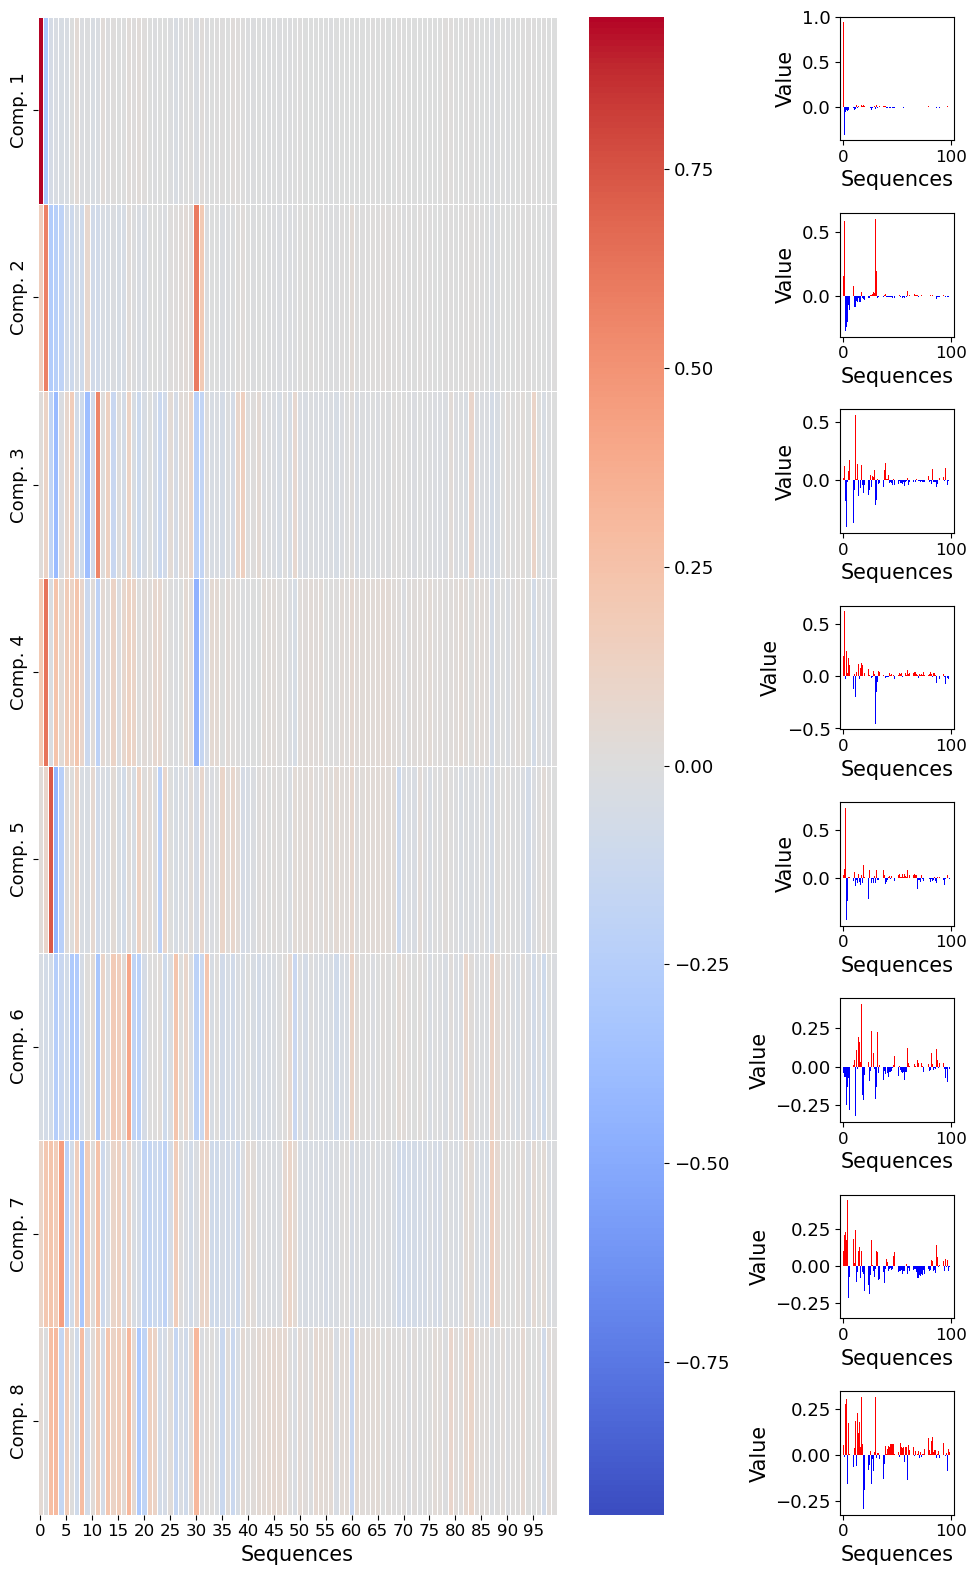

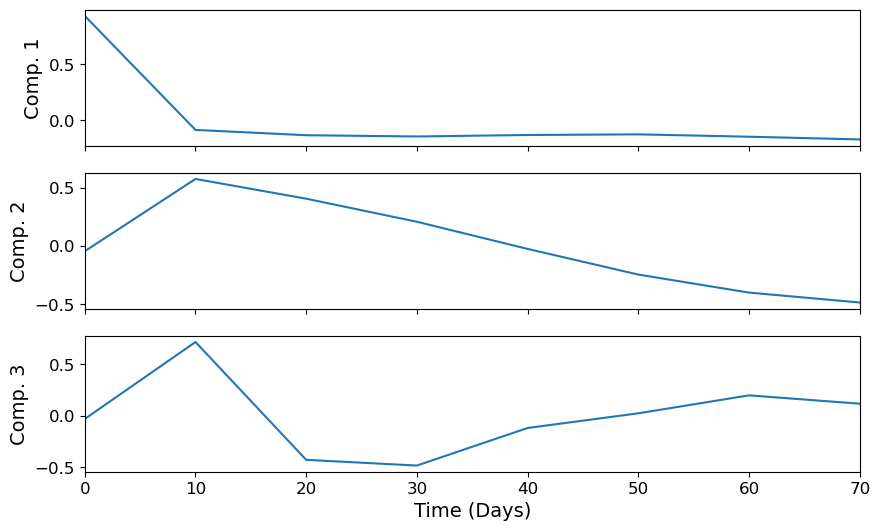

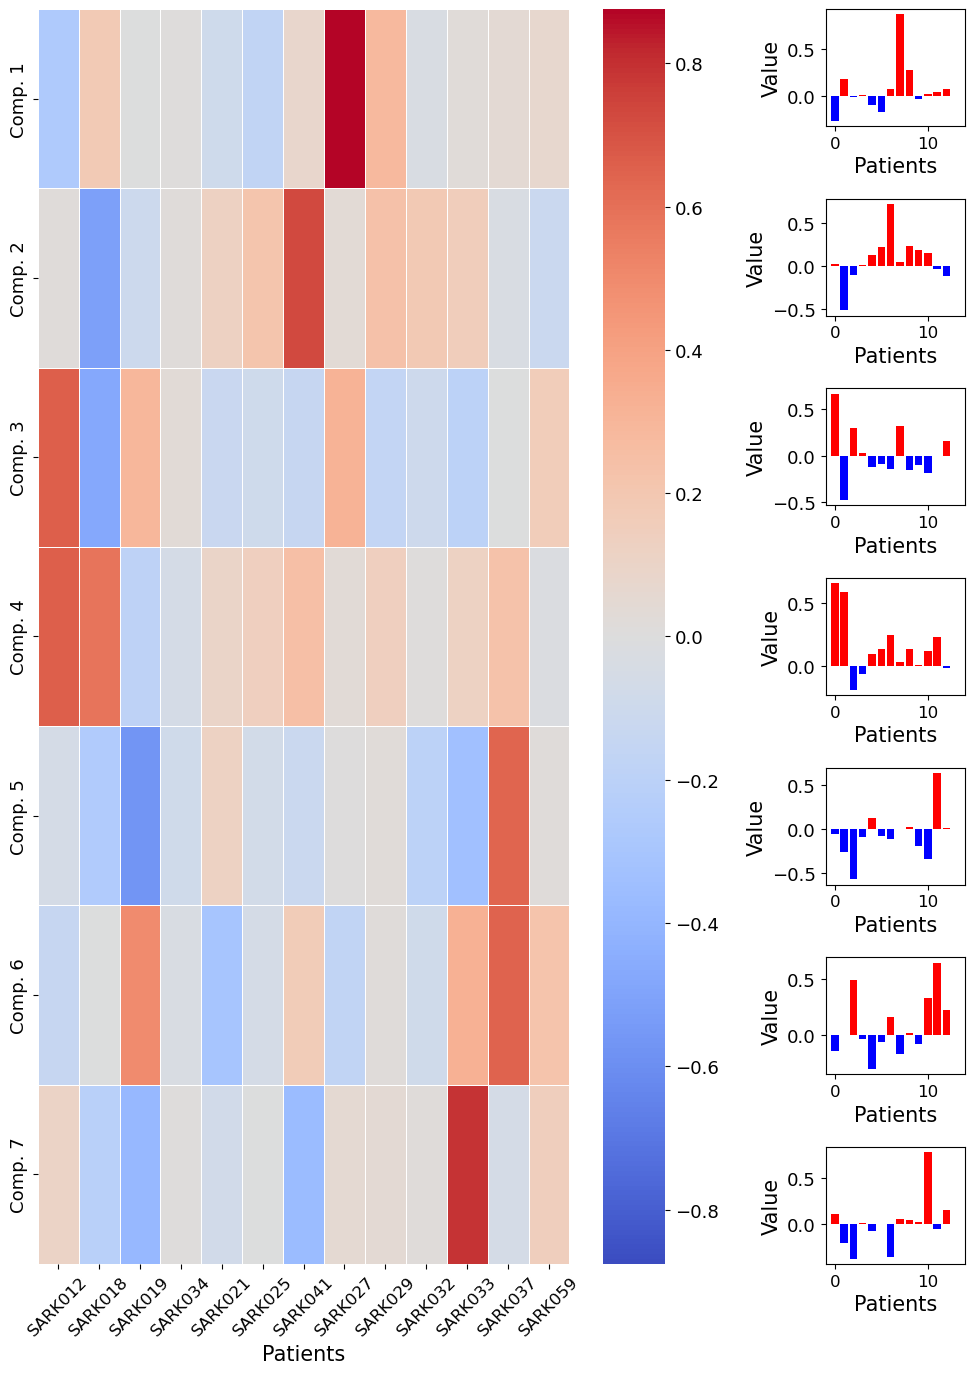

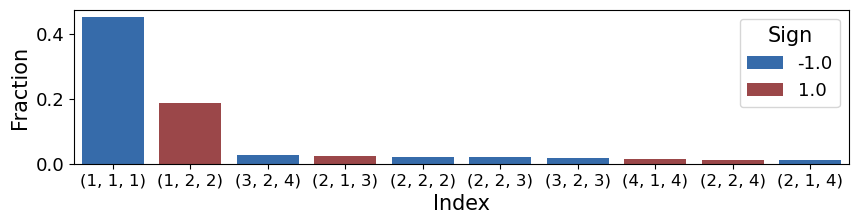

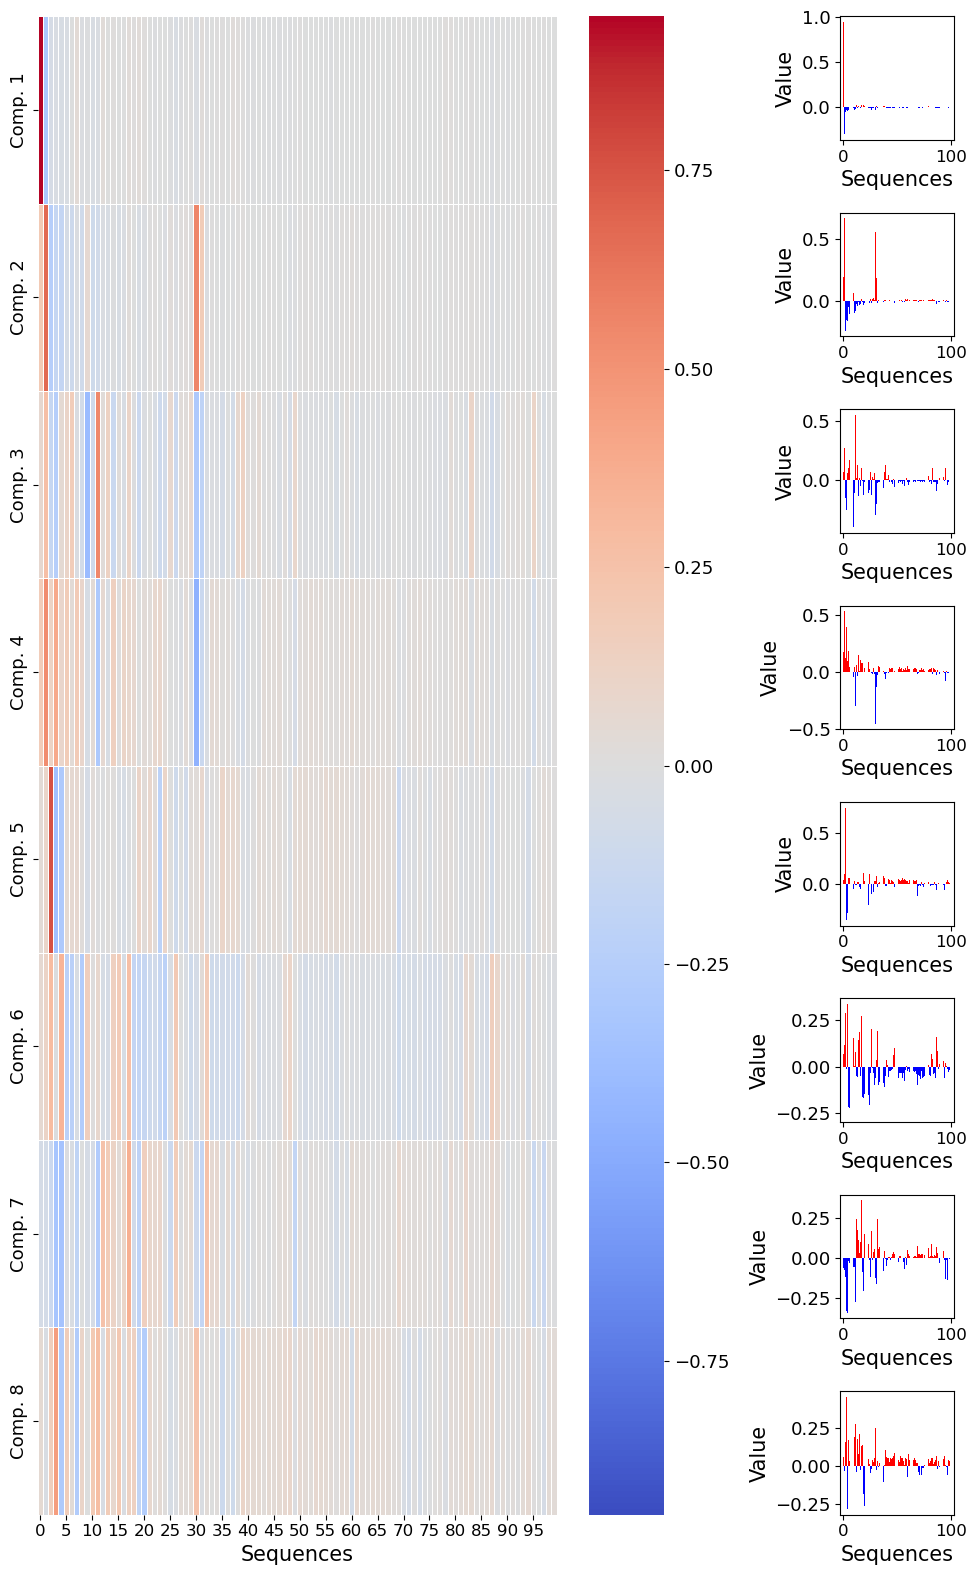

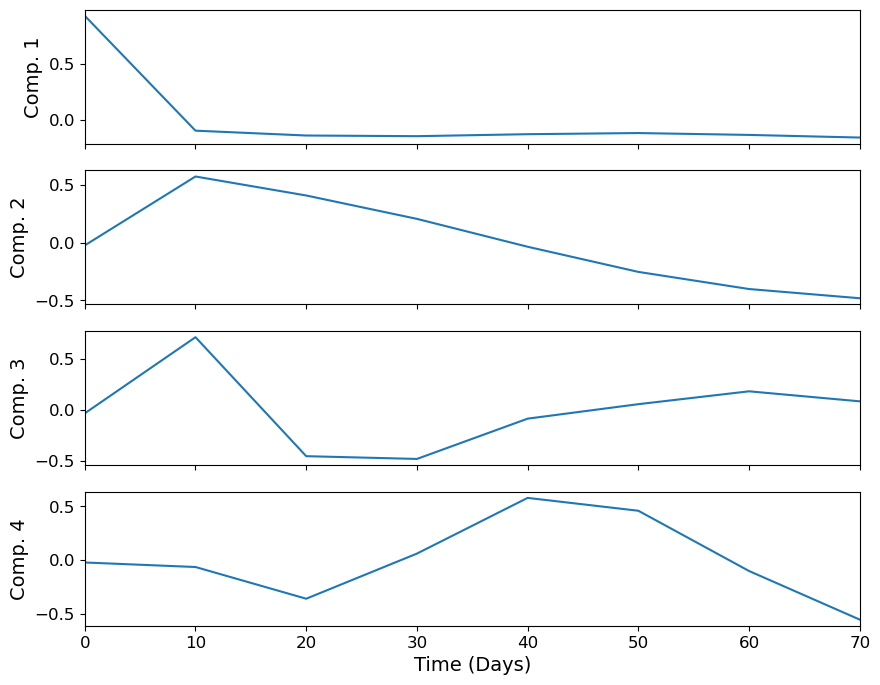

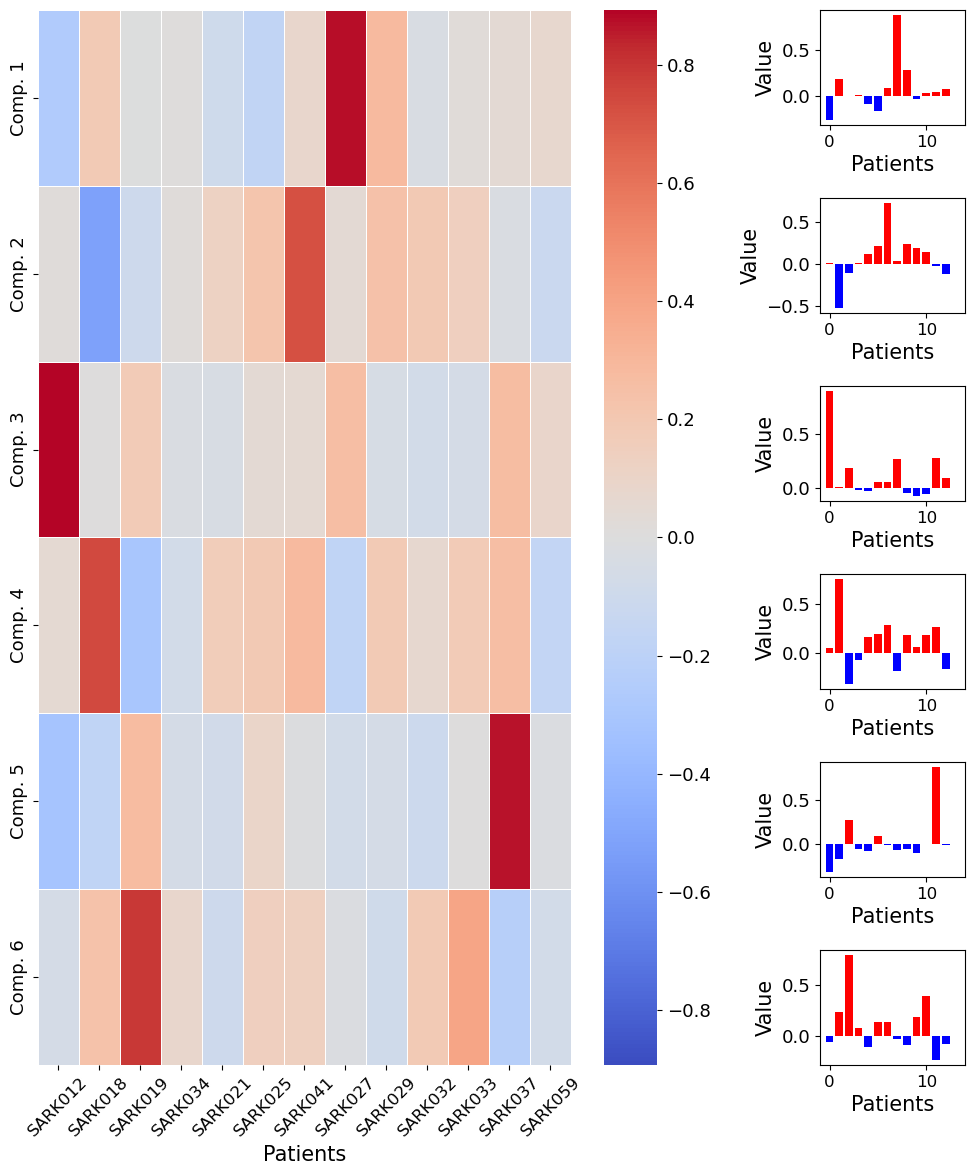

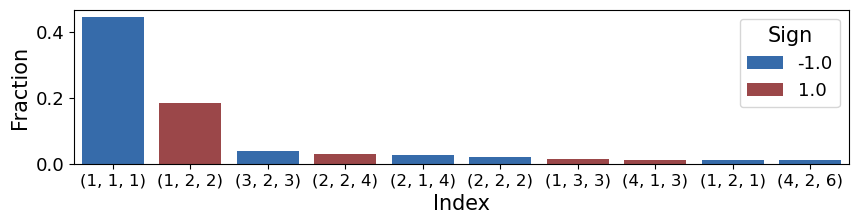

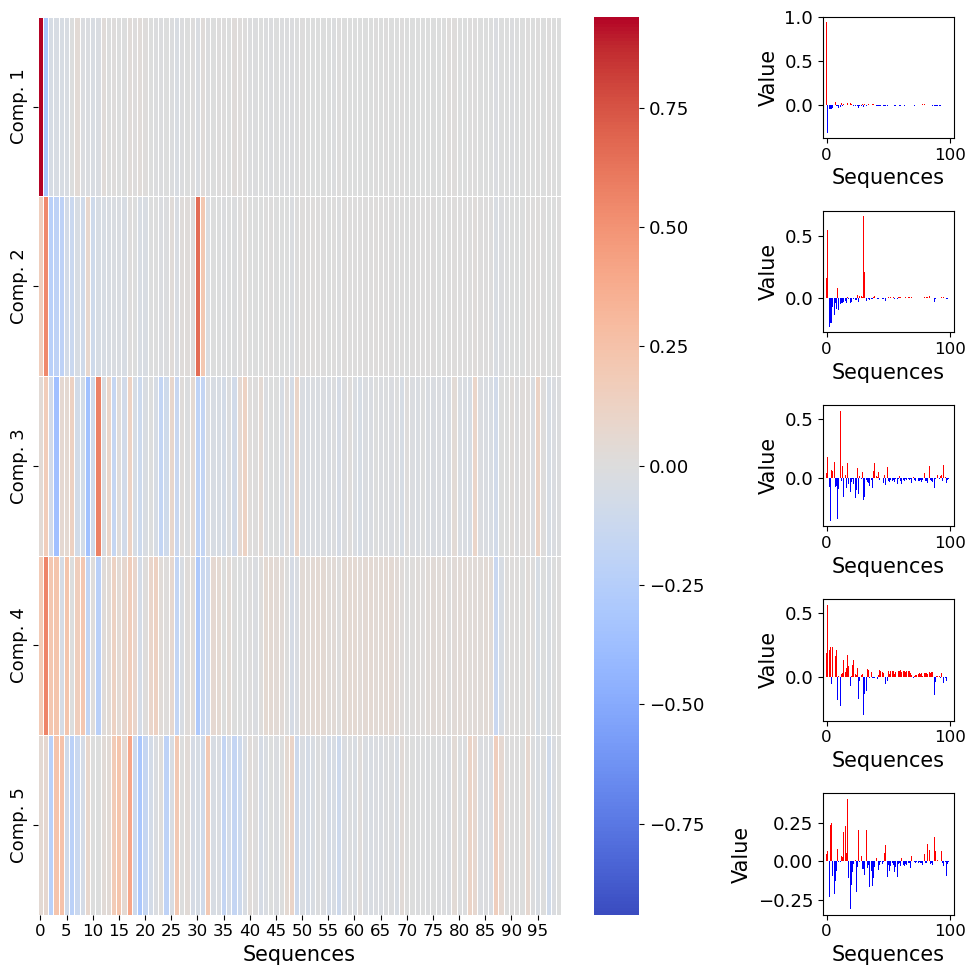

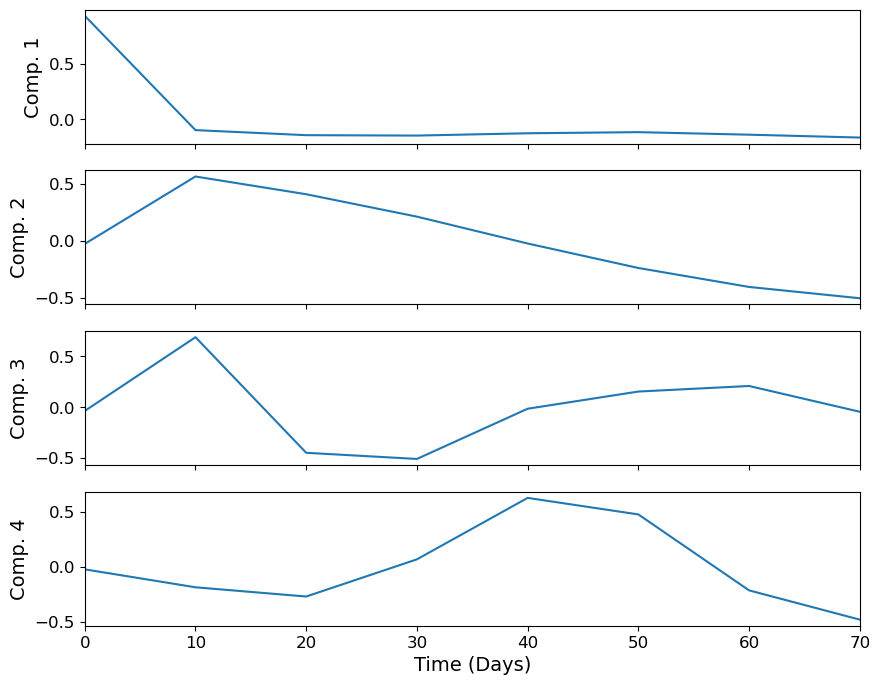

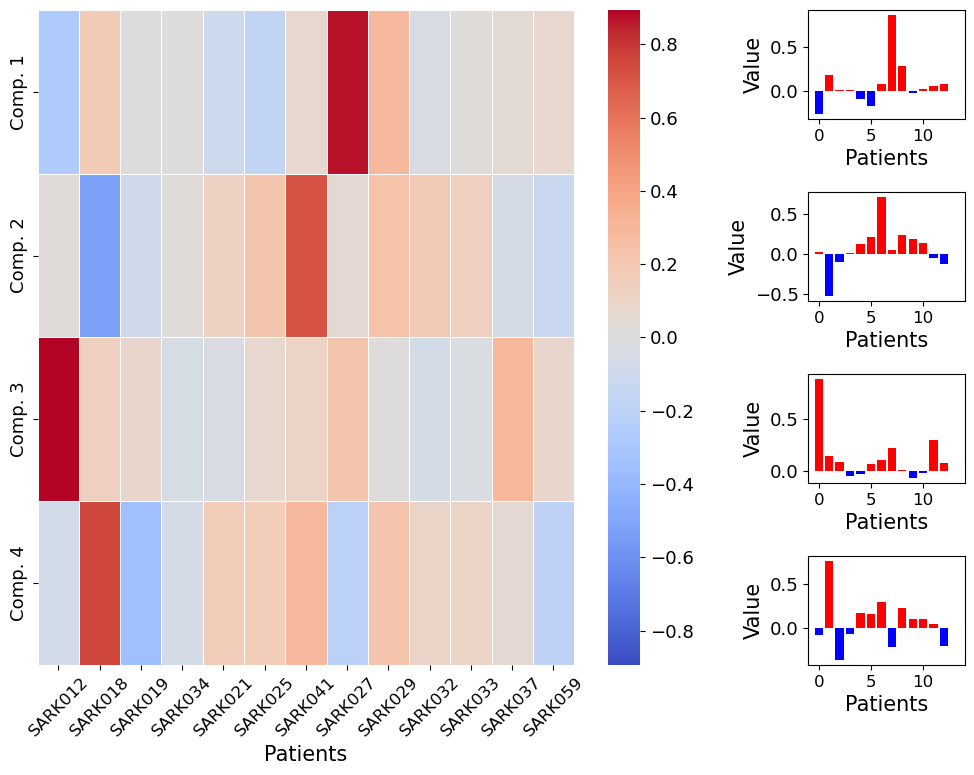

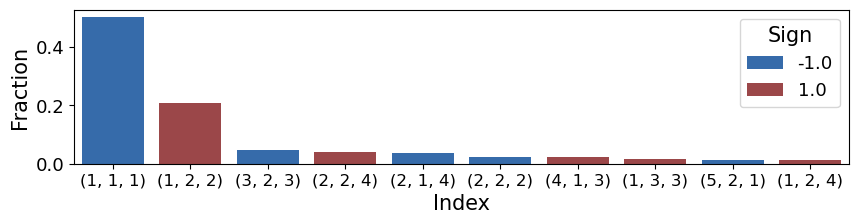

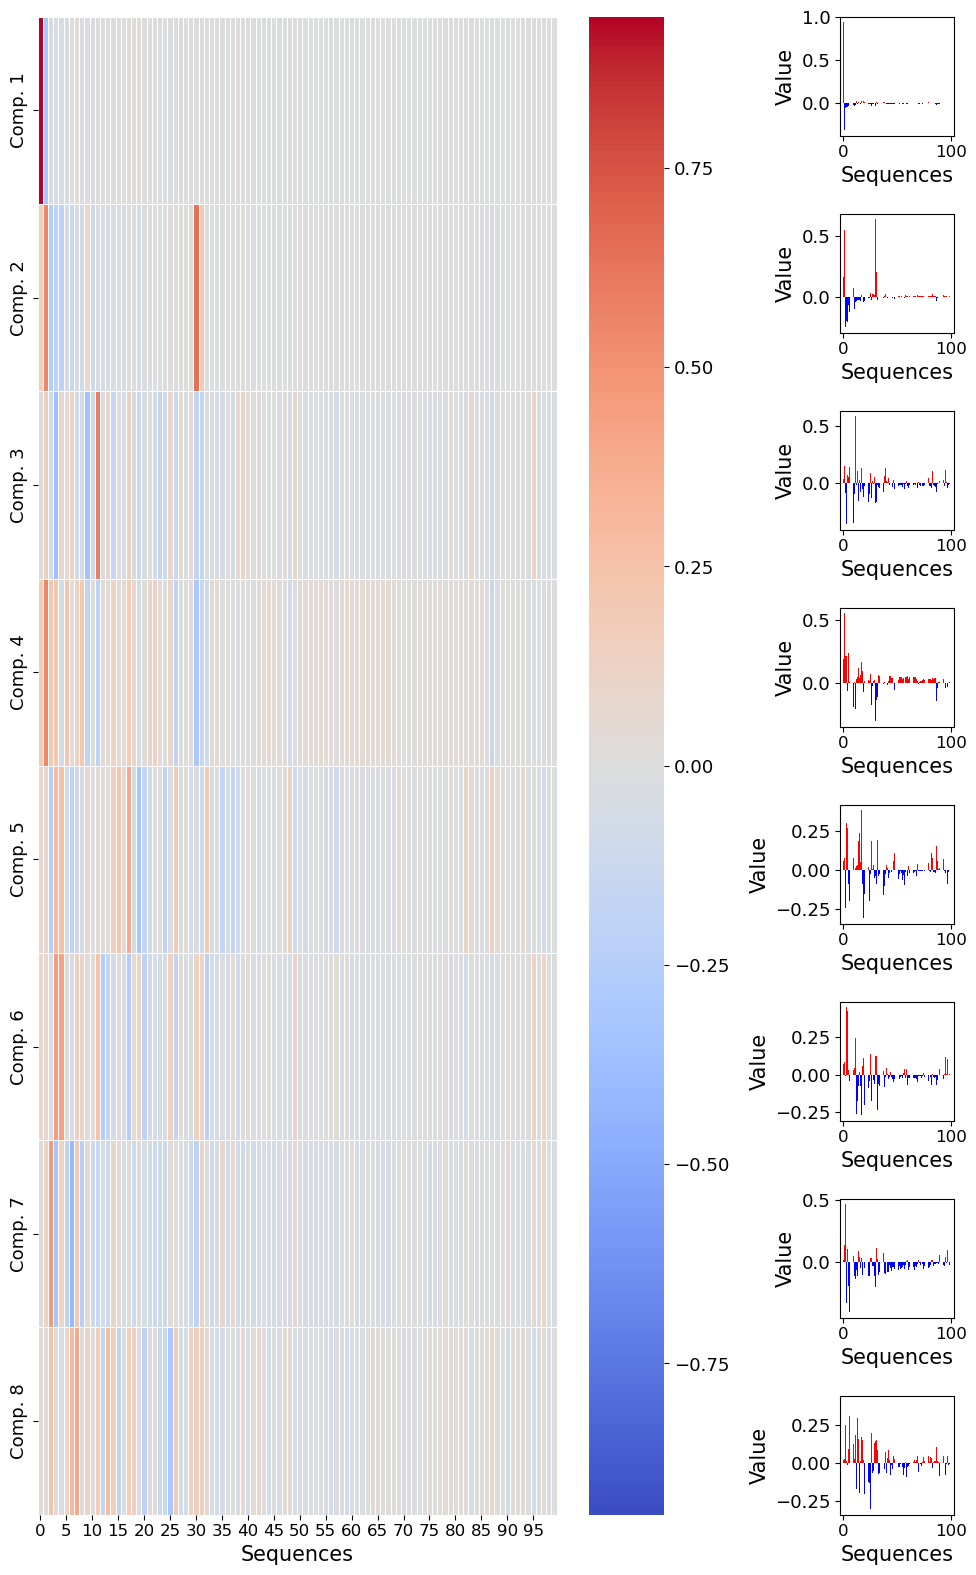

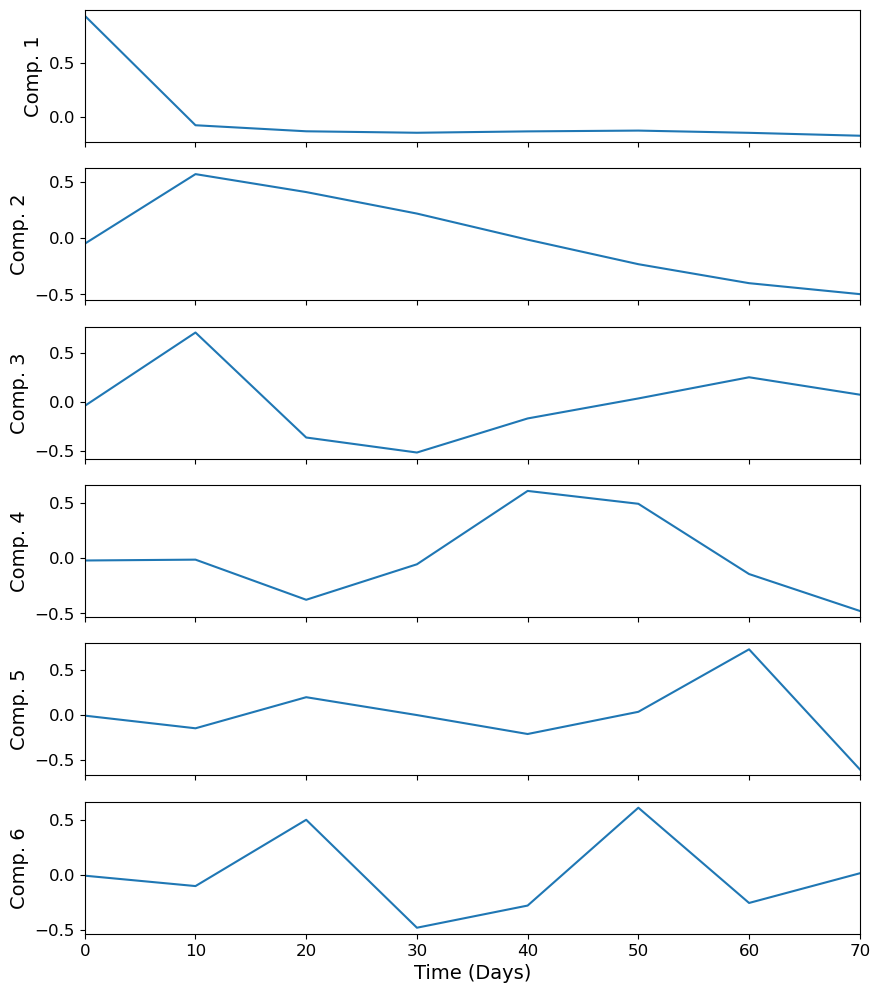

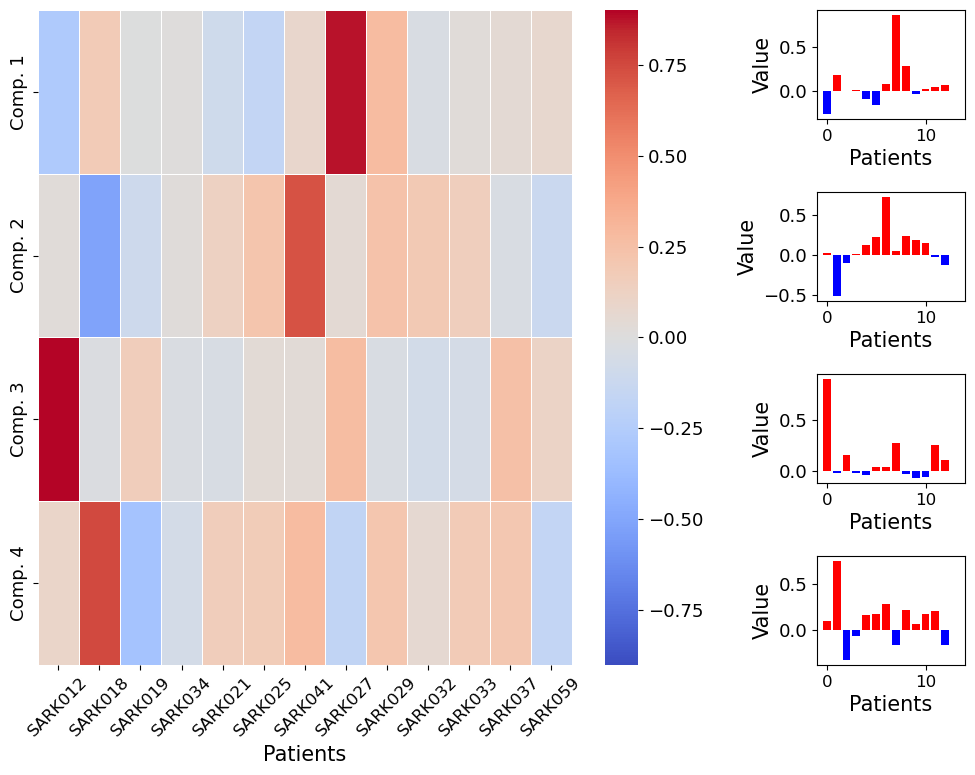

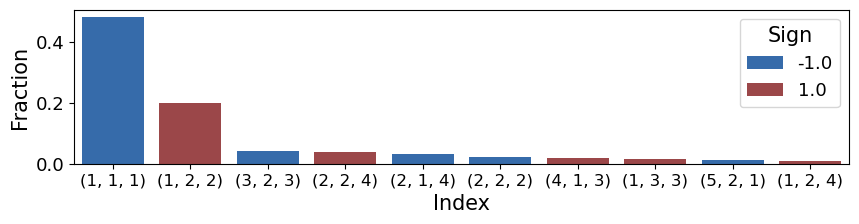

In [38]:
components_list=[[8, 3, 7],[8, 4, 6],[5, 4, 4],[8, 6, 4]]
for i in components_list:
    Tucker_decomp(tensor_70, i,'tensor_70', pat_list_70)


## tensor_70


 Checking decompositions for: cent_tensor_70
   Found rank (1, 2, 1)
   Found rank (4, 4, 7)
   Found rank (5, 2, 5)
   Found rank (15, 2, 5)
   Found rank (8, 3, 7)

 Plotting cent_tensor_70 with ranks (1, 2, 1)


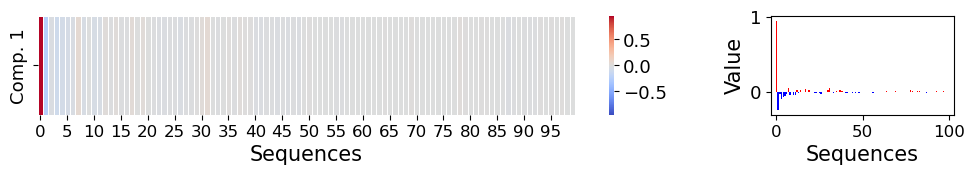

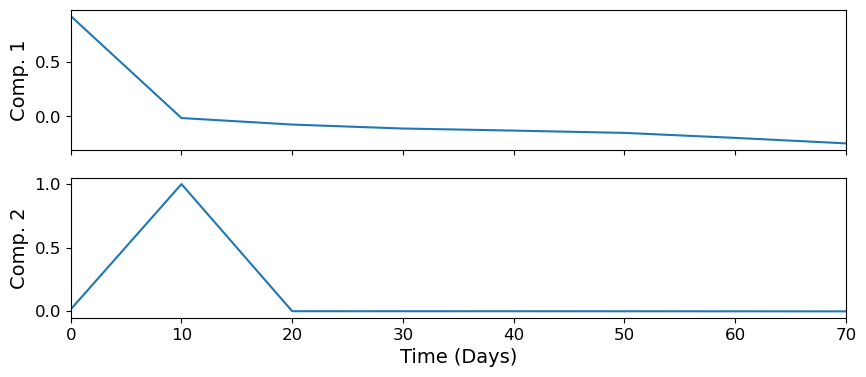

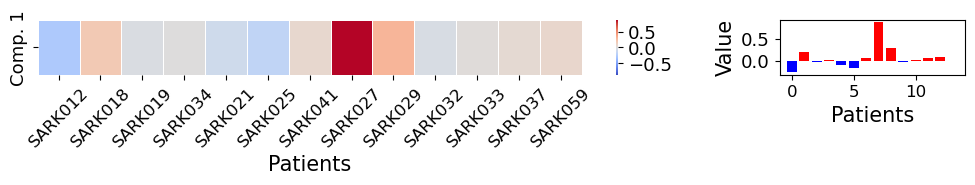

C:\Users\viola\AppData\Local\Temp\ipykernel_21800\3744488781.py:4: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(core_tensor.iloc[:10, :], x="Index", y="Fraction", hue="Sign", palette=["#2369BD", "#A9393C"], legend=True)


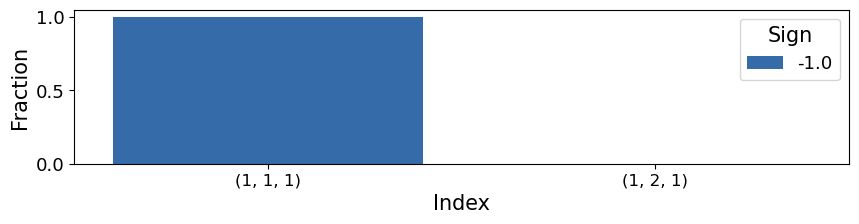


 Plotting cent_tensor_70 with ranks (4, 4, 7)


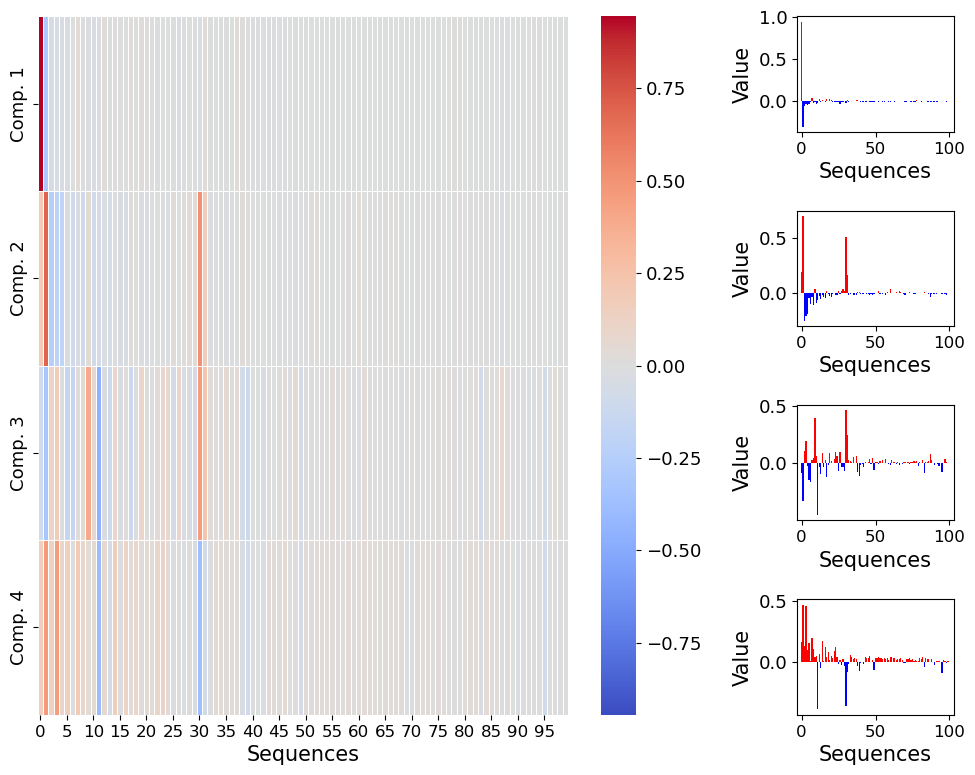

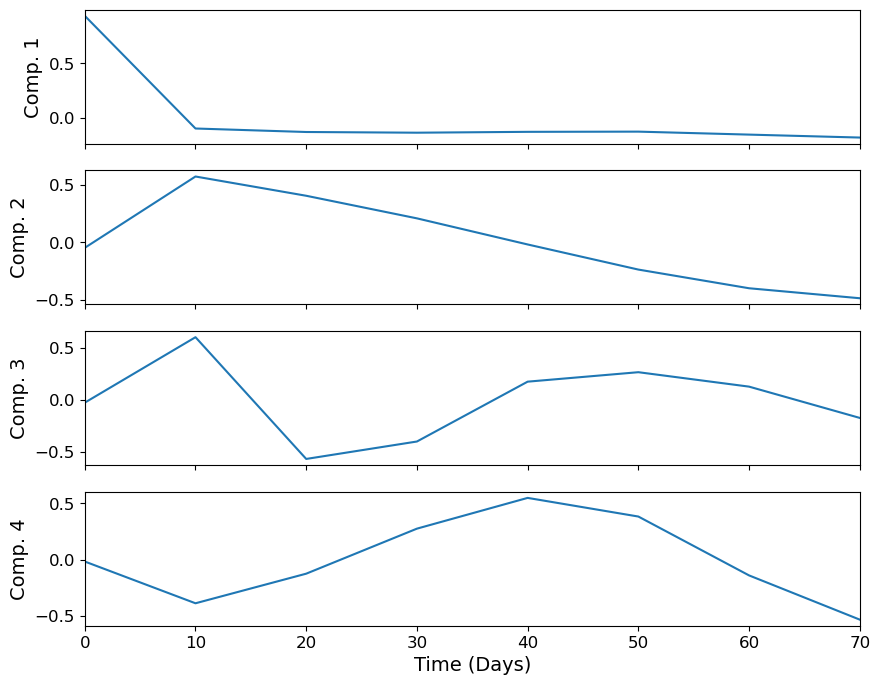

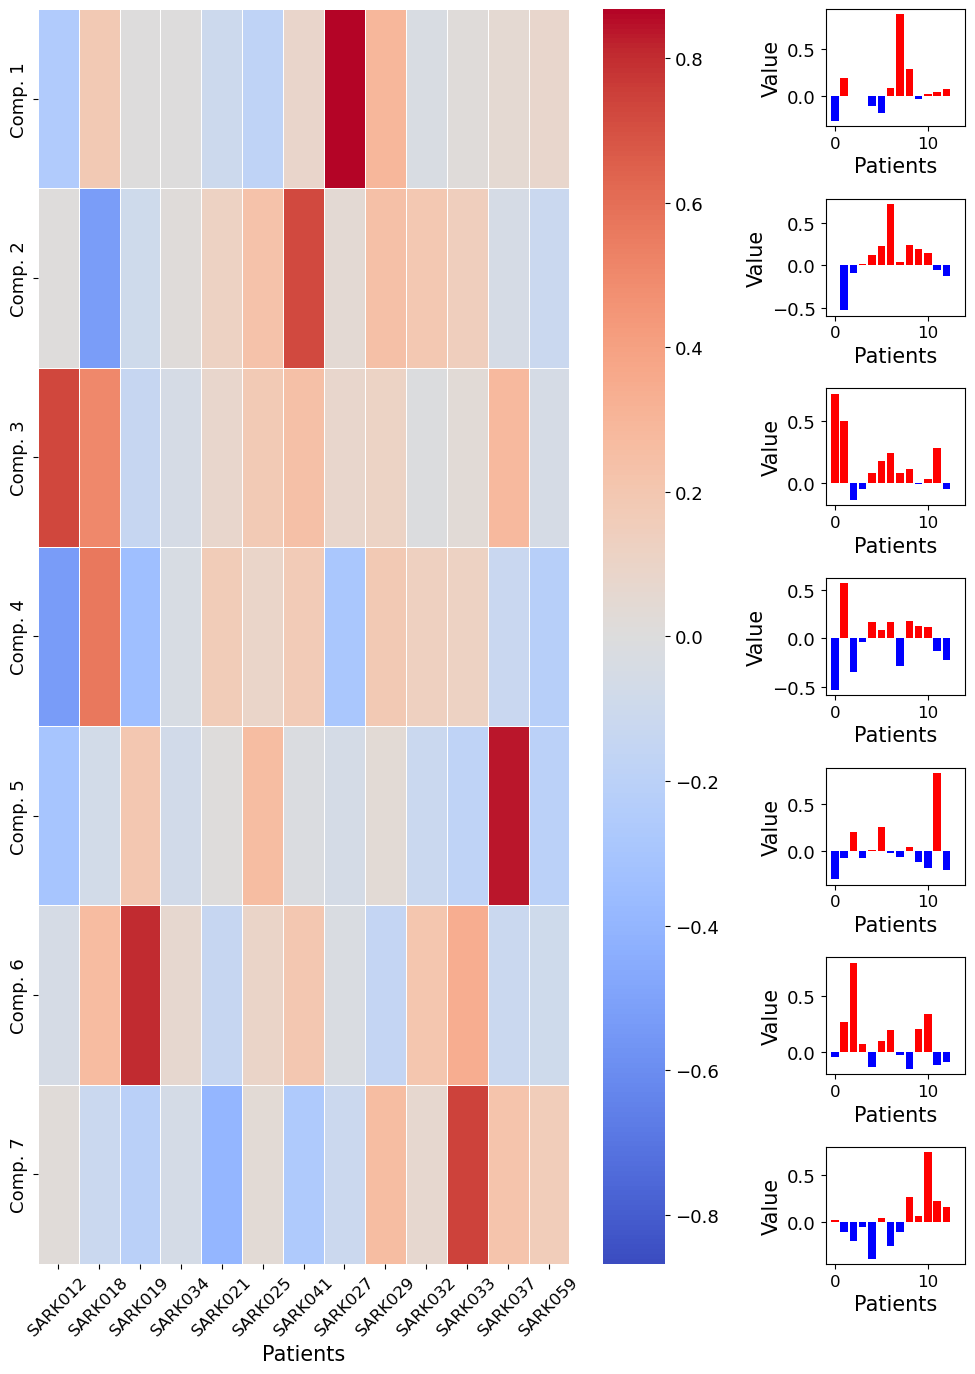

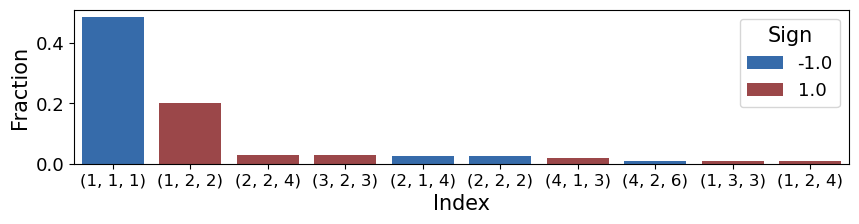


 Plotting cent_tensor_70 with ranks (5, 2, 5)


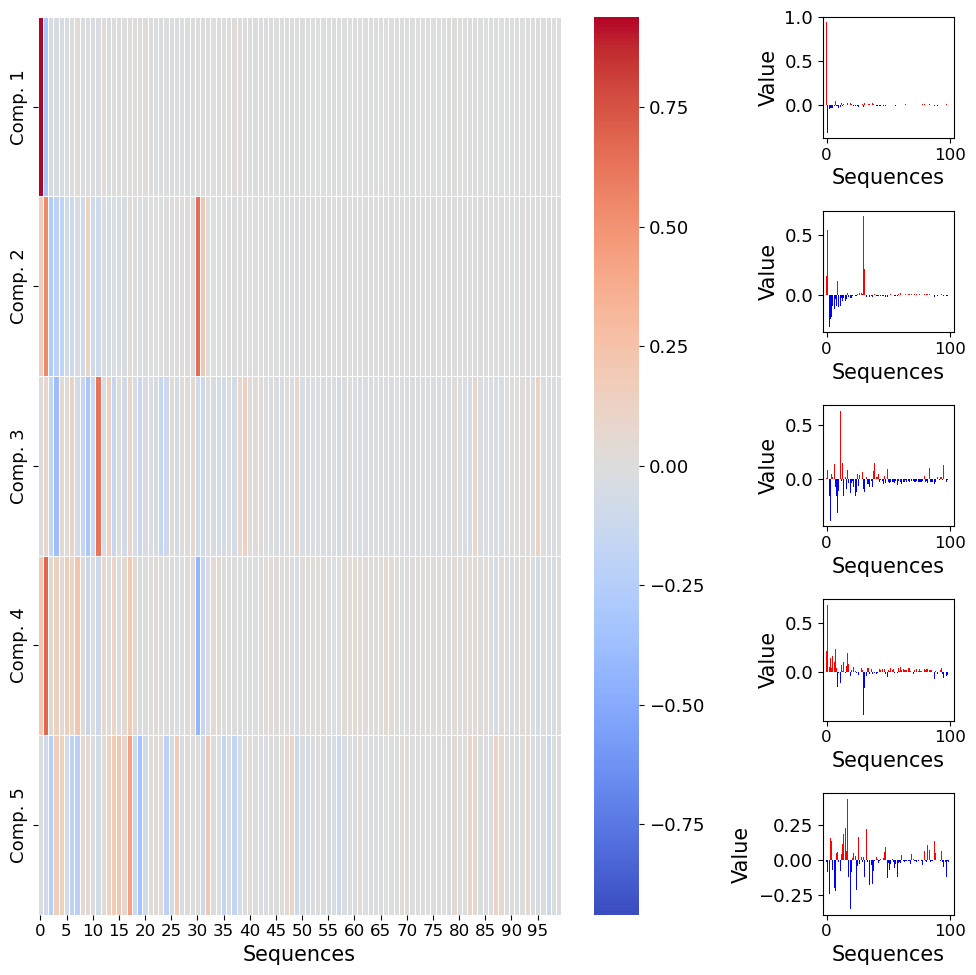

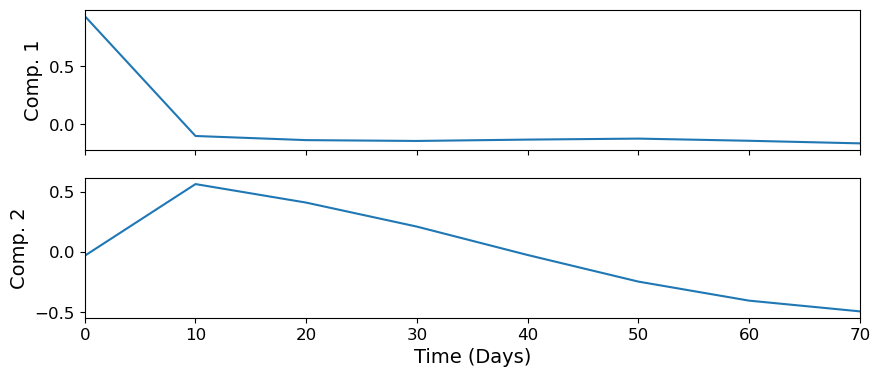

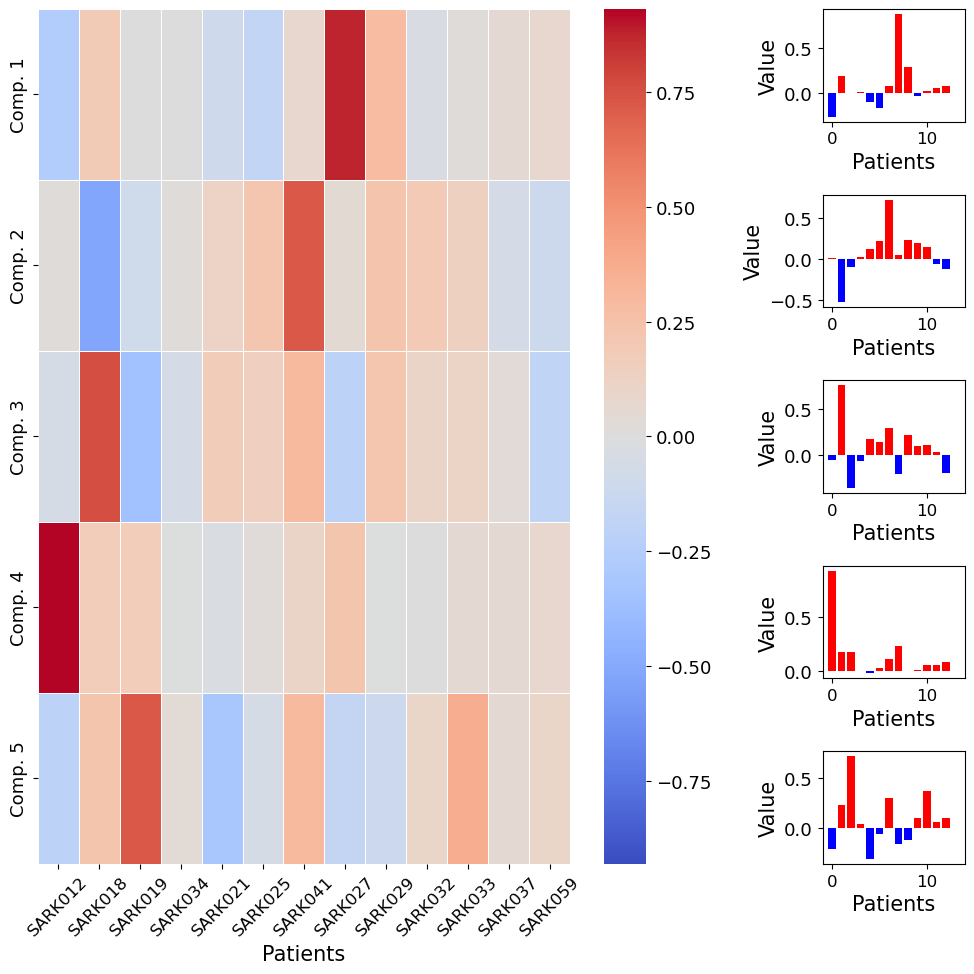

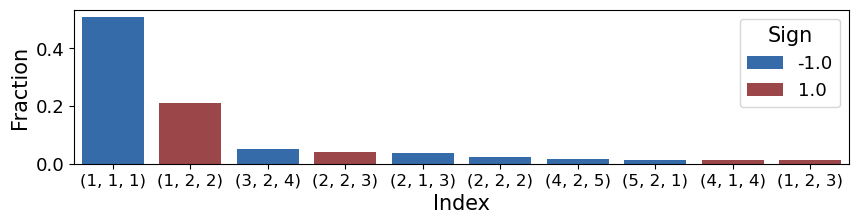


 Plotting cent_tensor_70 with ranks (15, 2, 5)


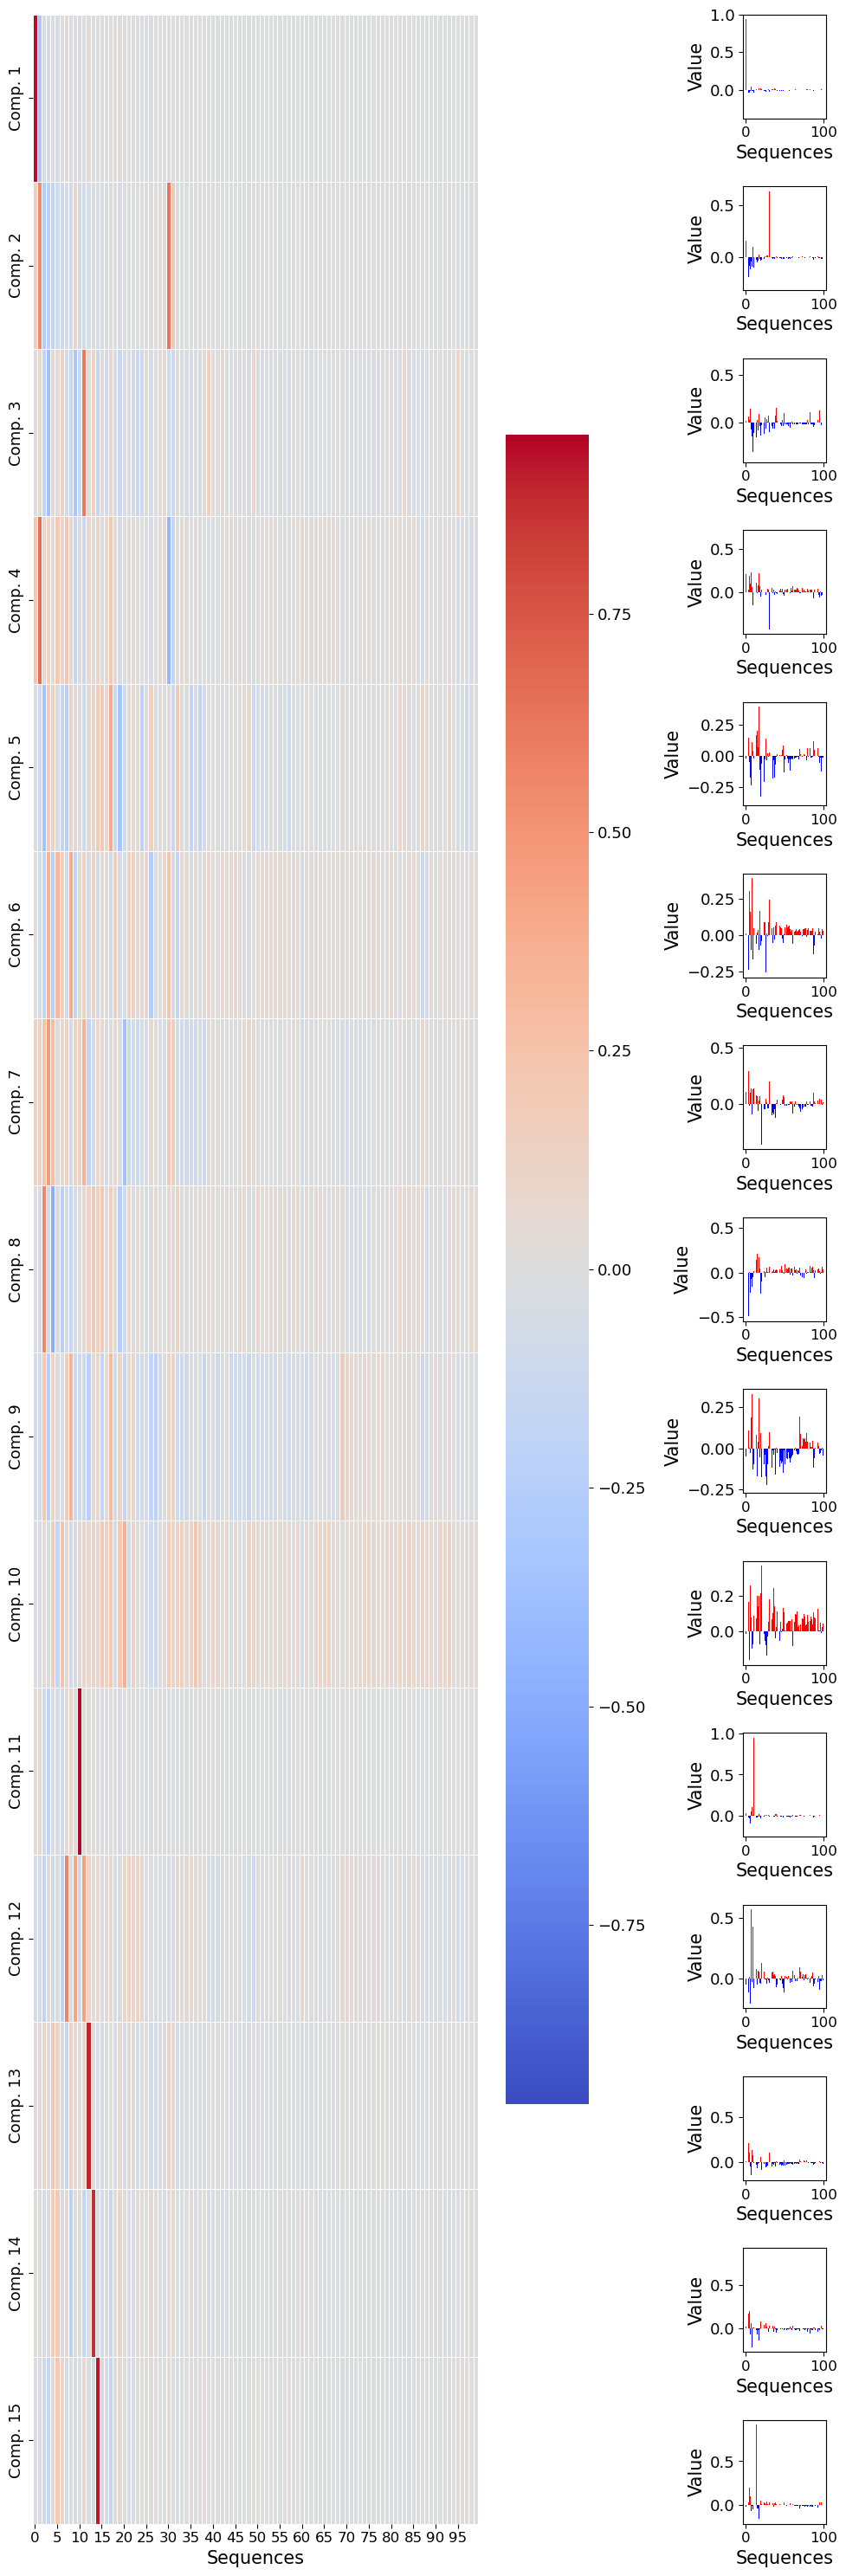

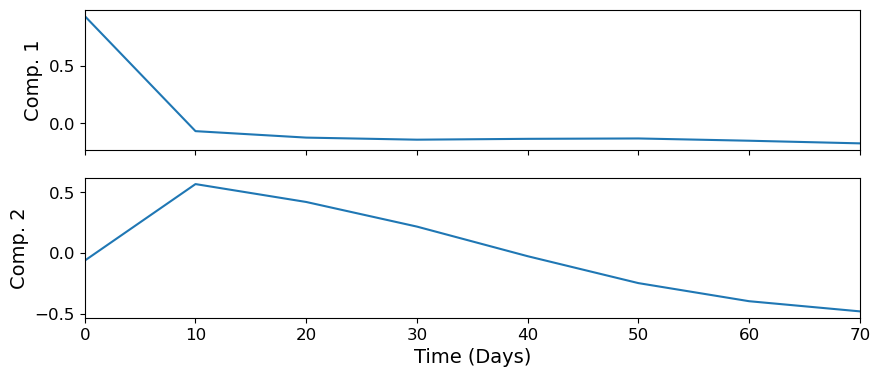

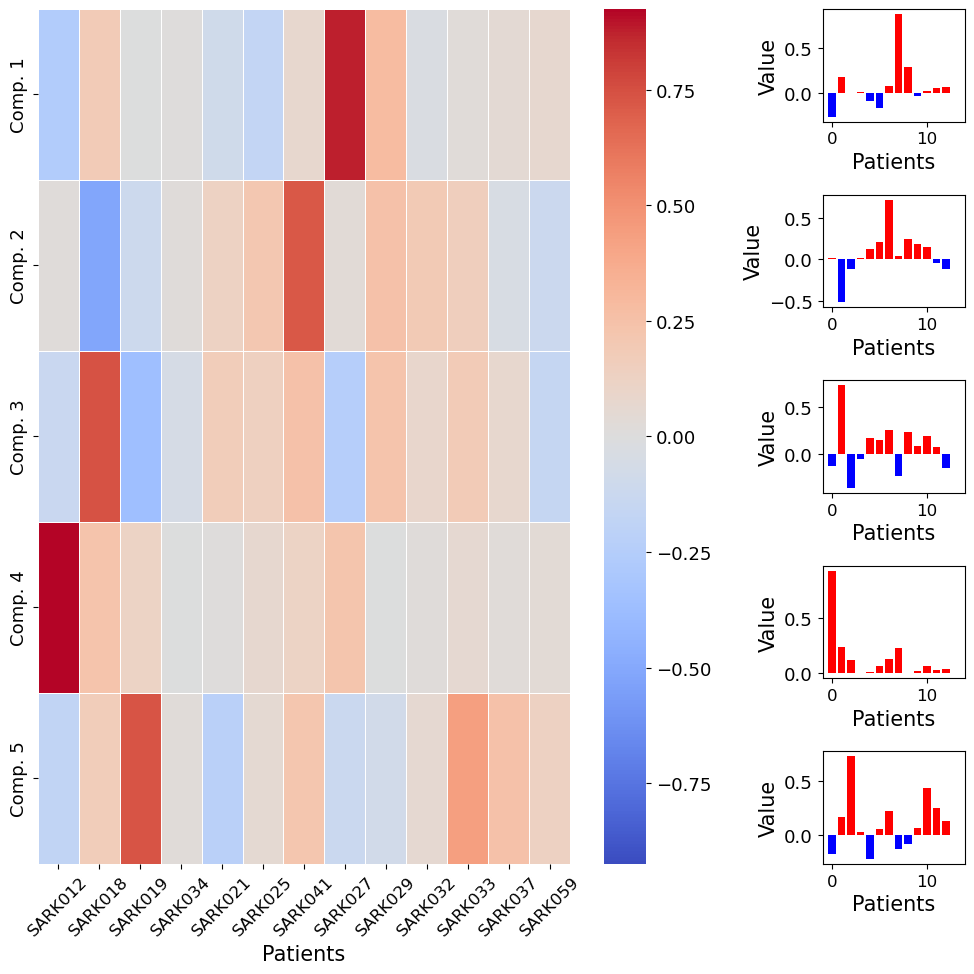

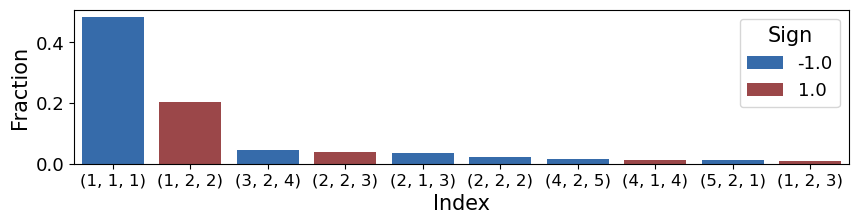


 Plotting cent_tensor_70 with ranks (8, 3, 7)


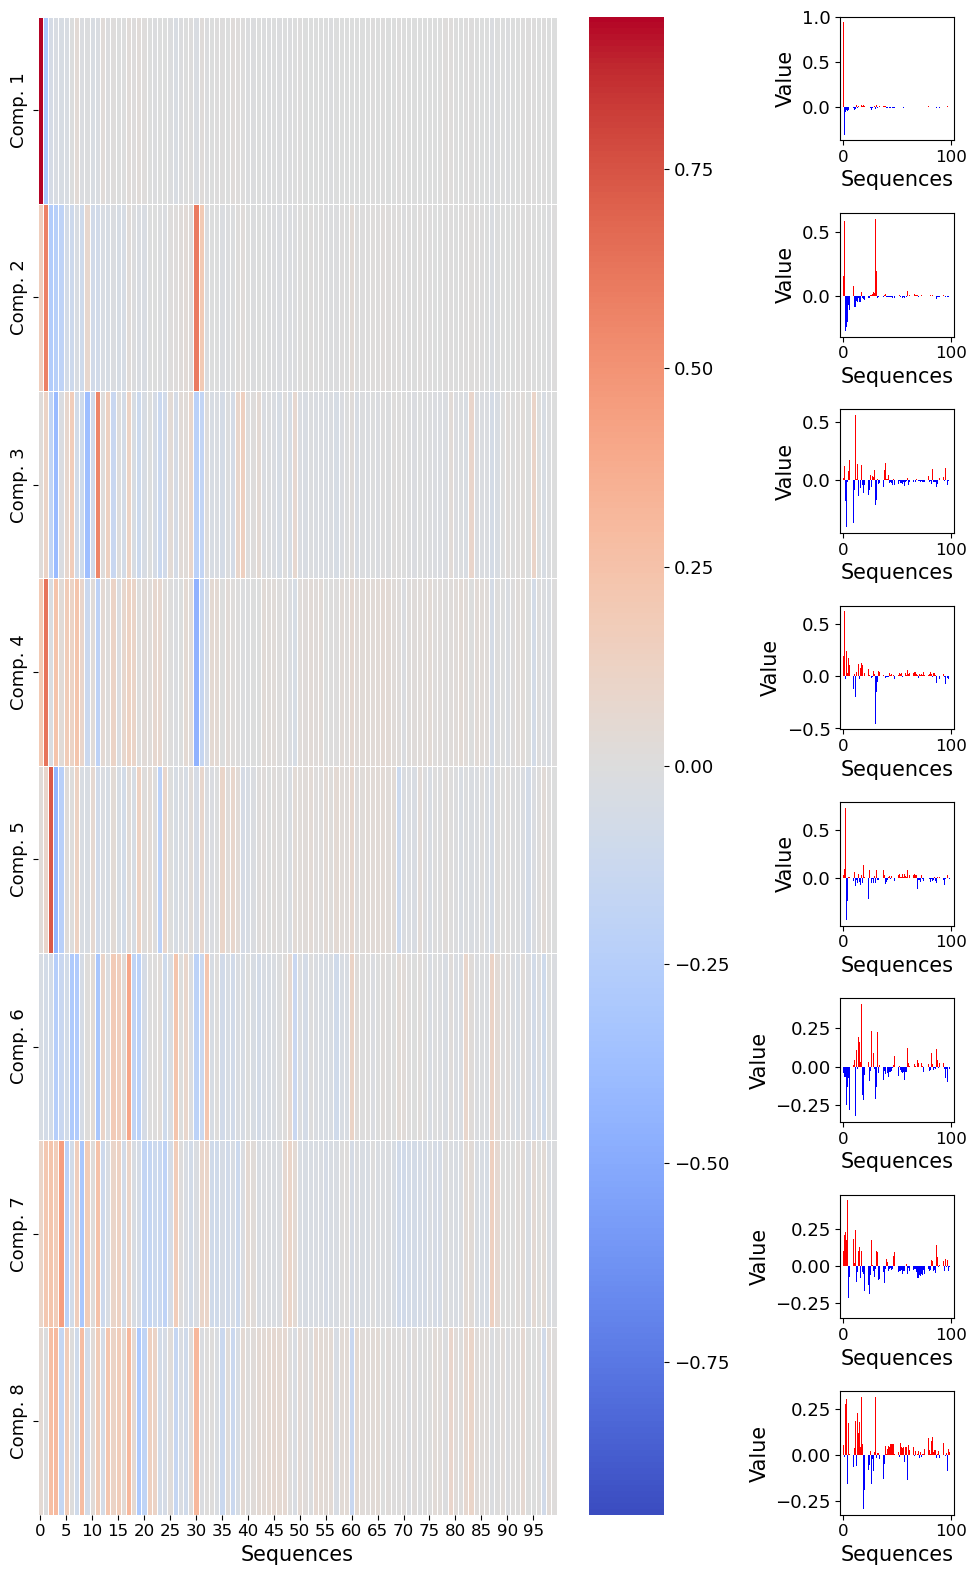

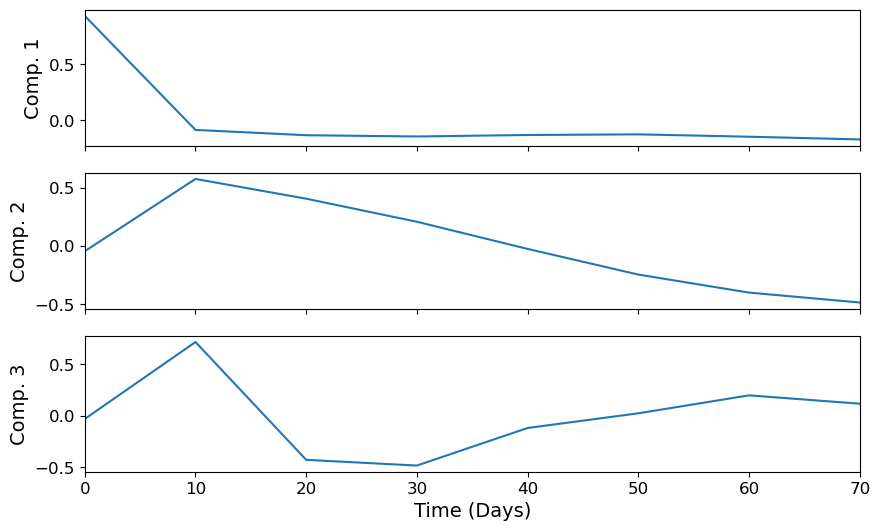

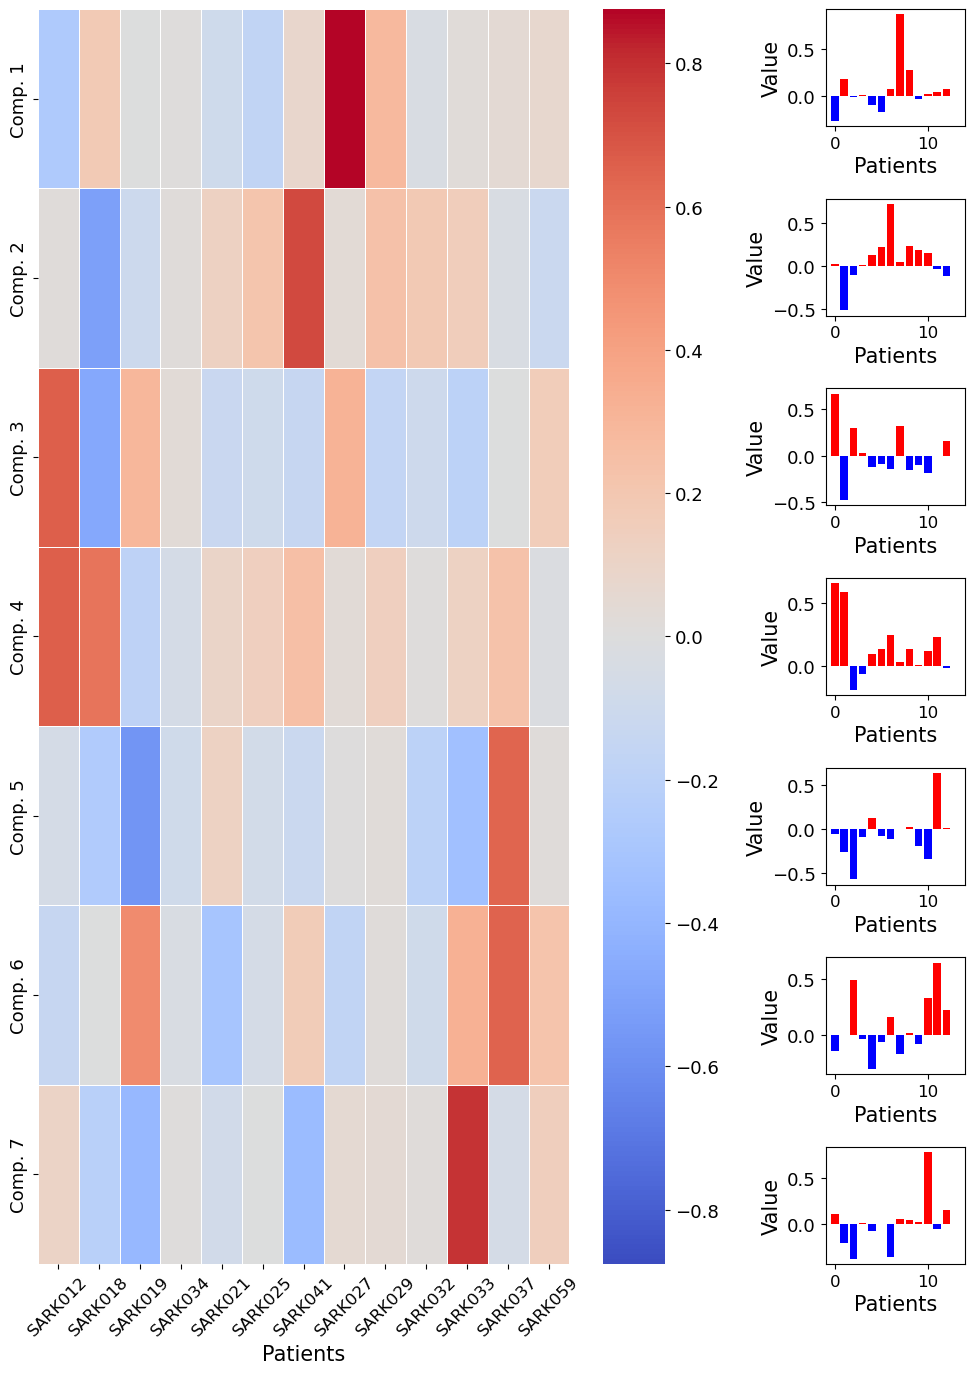

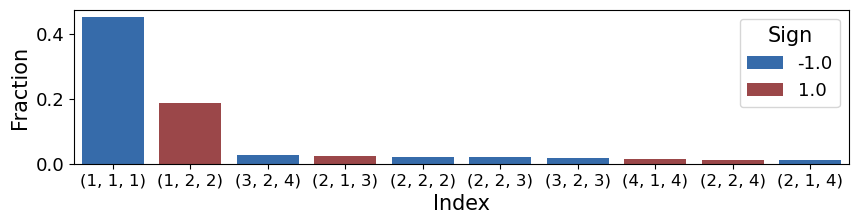

In [38]:
tensor_name = "tensor_70"
type_name = "cent" 

# Patient list for tensor_70
pat_list = [
    'SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
    'SARK041', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK059']

plot_all_rank_decompositions(tensor_name, type_name, tucker_results, pat_list)

## tensor_100


 Checking decompositions for: cent_tensor_100
   Found rank (2, 2, 3)
   Found rank (5, 4, 6)
   Found rank (5, 3, 5)
   Found rank (15, 3, 5)
   Found rank (8, 4, 6)

 Plotting cent_tensor_100 with ranks (2, 2, 3)


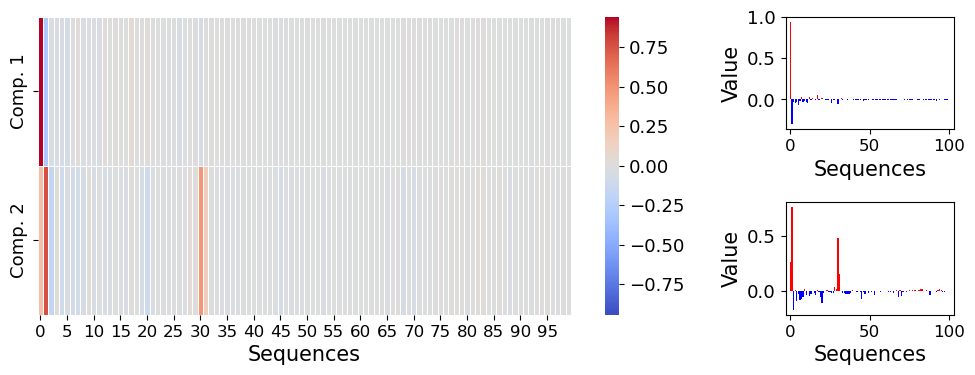

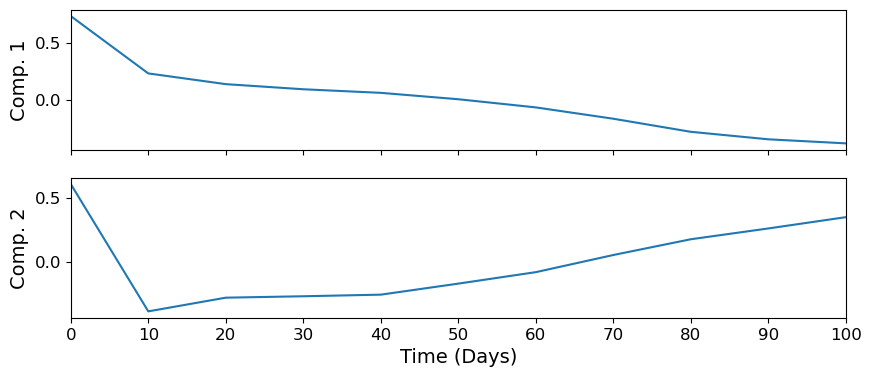

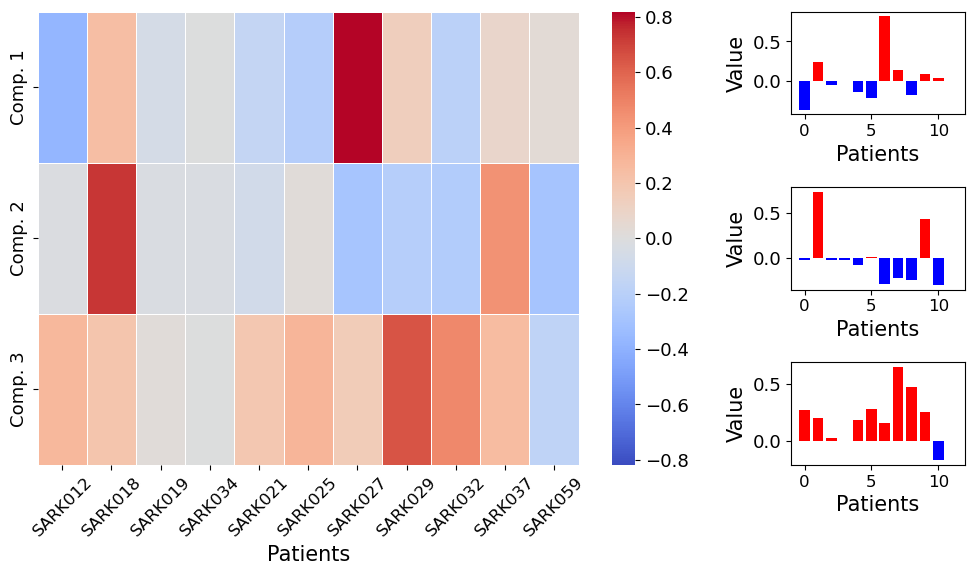

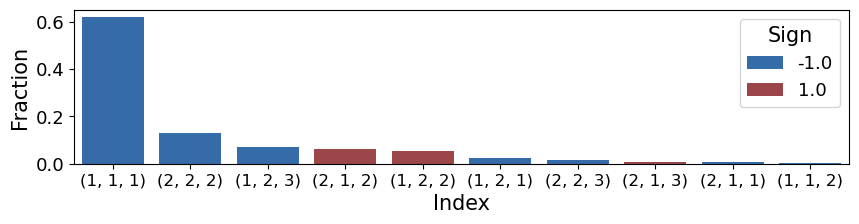


 Plotting cent_tensor_100 with ranks (5, 4, 6)


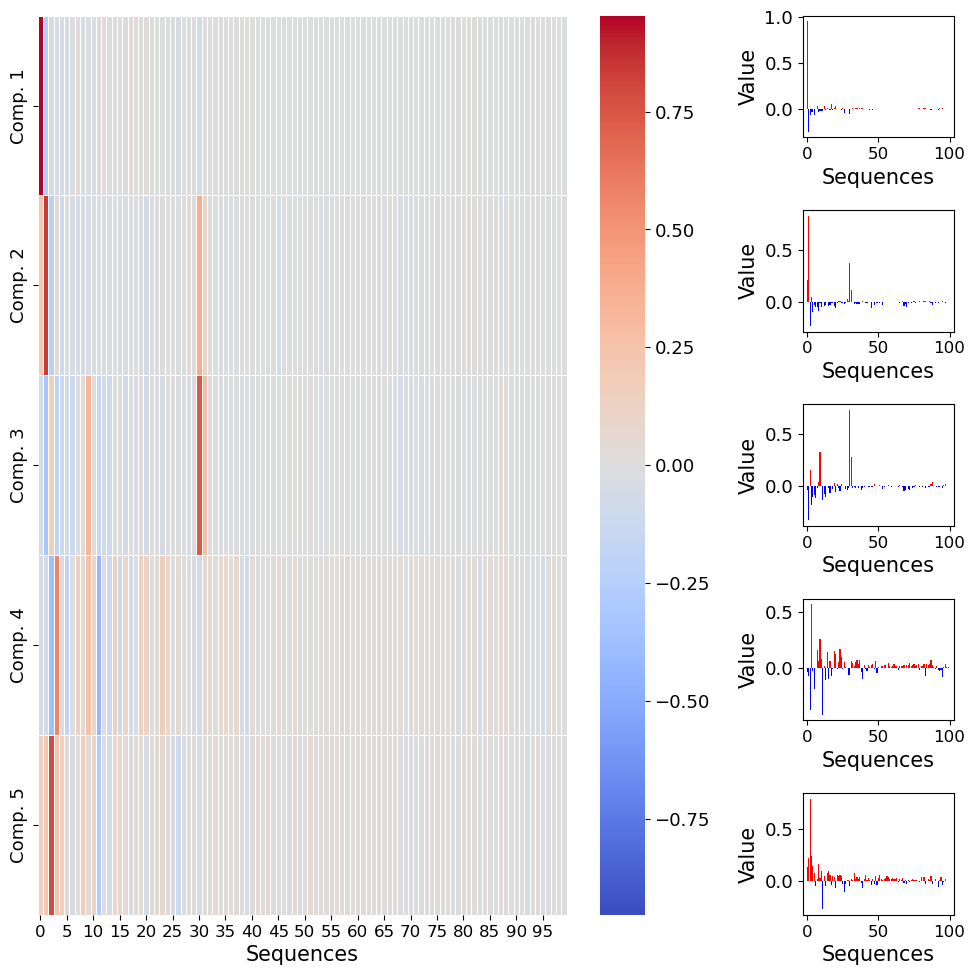

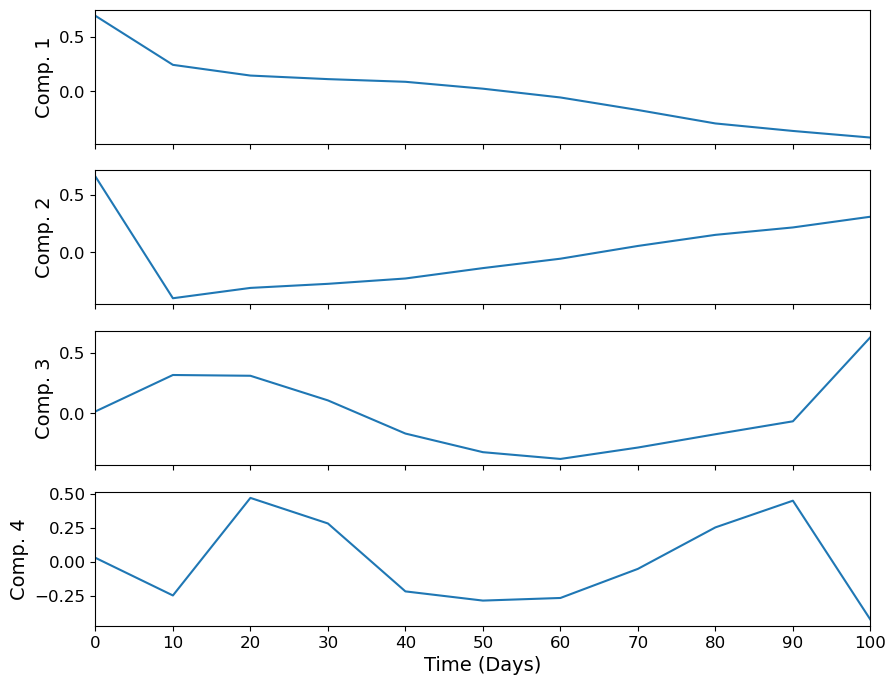

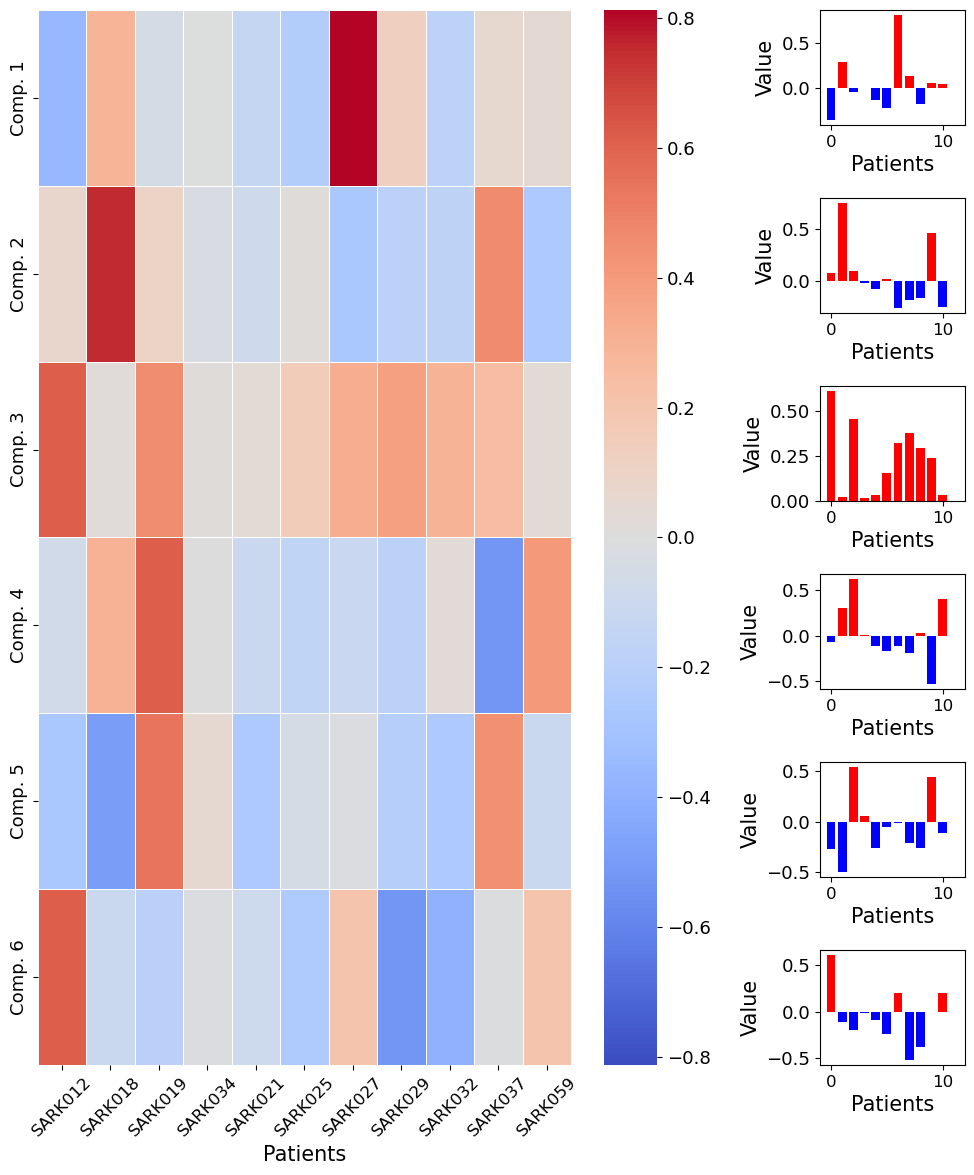

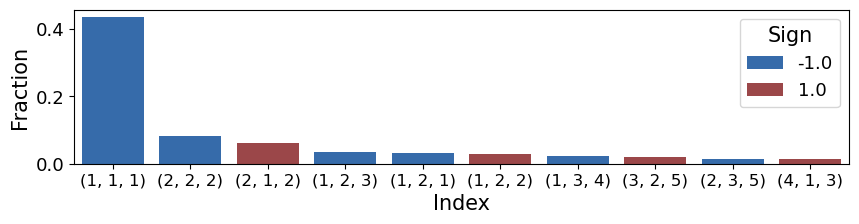


 Plotting cent_tensor_100 with ranks (5, 3, 5)


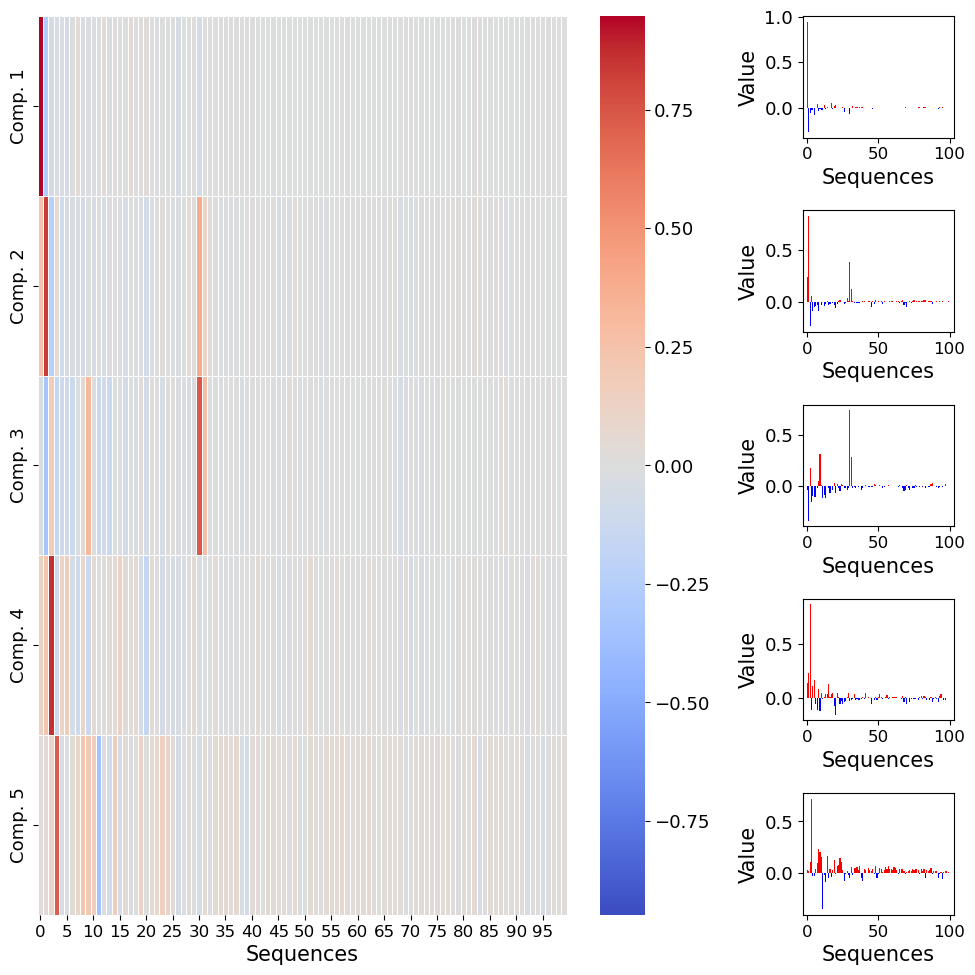

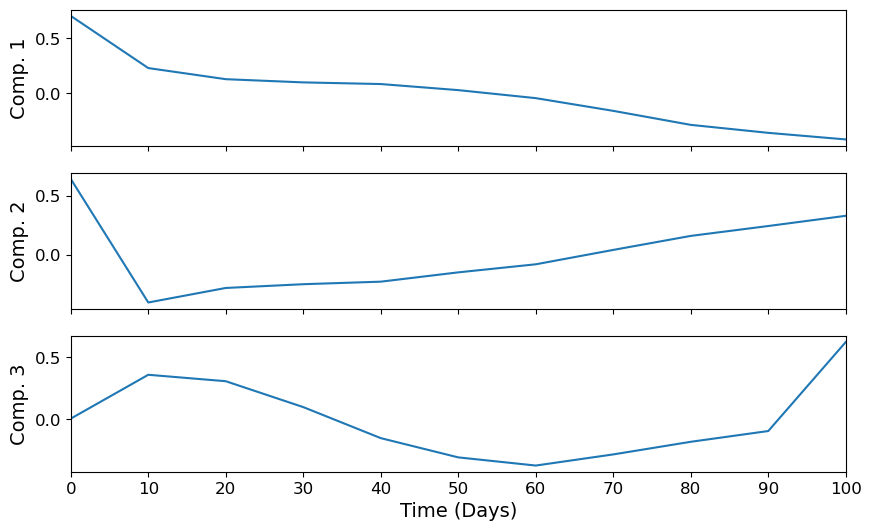

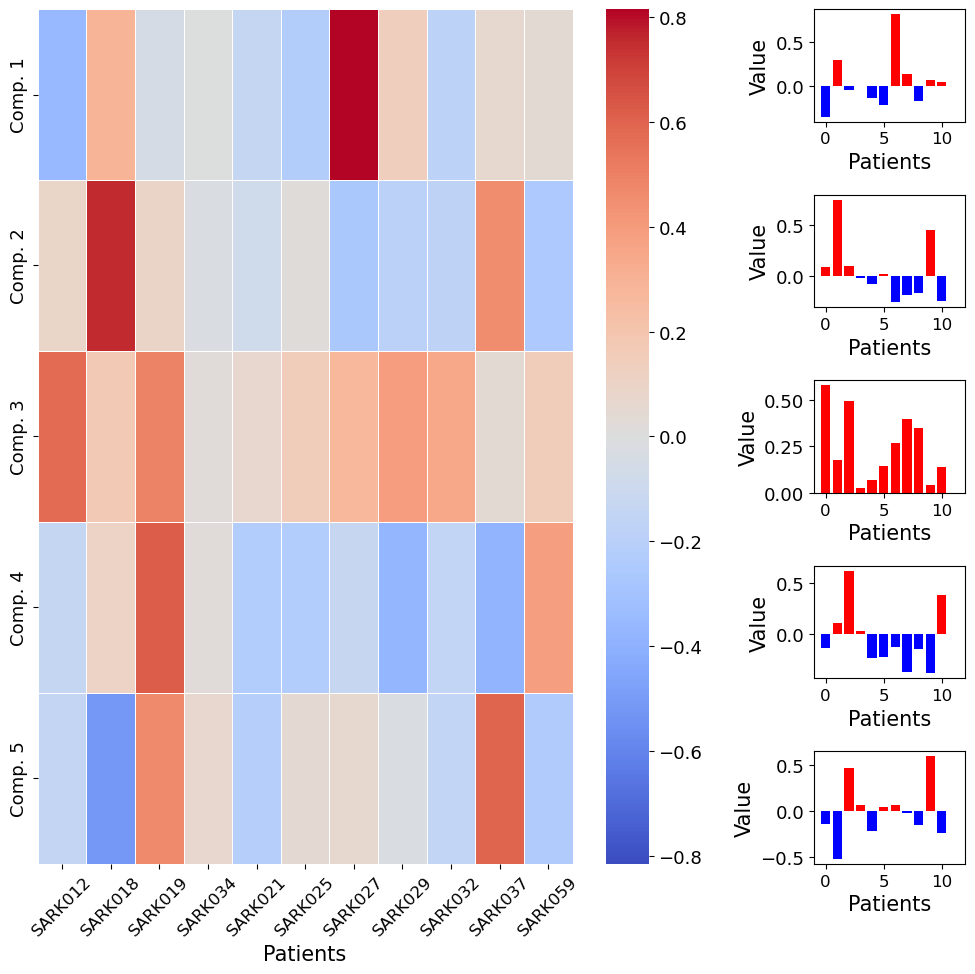

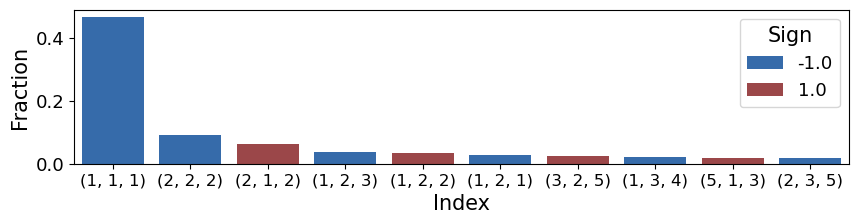


 Plotting cent_tensor_100 with ranks (15, 3, 5)


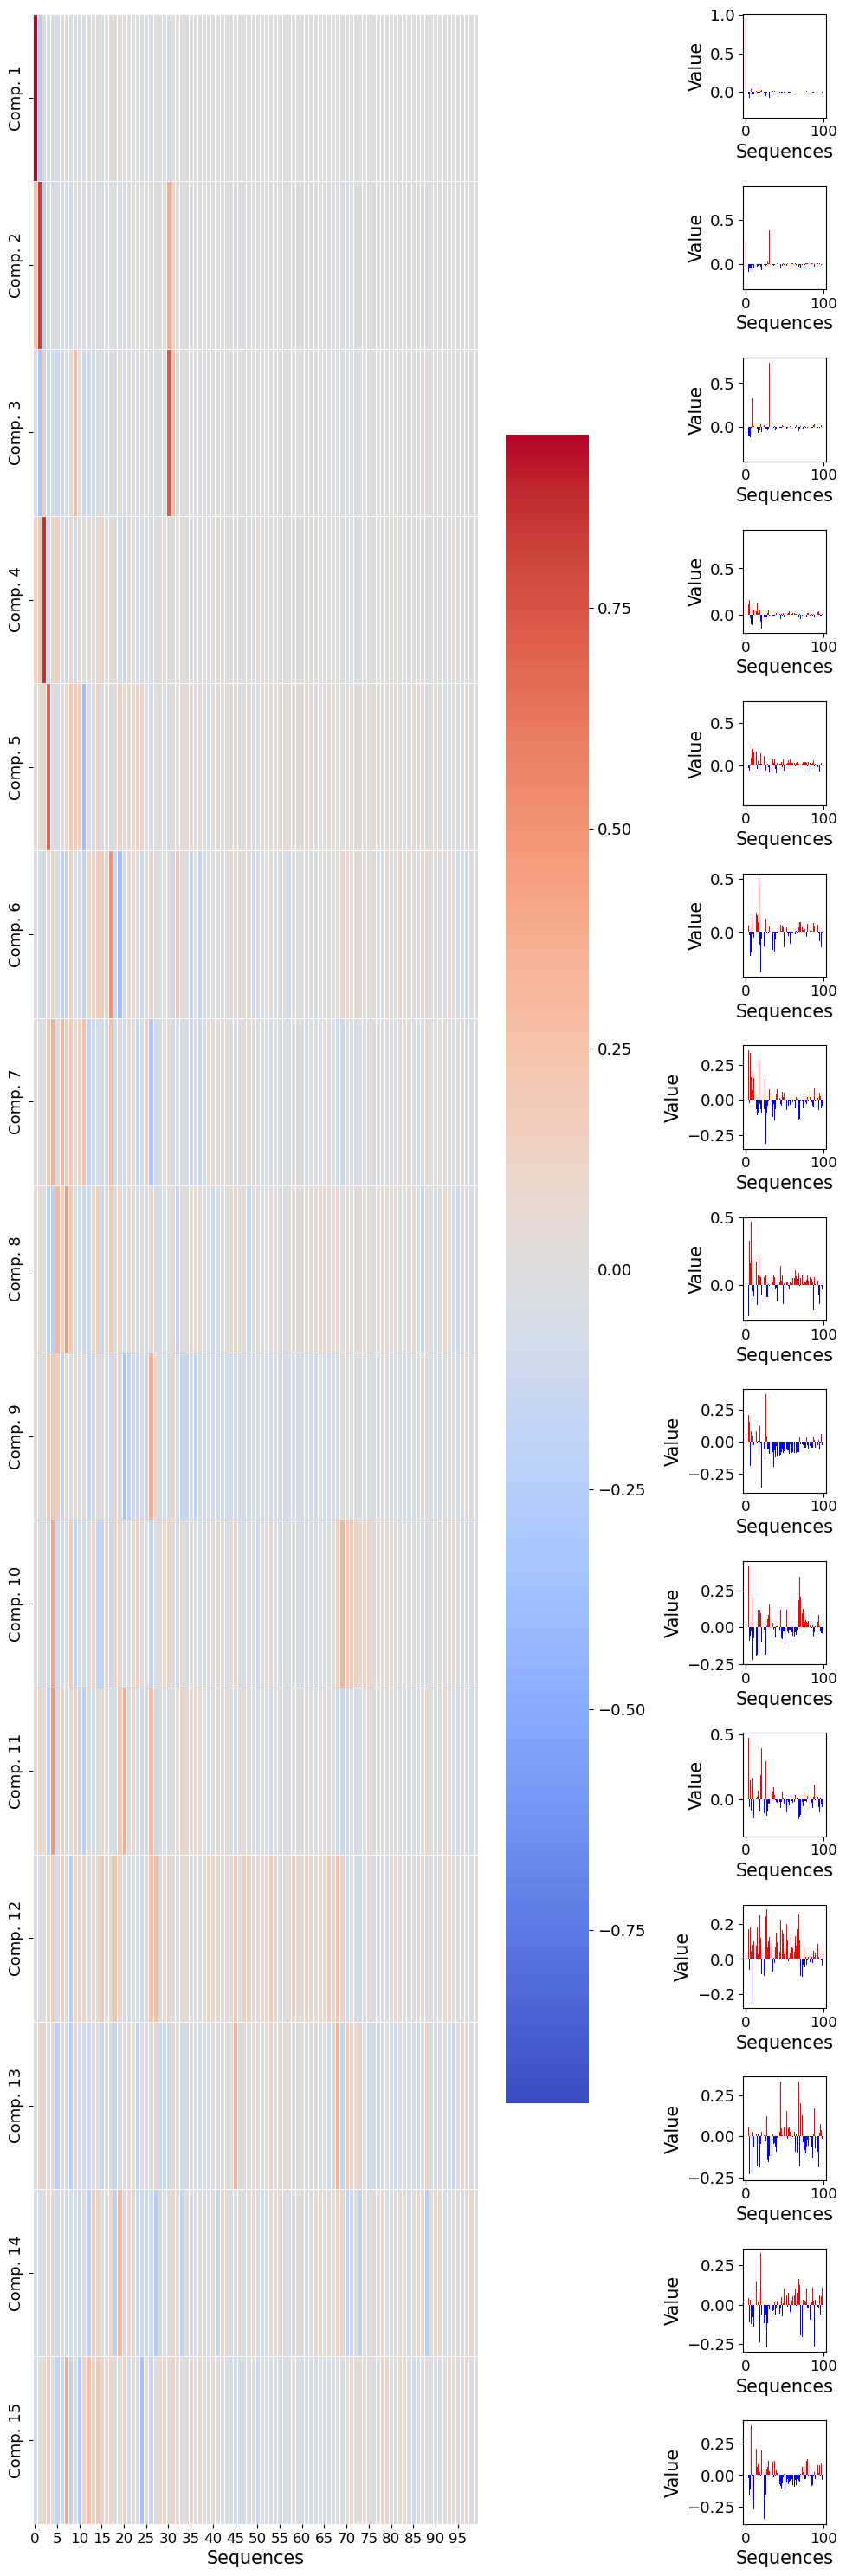

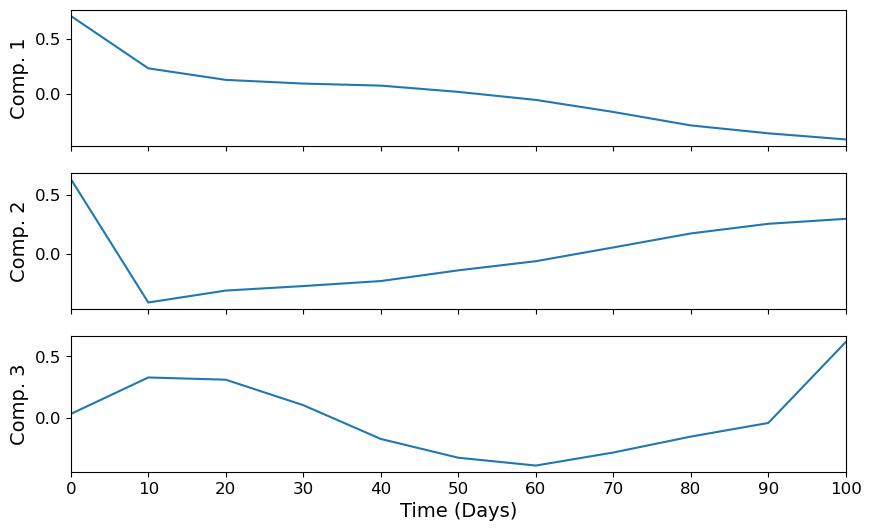

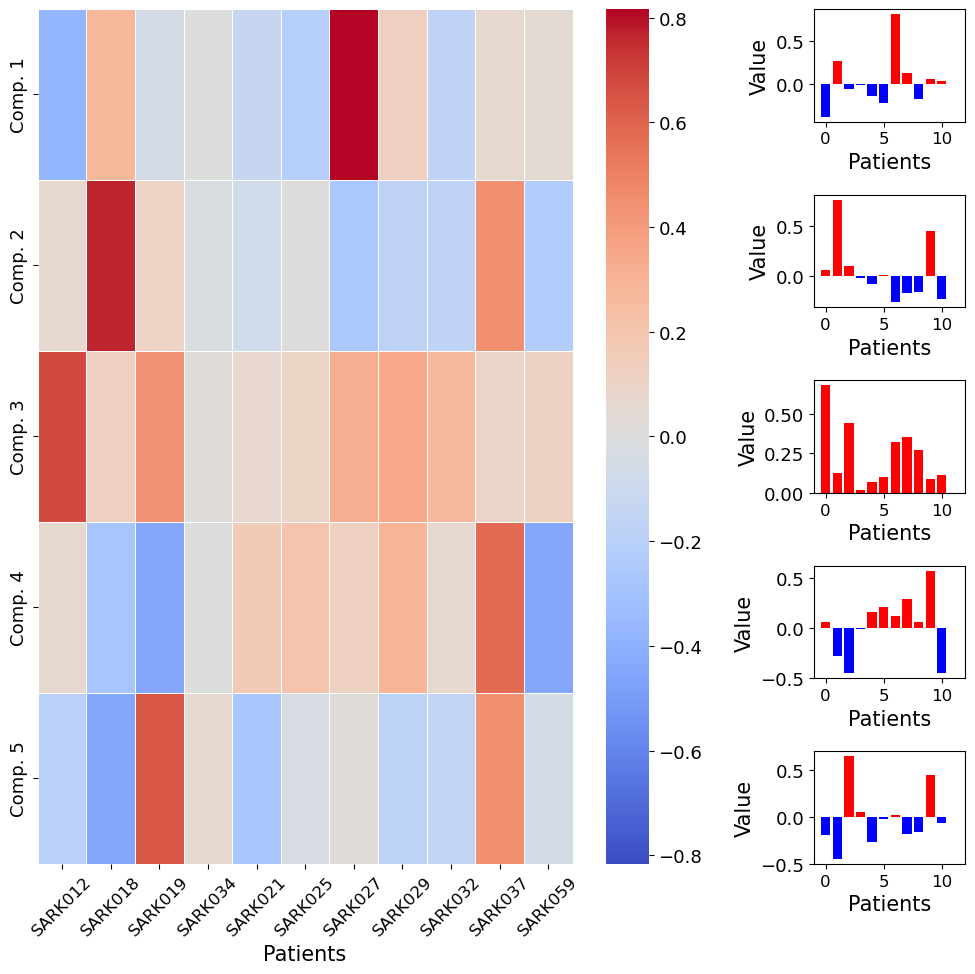

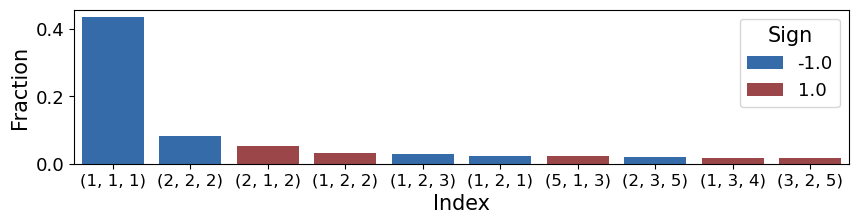


 Plotting cent_tensor_100 with ranks (8, 4, 6)


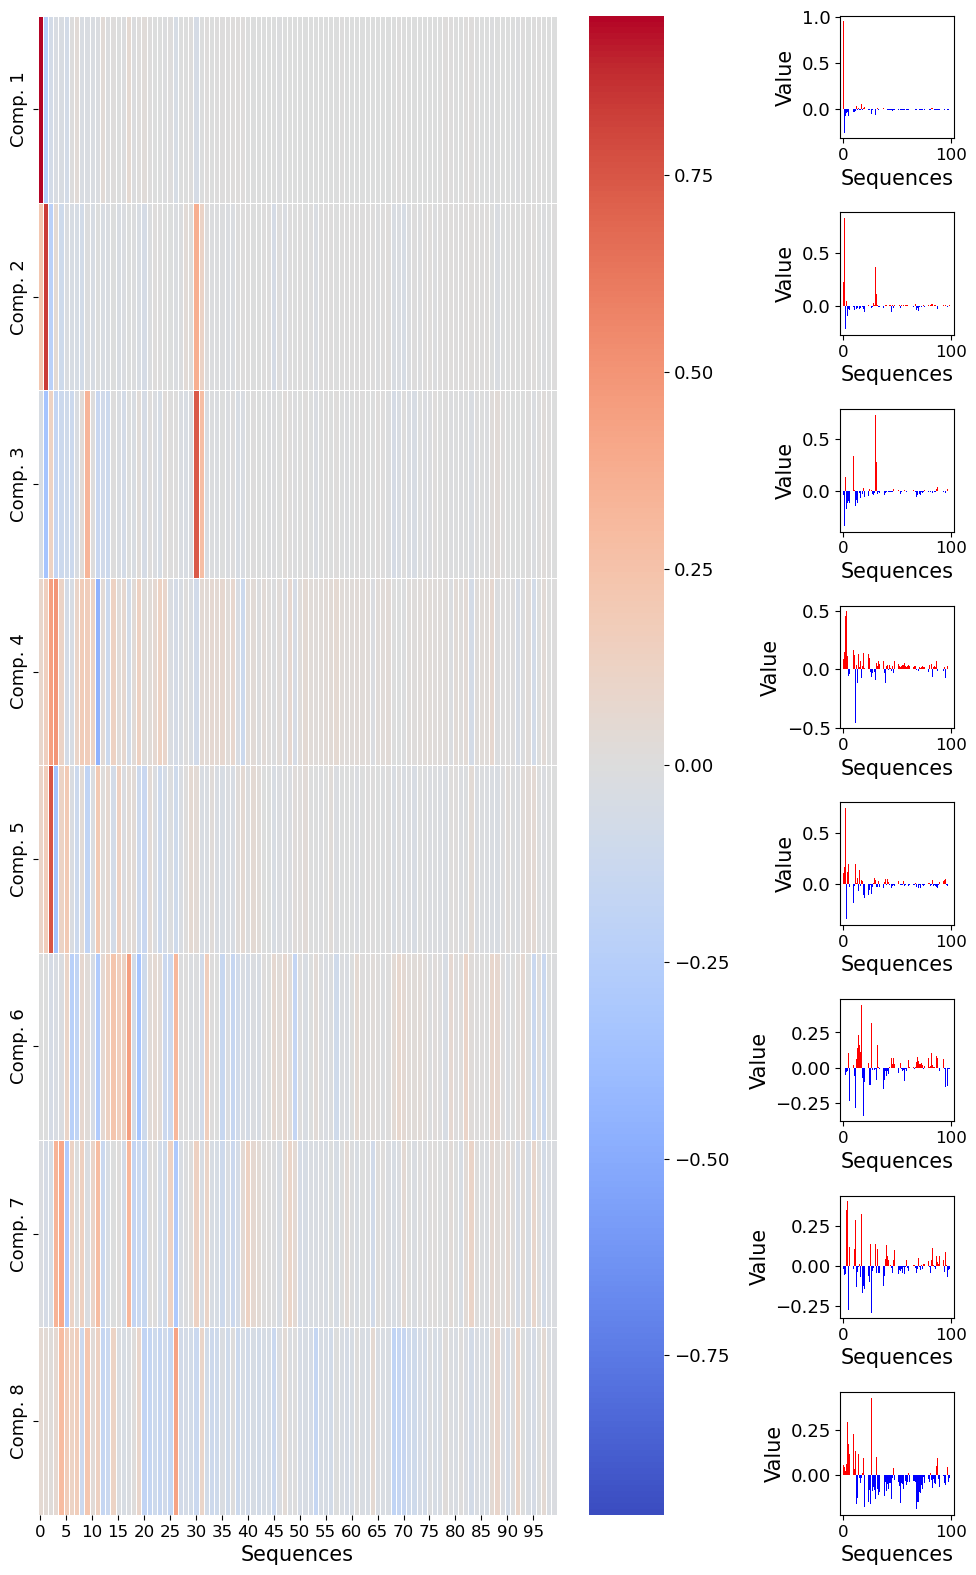

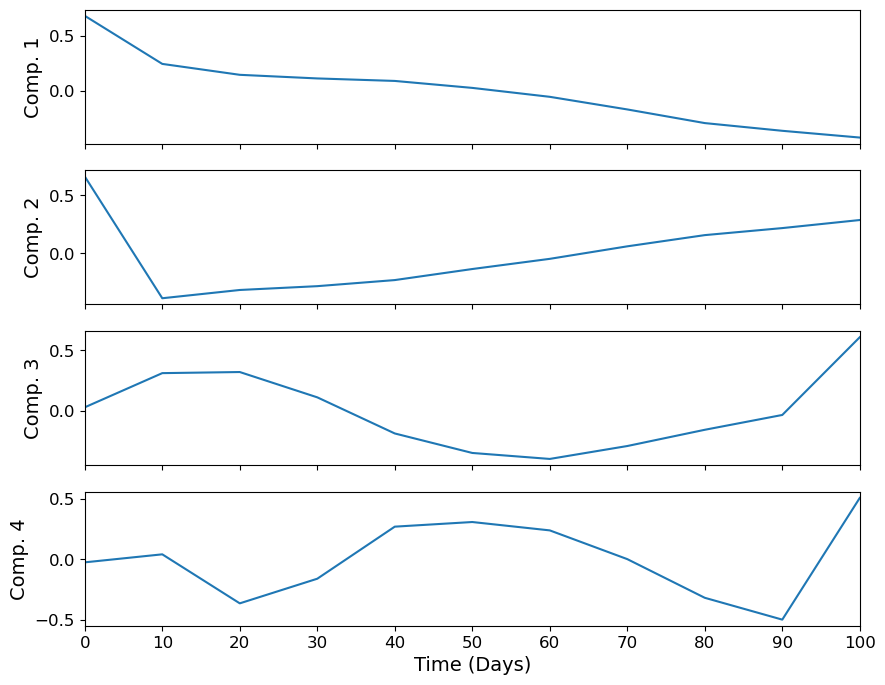

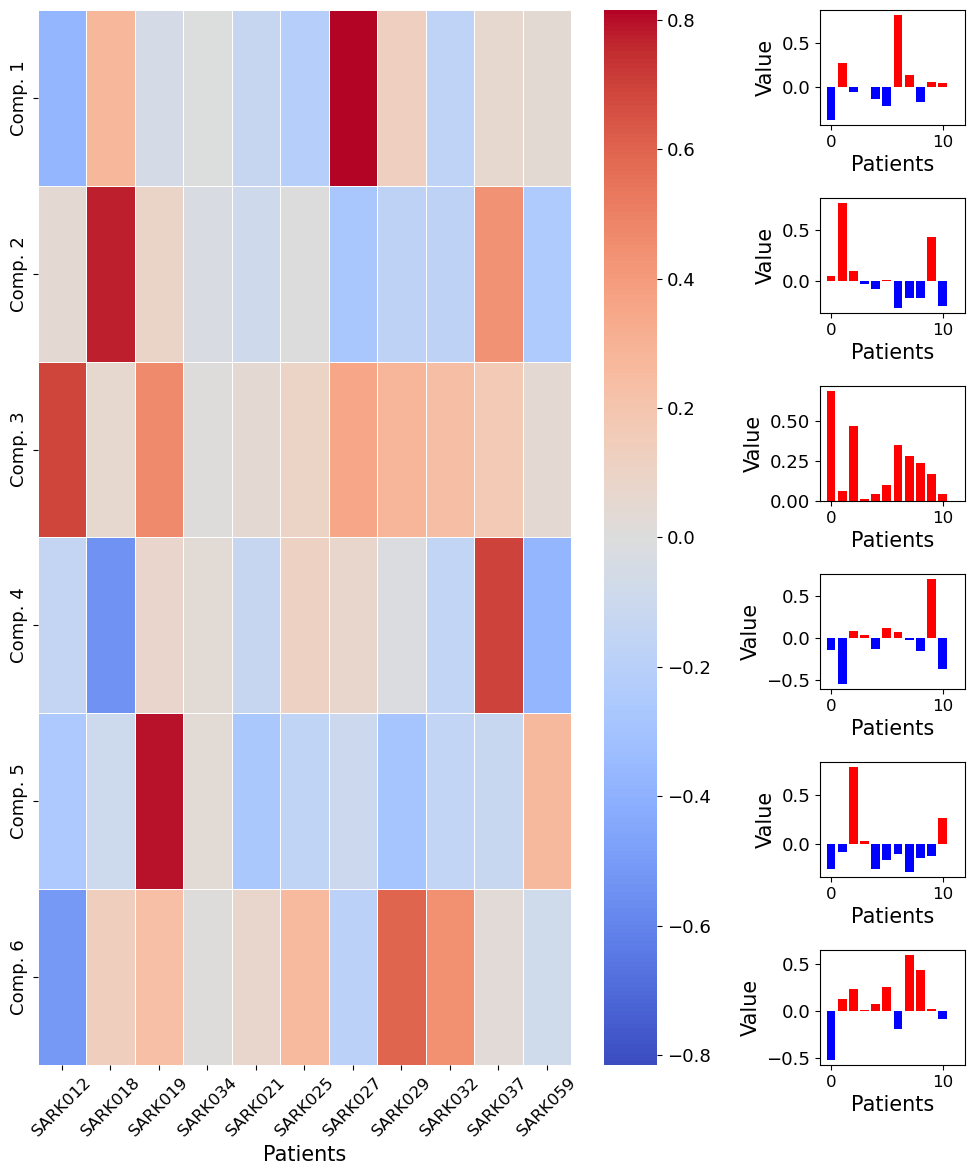

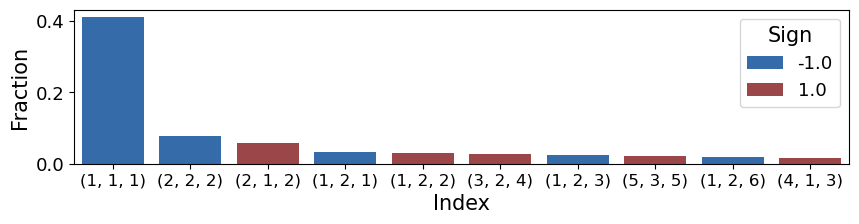

In [39]:
pat_list = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK027', 'SARK029', 'SARK032', 'SARK037', 'SARK059']
tensor_name = "tensor_100"
type_name = "cent" 
plot_all_rank_decompositions(tensor_name, type_name, tucker_results, pat_list)


## tensor_200


 Checking decompositions for: cent_tensor_200
   Found rank (2, 2, 2)
   Found rank (4, 5, 6)
   Found rank (3, 3, 3)
   Found rank (12, 5, 3)
   Found rank (5, 4, 4)

 Plotting cent_tensor_200 with ranks (2, 2, 2)


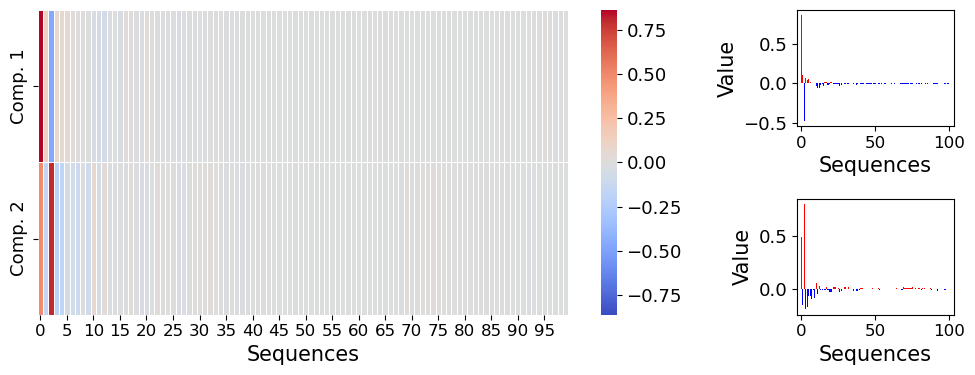

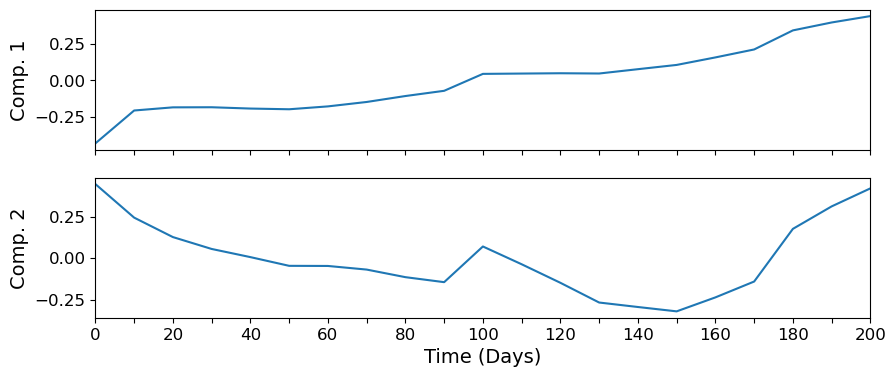

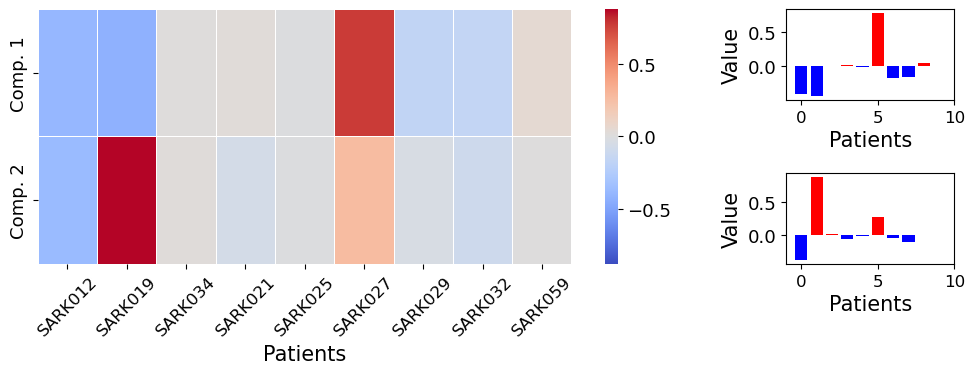

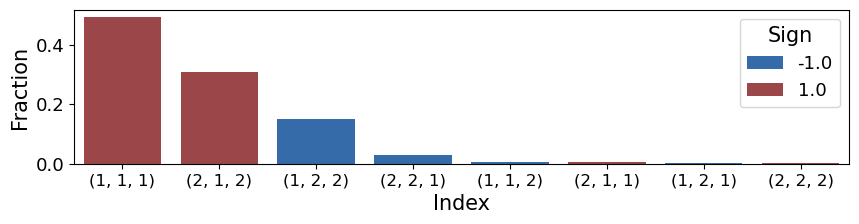


 Plotting cent_tensor_200 with ranks (4, 5, 6)


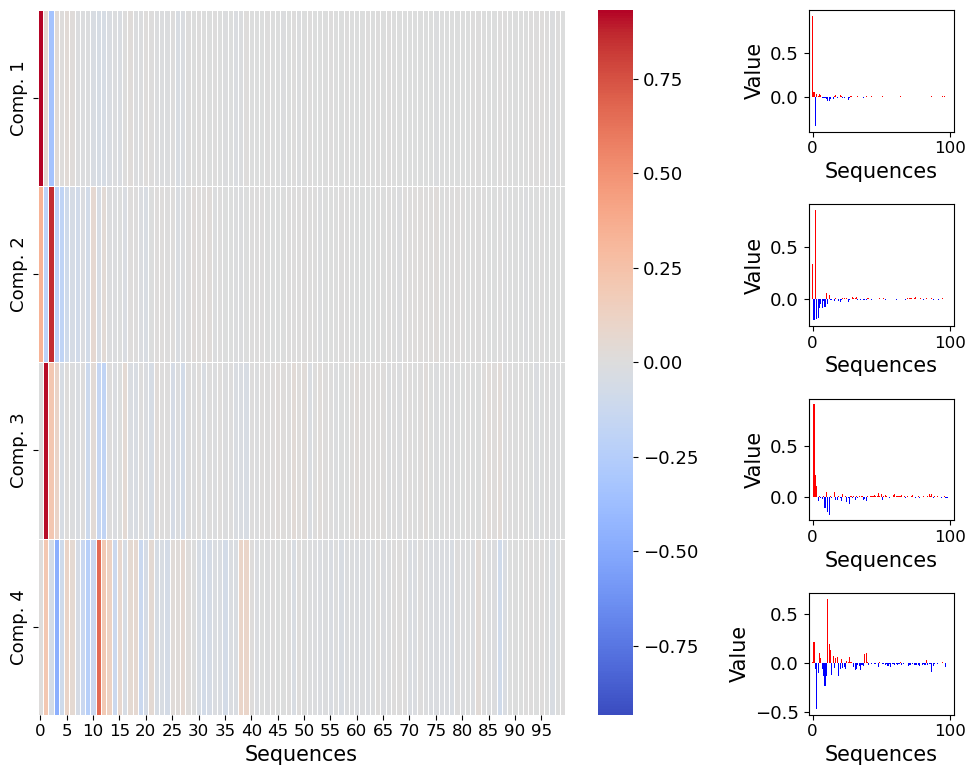

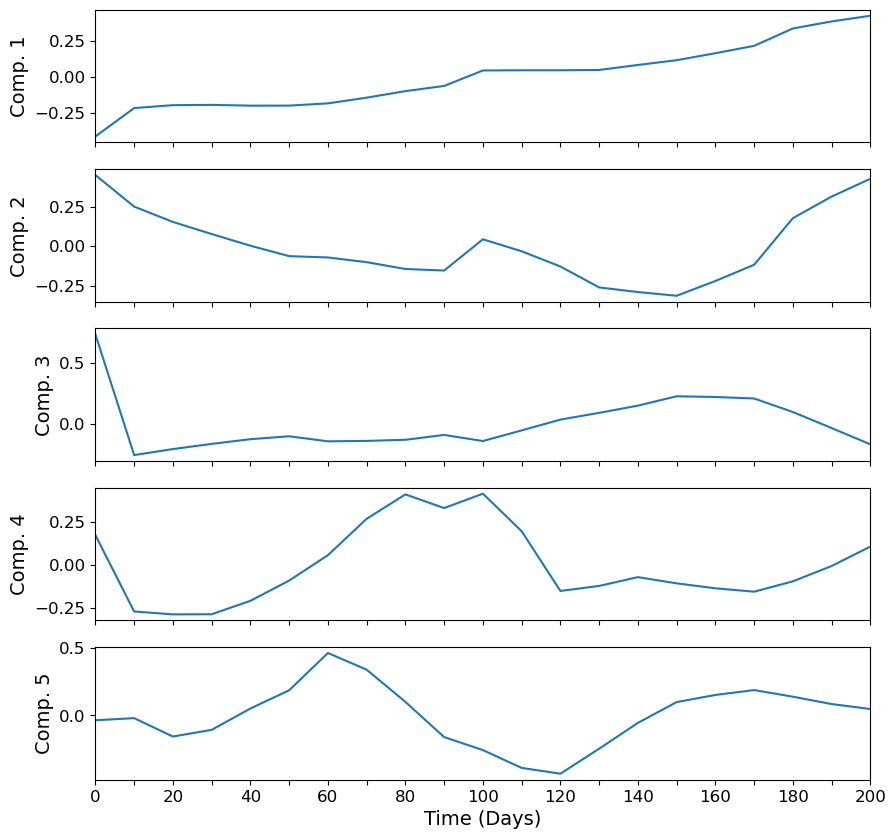

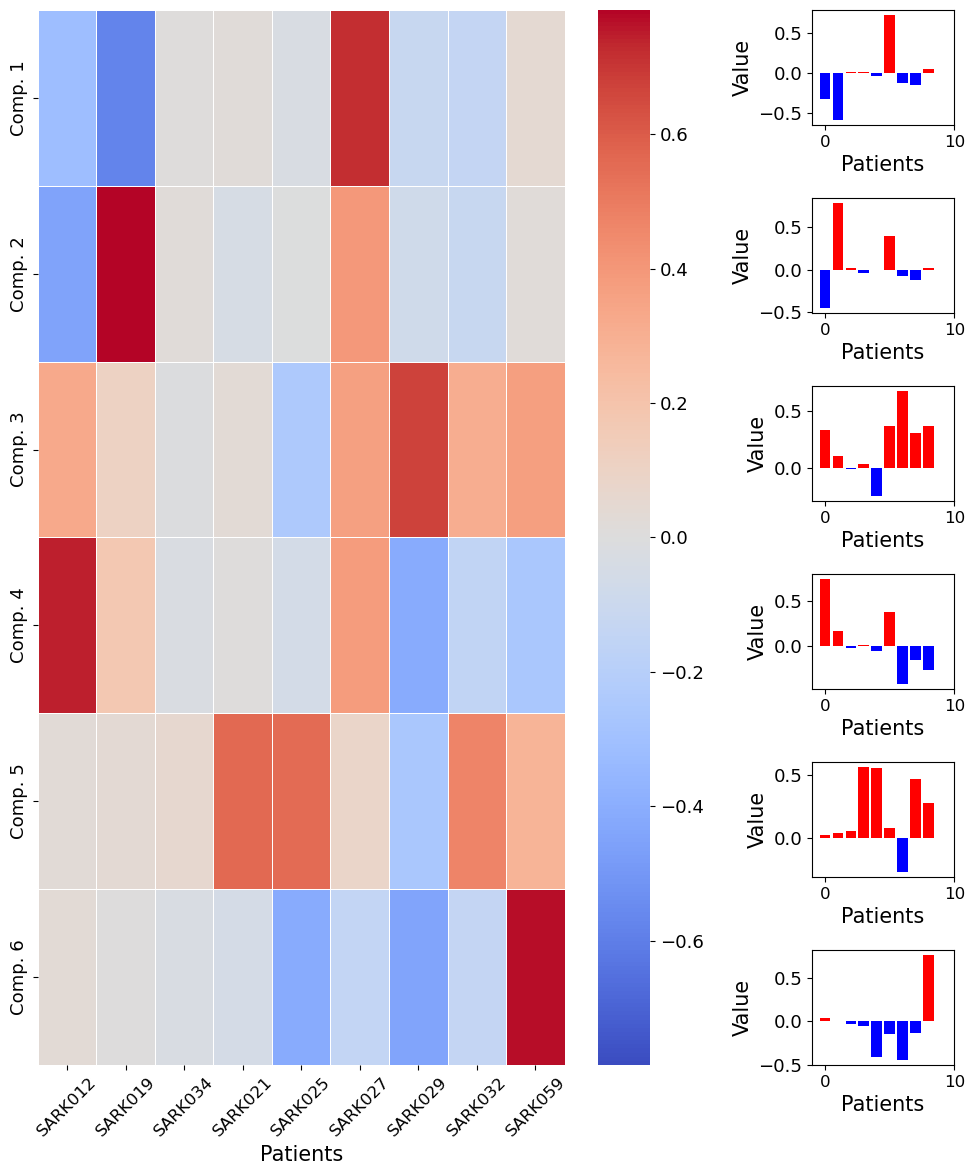

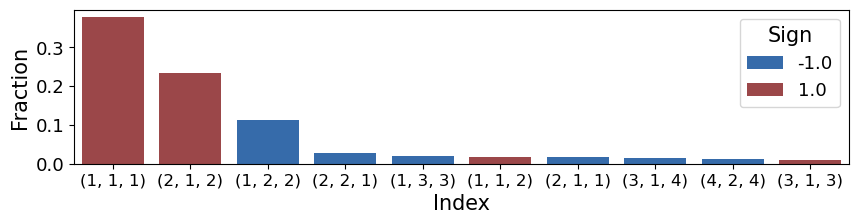


 Plotting cent_tensor_200 with ranks (3, 3, 3)


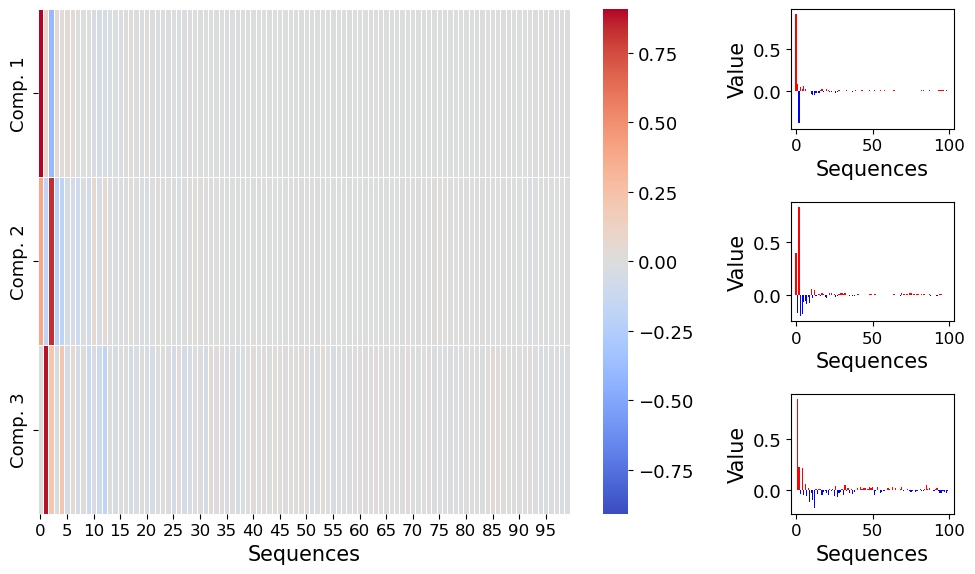

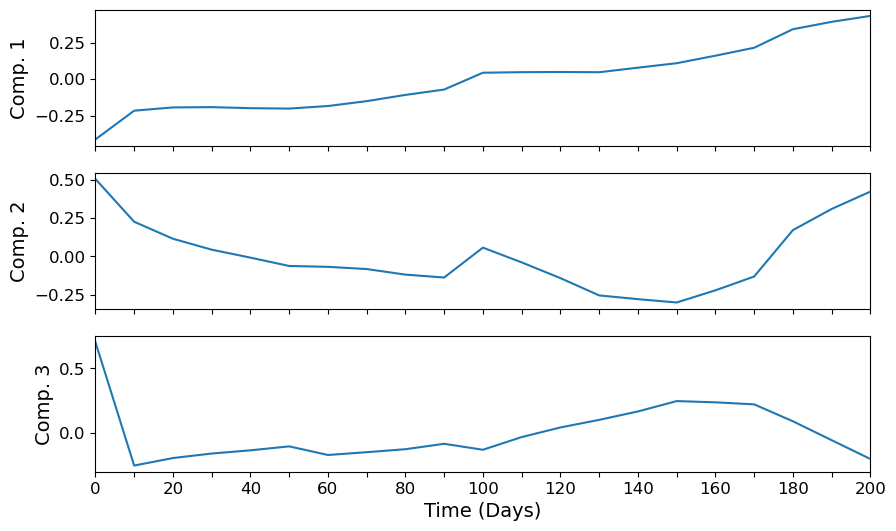

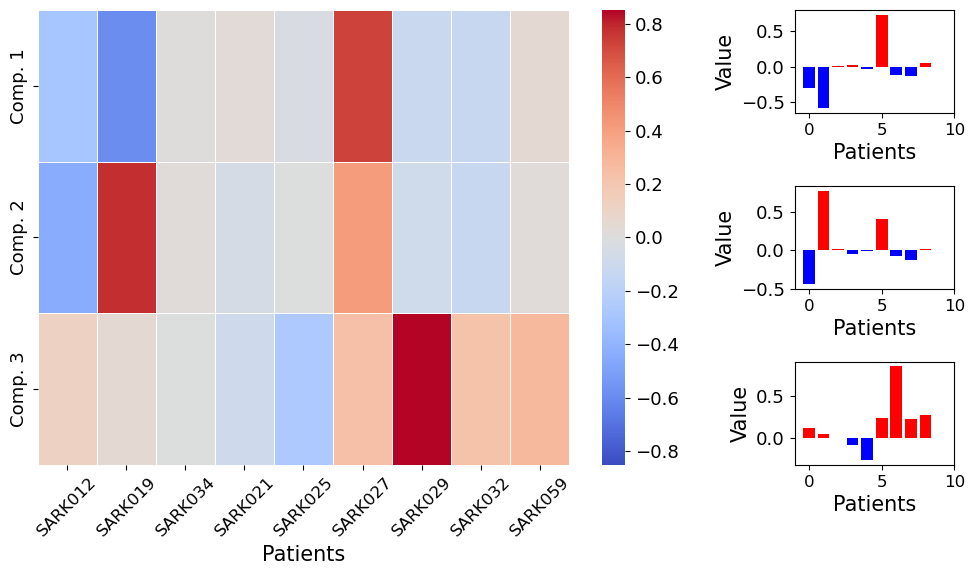

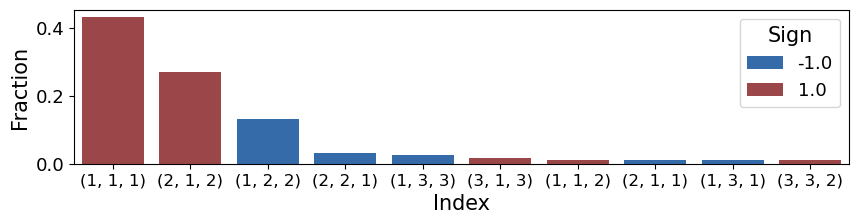


 Plotting cent_tensor_200 with ranks (12, 5, 3)


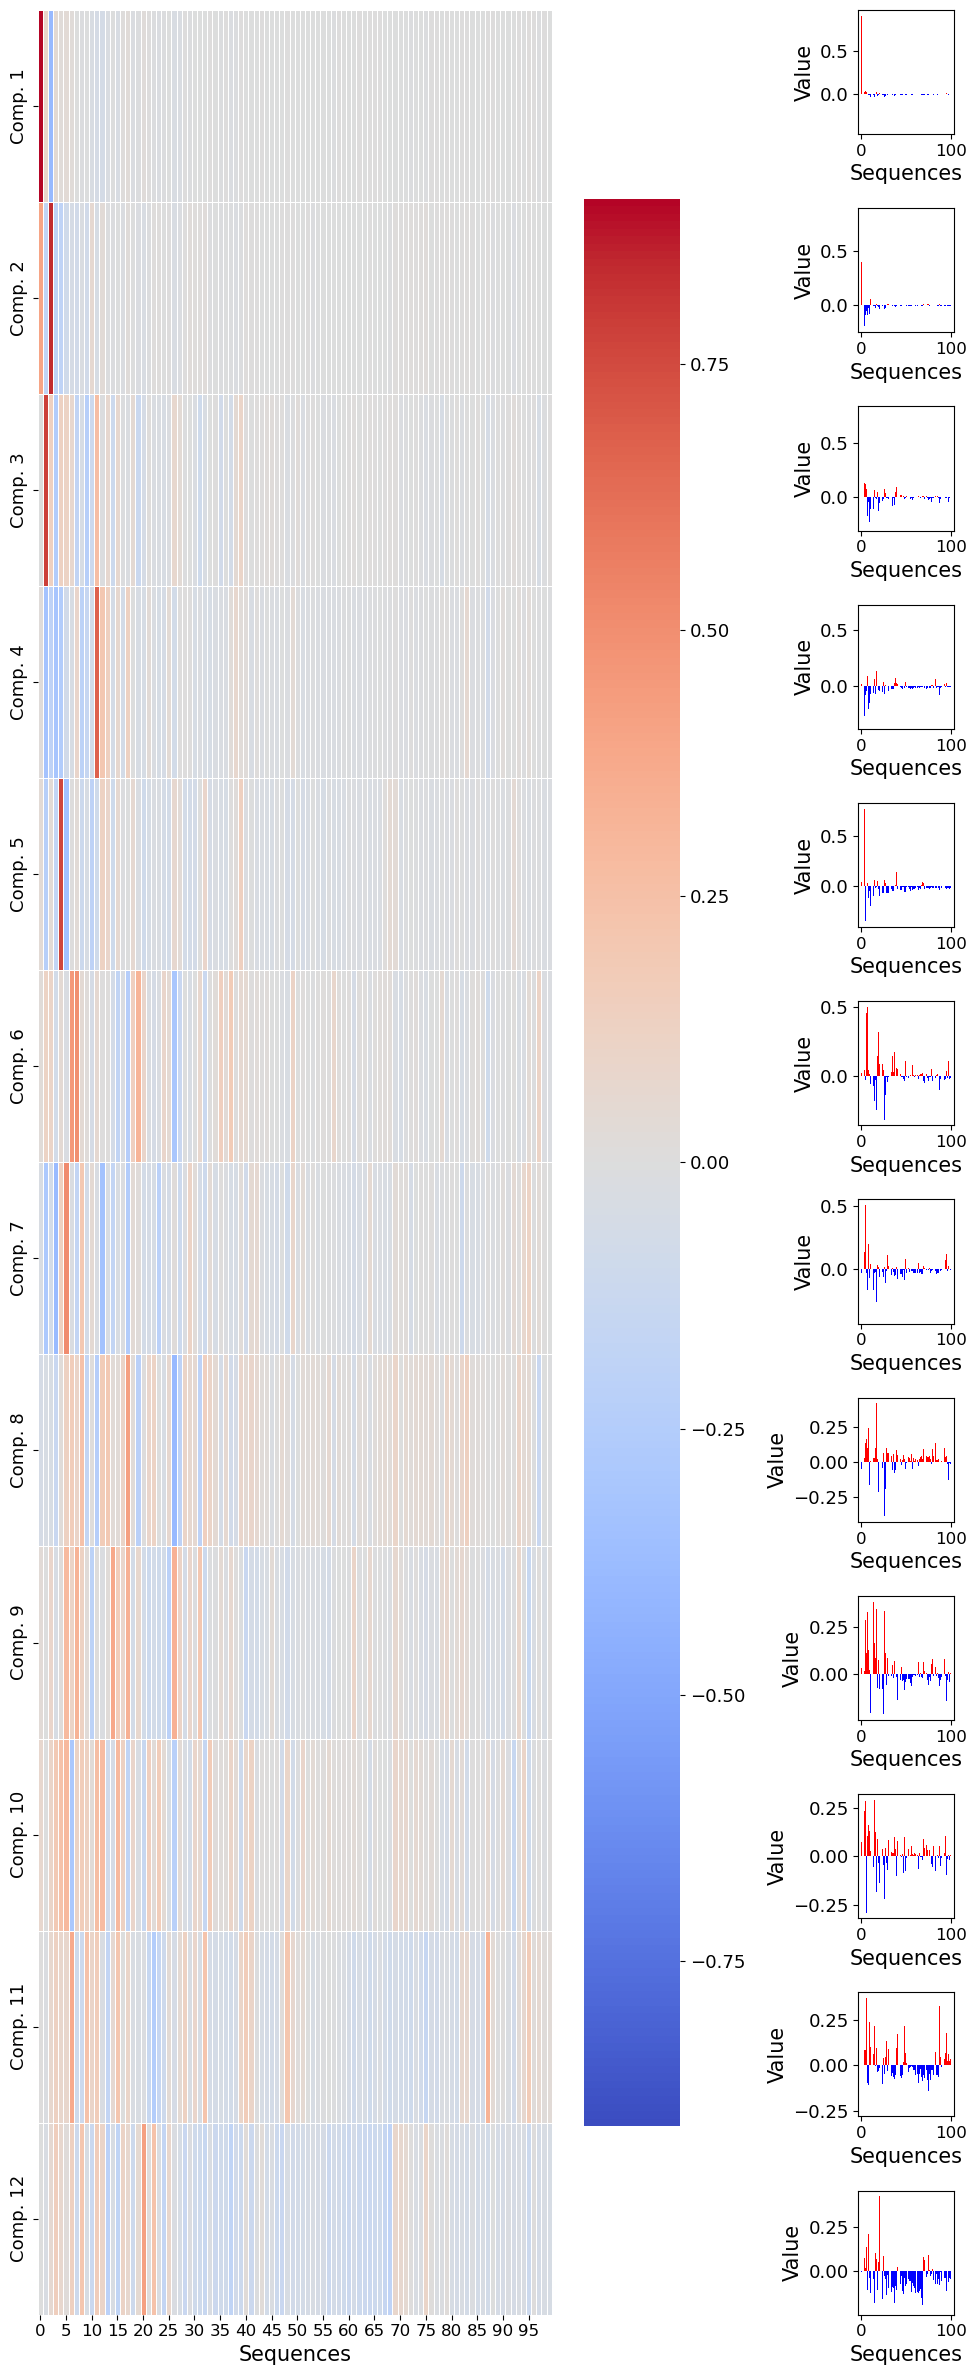

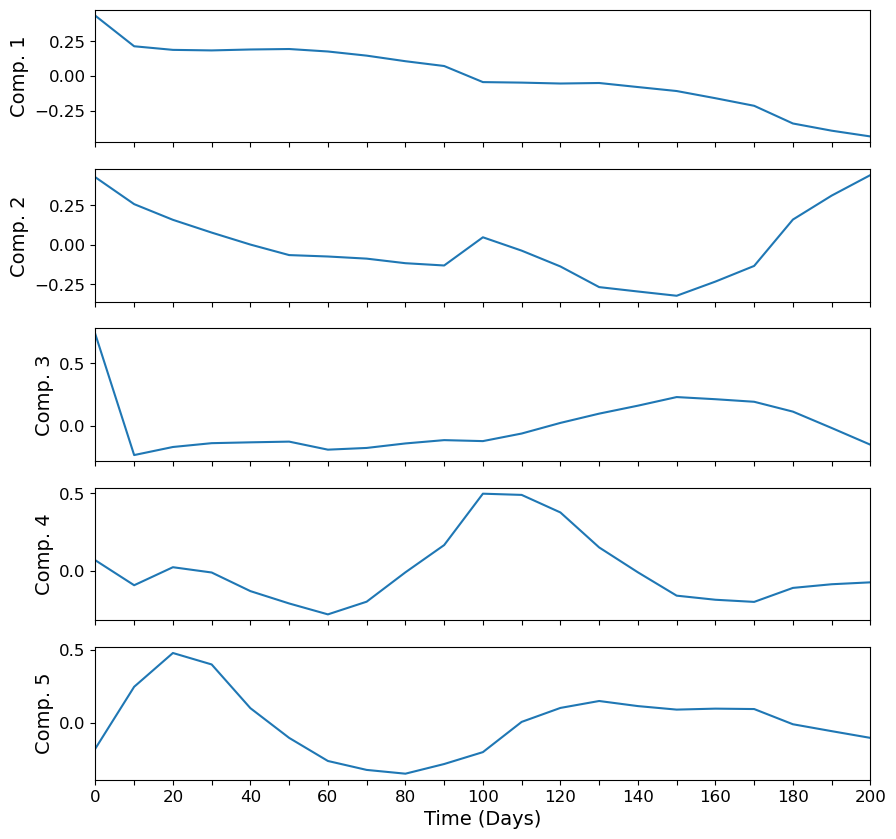

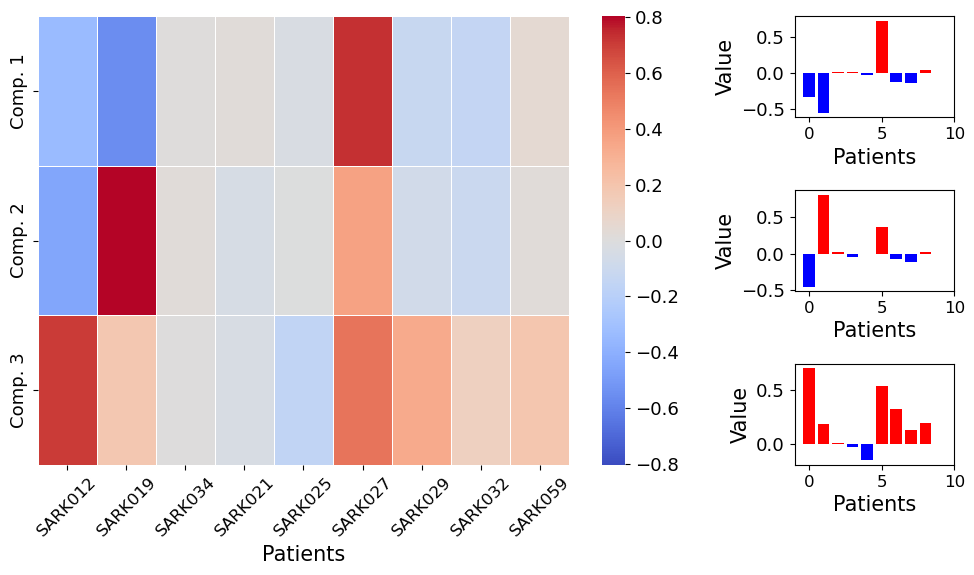

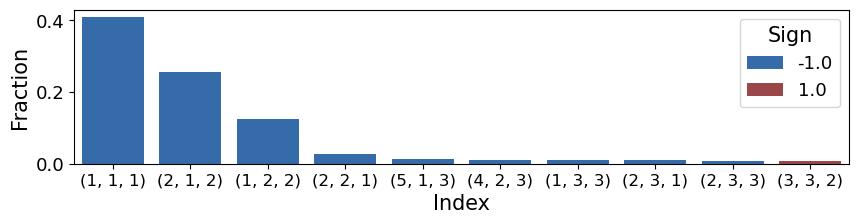


 Plotting cent_tensor_200 with ranks (5, 4, 4)


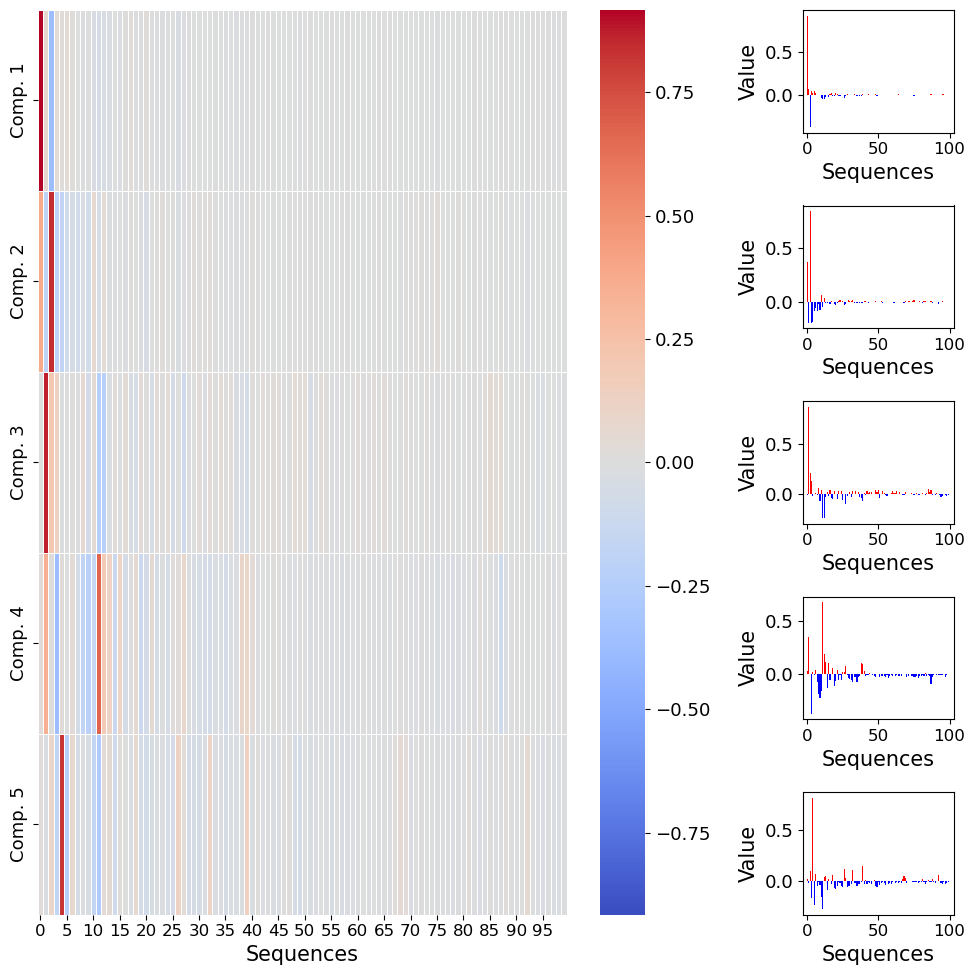

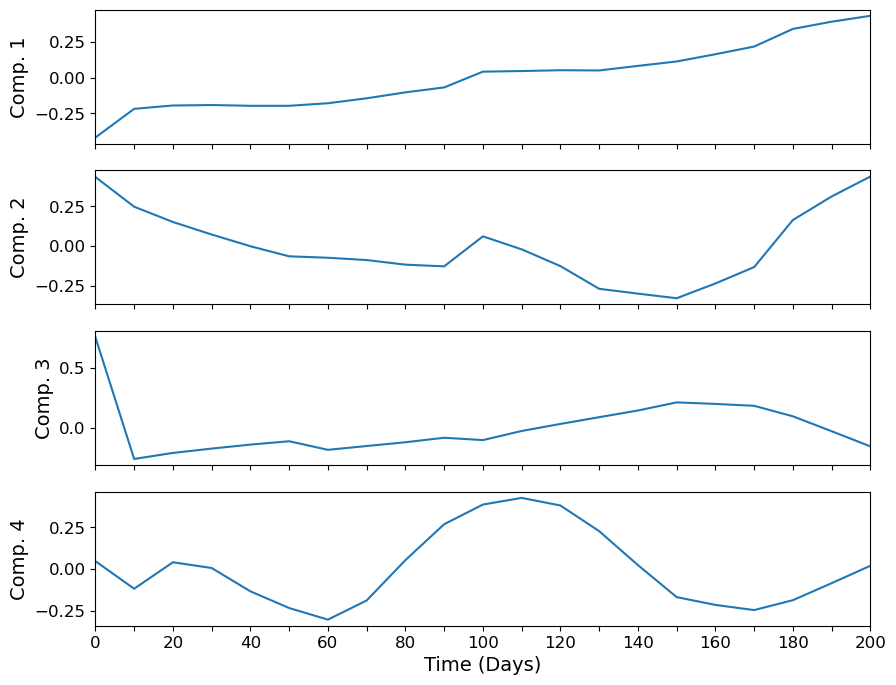

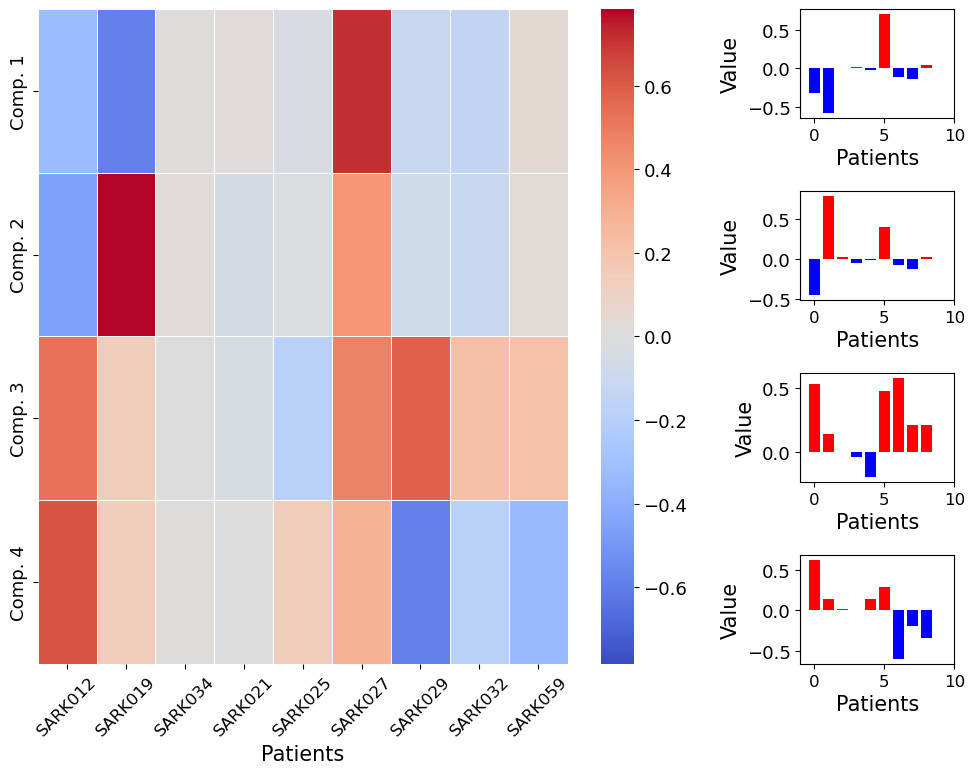

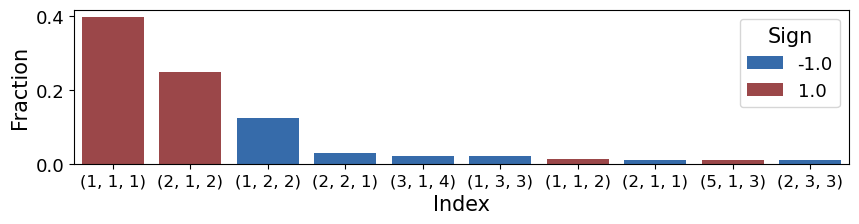

In [40]:
pat_list = ['SARK012', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
            'SARK027', 'SARK029', 'SARK032', 'SARK059']
tensor_name = "tensor_200"
type_name = "cent" 
plot_all_rank_decompositions(tensor_name, type_name, tucker_results, pat_list)

## tensor_300


 Checking decompositions for: cent_tensor_300
   Found rank (2, 3, 3)
   Found rank (4, 6, 5)
   Found rank (4, 4, 3)
   Found rank (15, 7, 3)
   Found rank (8, 6, 4)

 Plotting cent_tensor_300 with ranks (2, 3, 3)


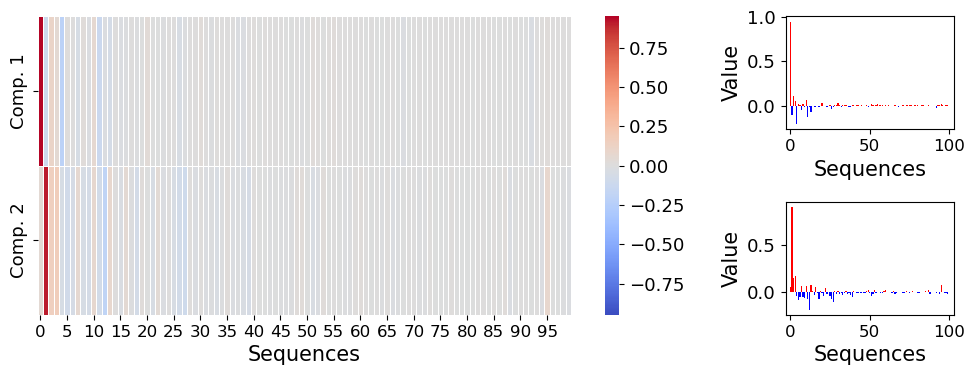

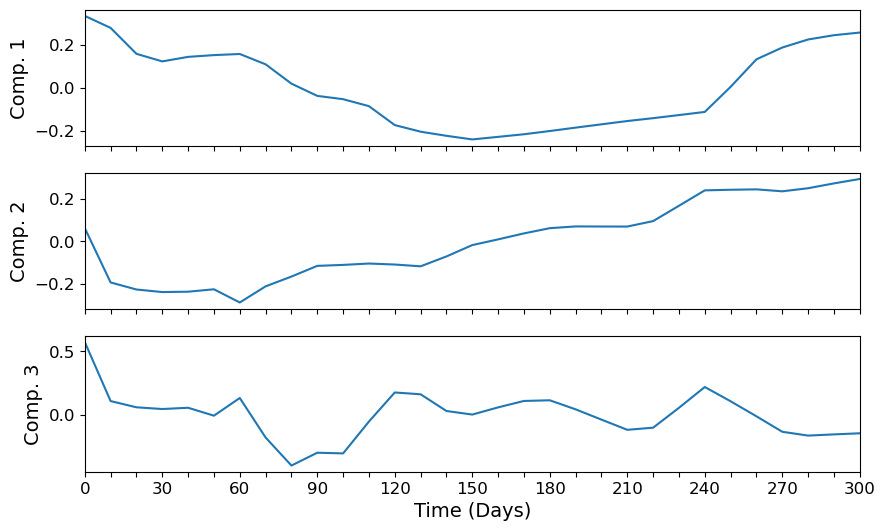

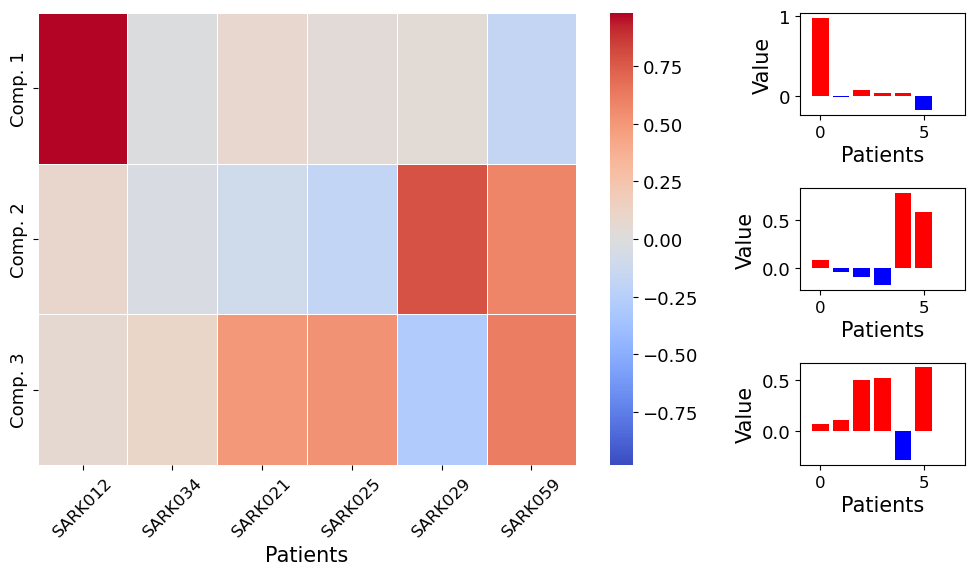

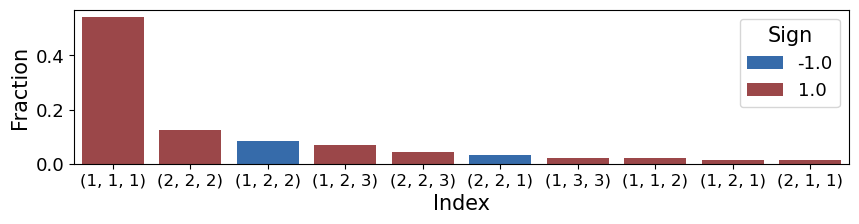


 Plotting cent_tensor_300 with ranks (4, 6, 5)


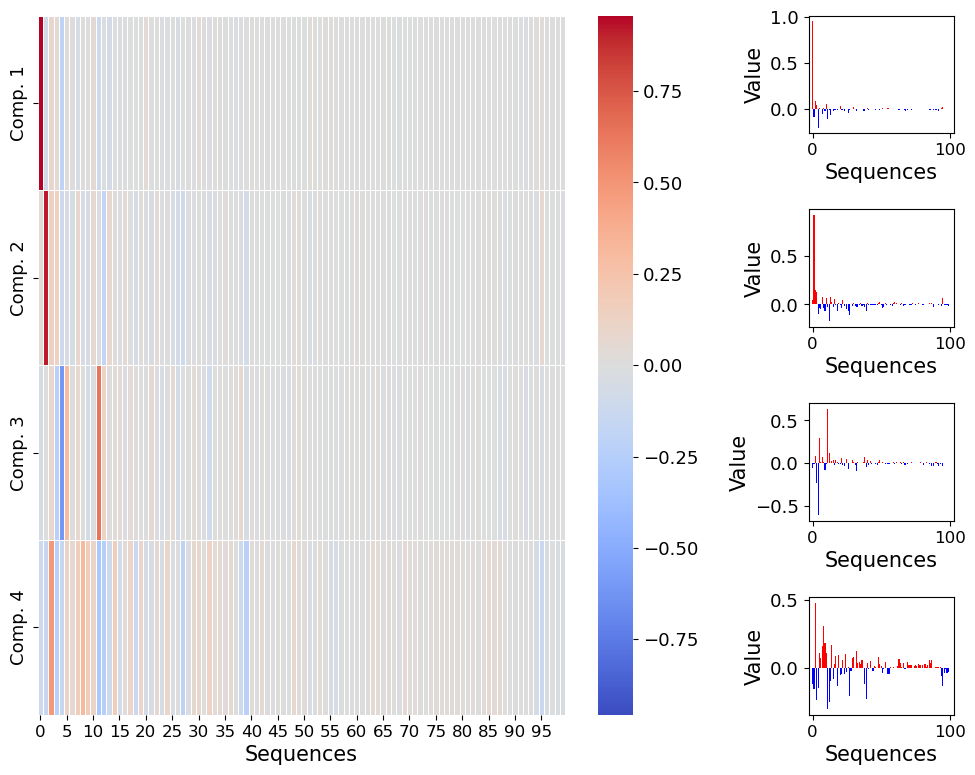

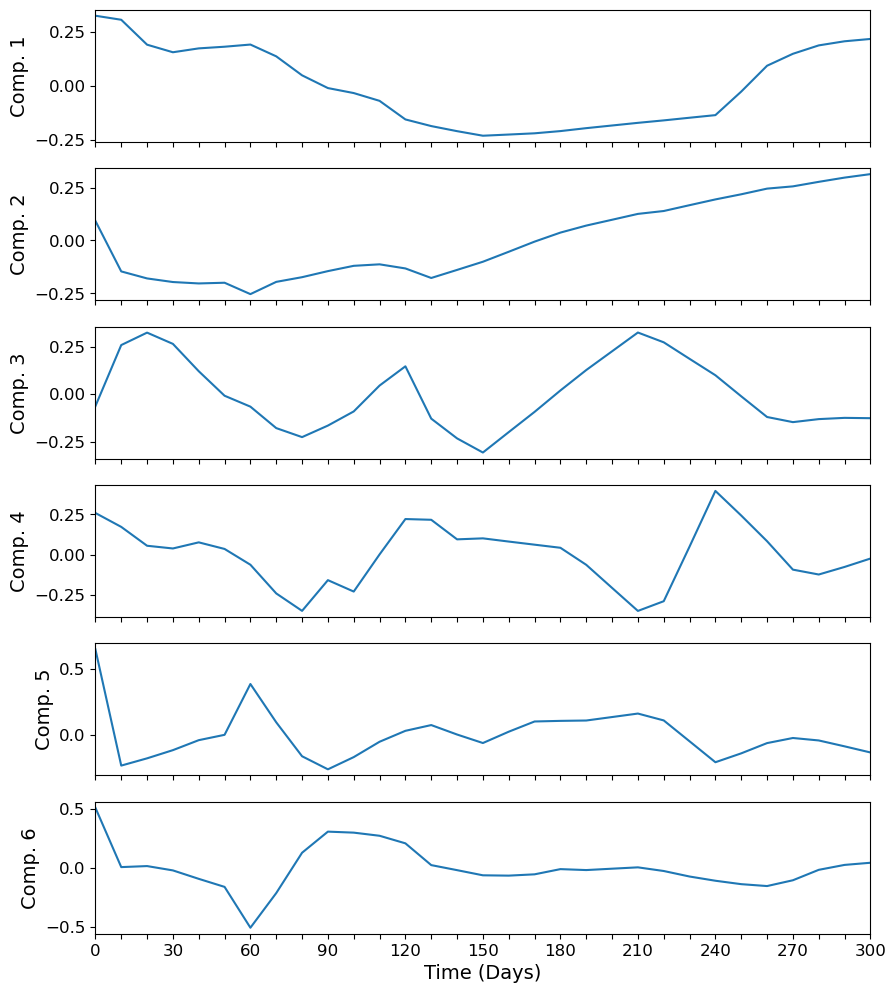

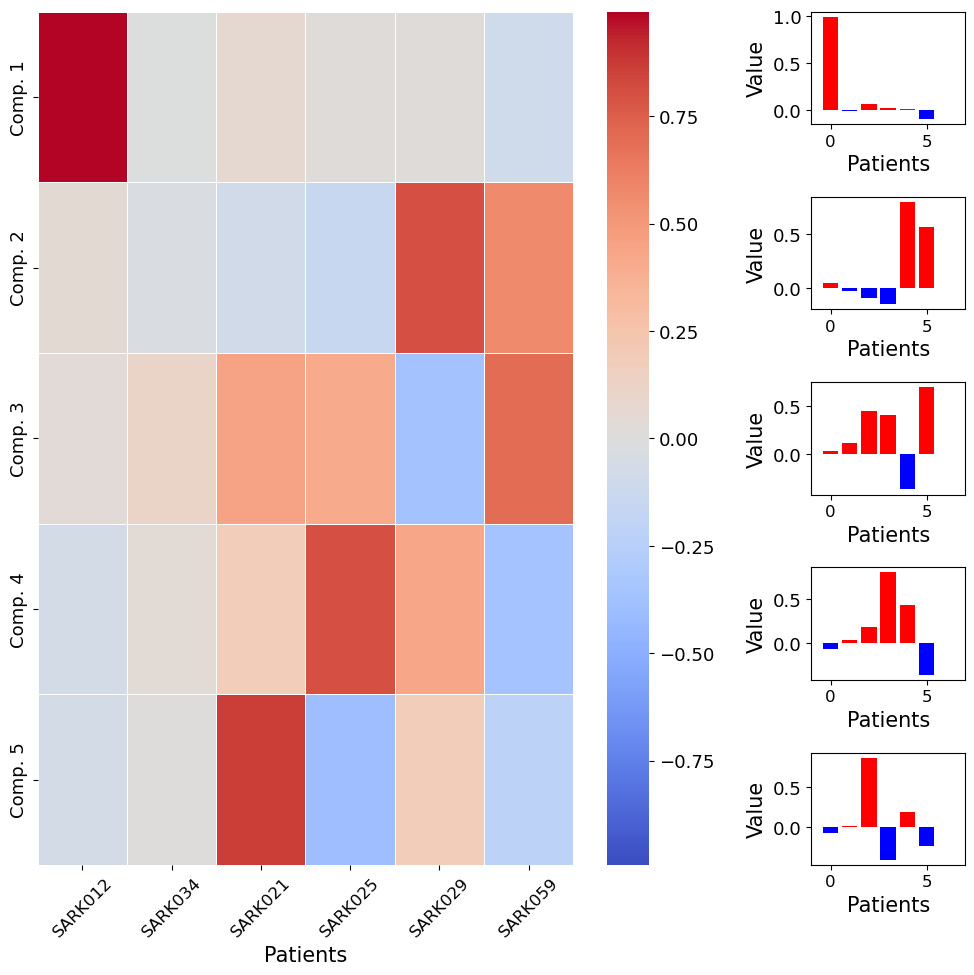

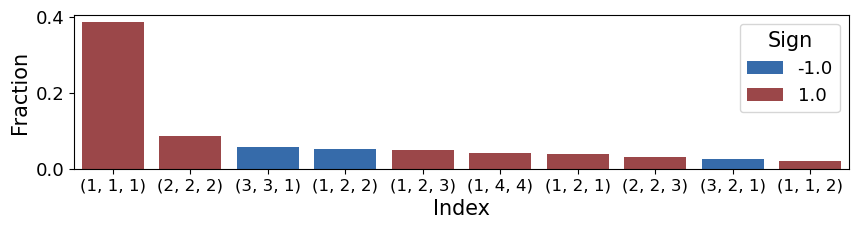


 Plotting cent_tensor_300 with ranks (4, 4, 3)


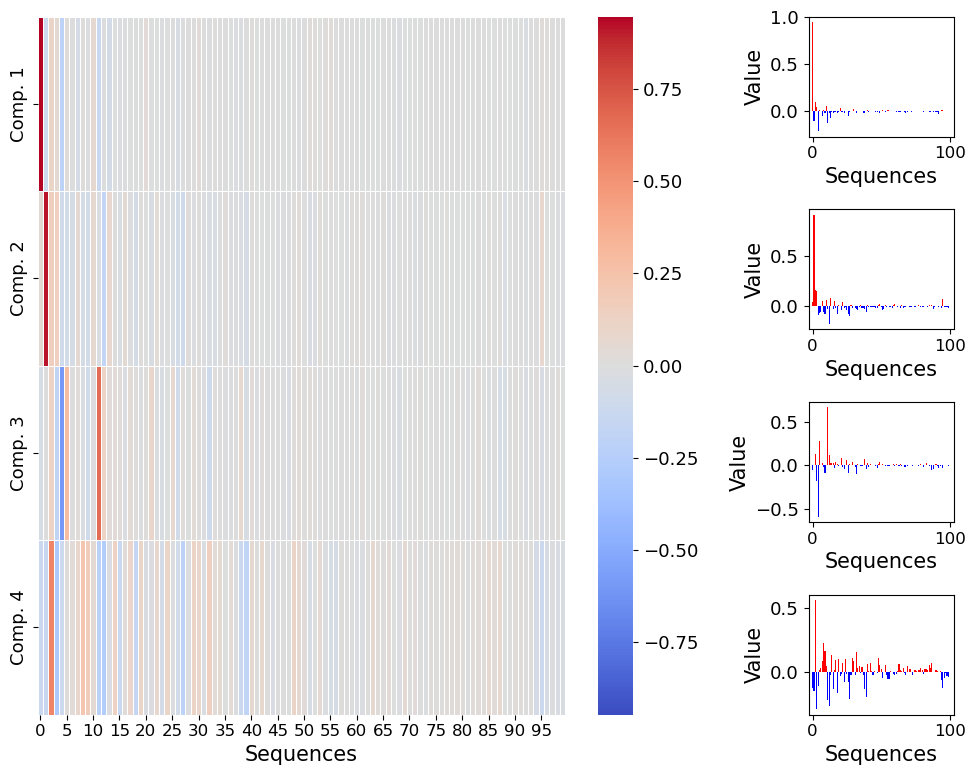

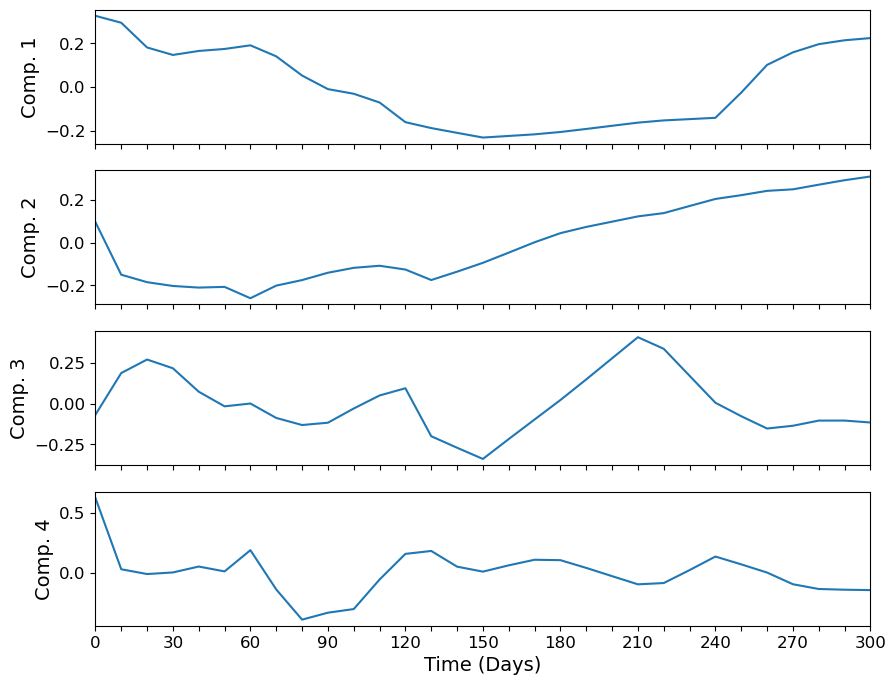

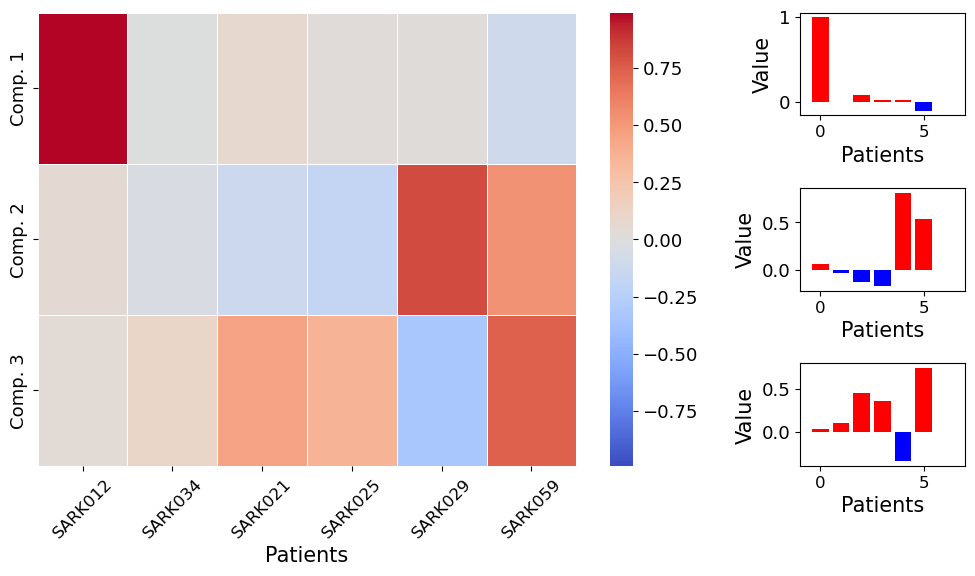

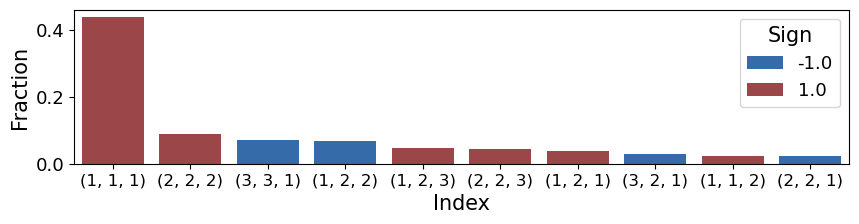


 Plotting cent_tensor_300 with ranks (15, 7, 3)


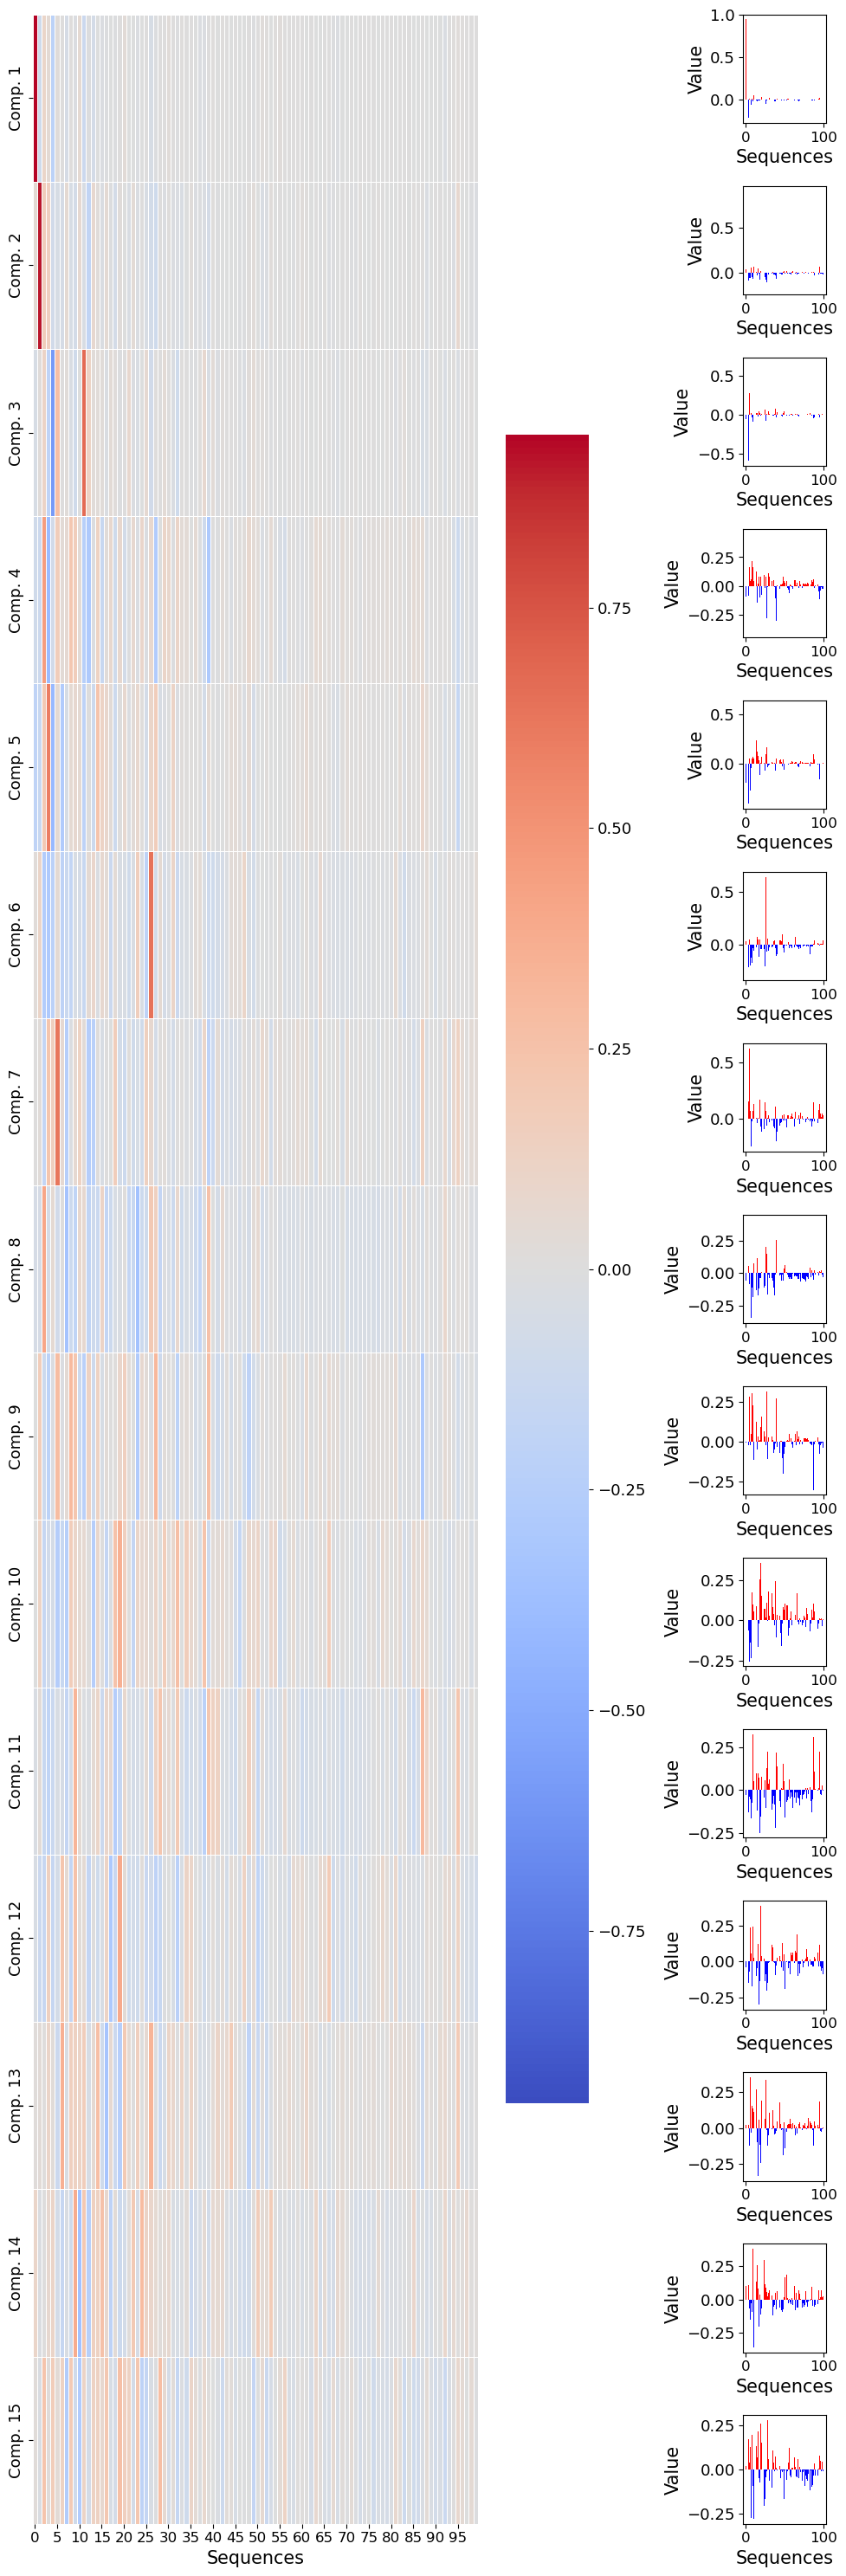

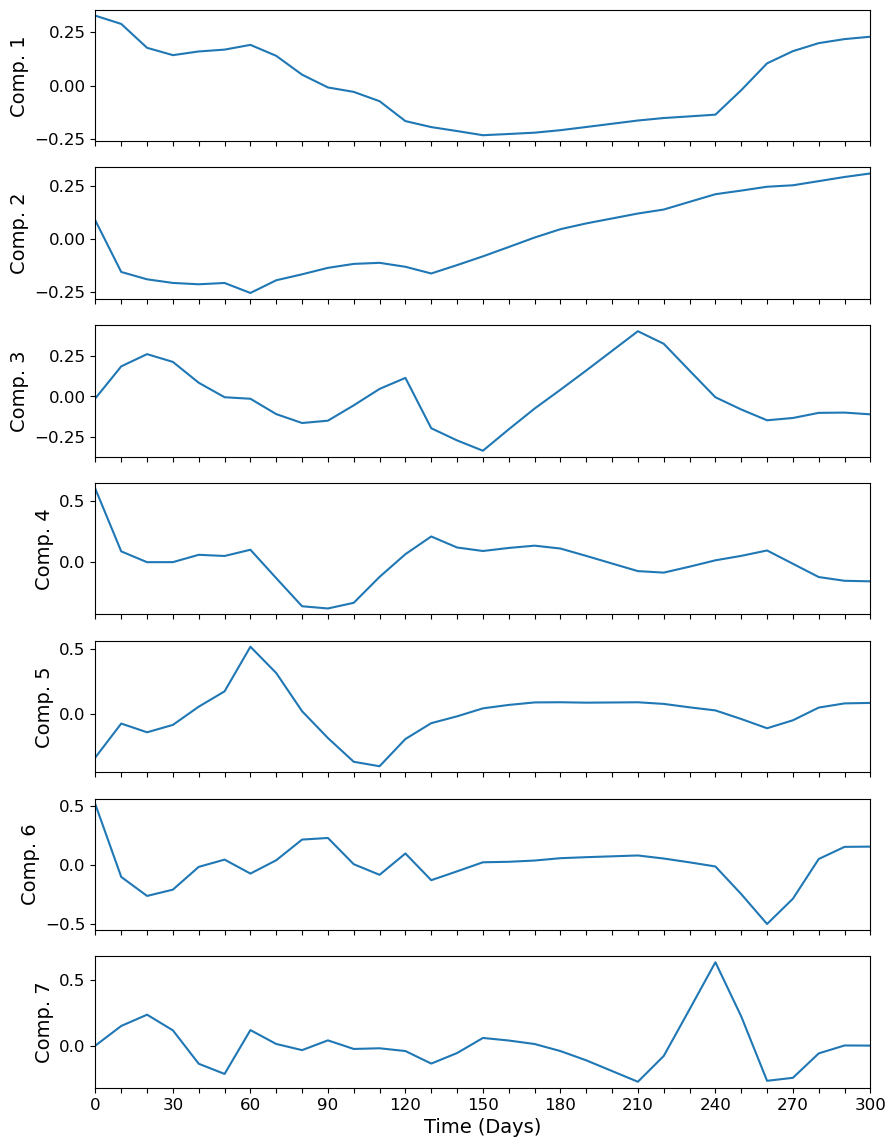

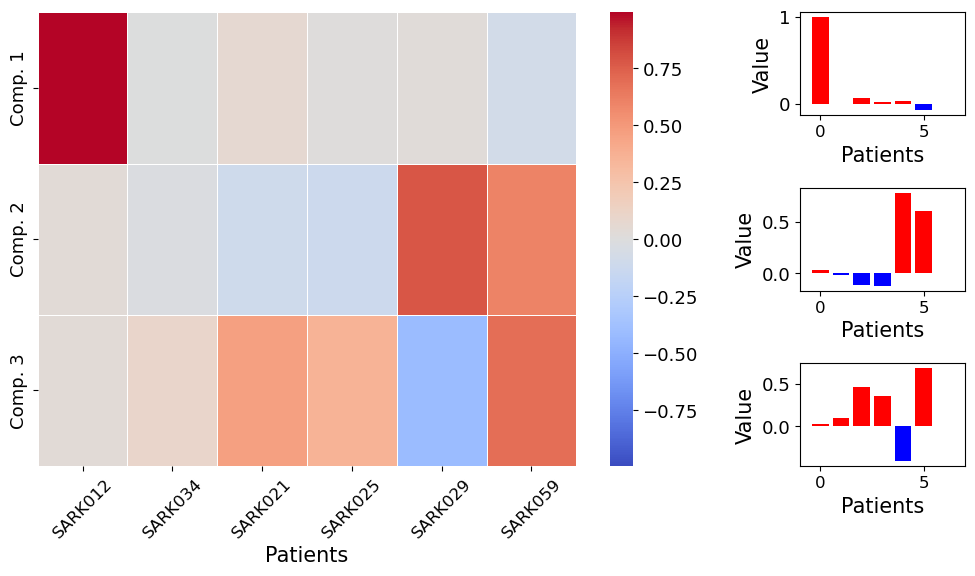

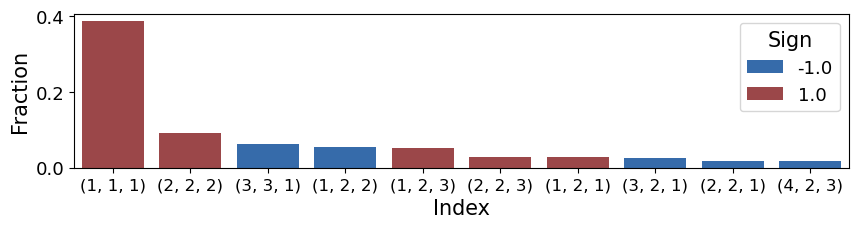


 Plotting cent_tensor_300 with ranks (8, 6, 4)


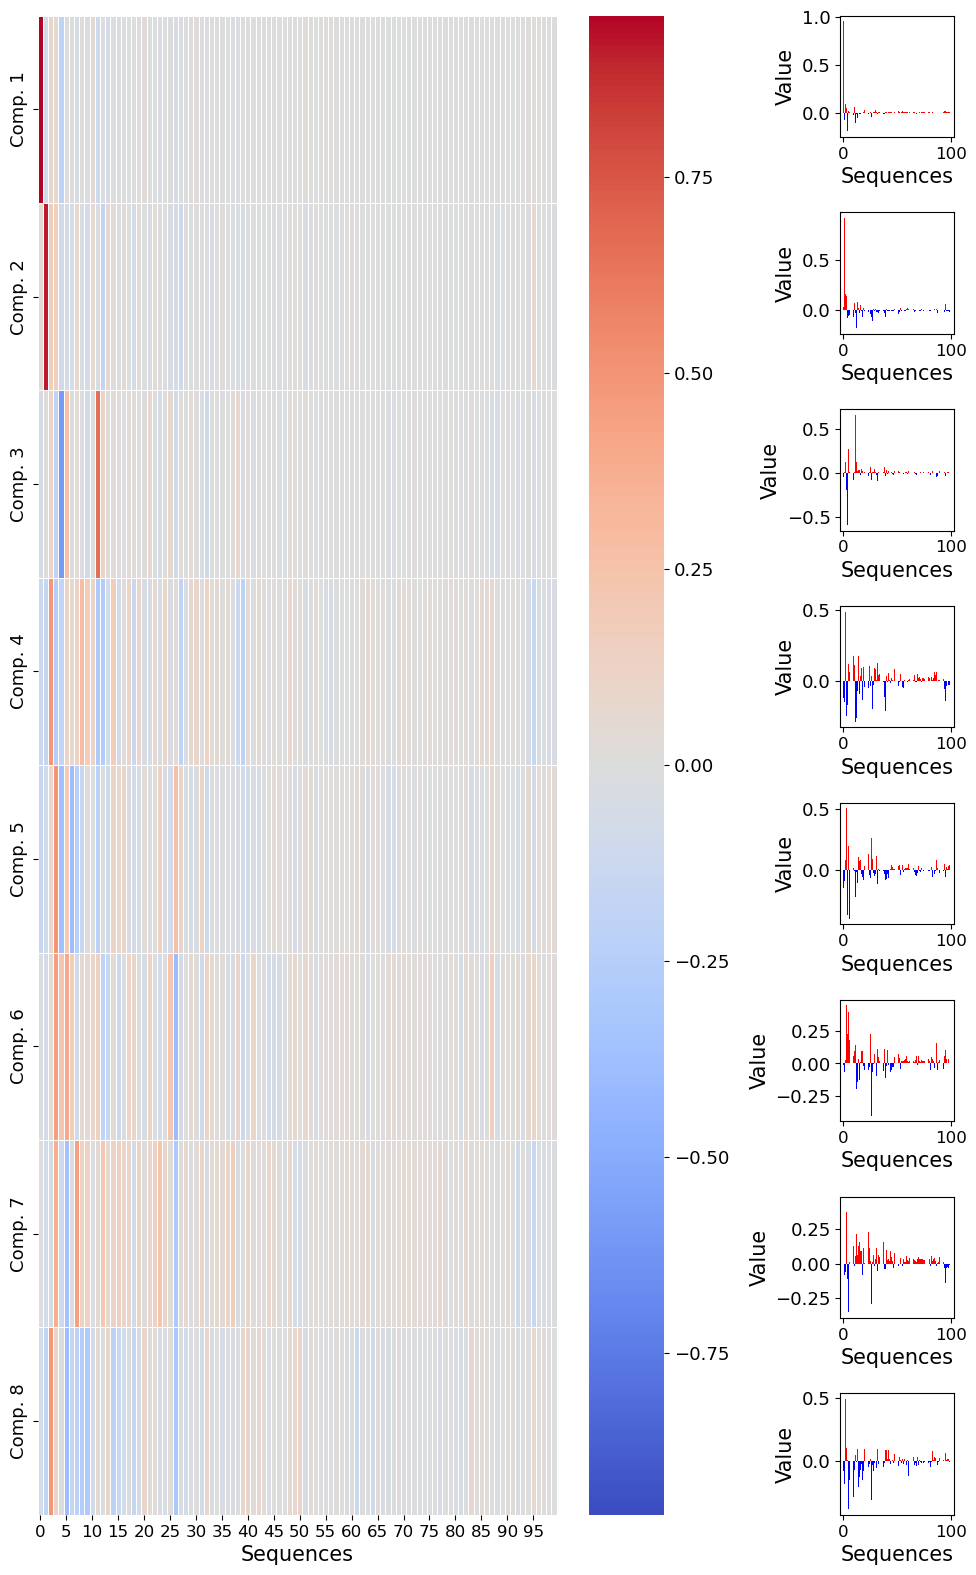

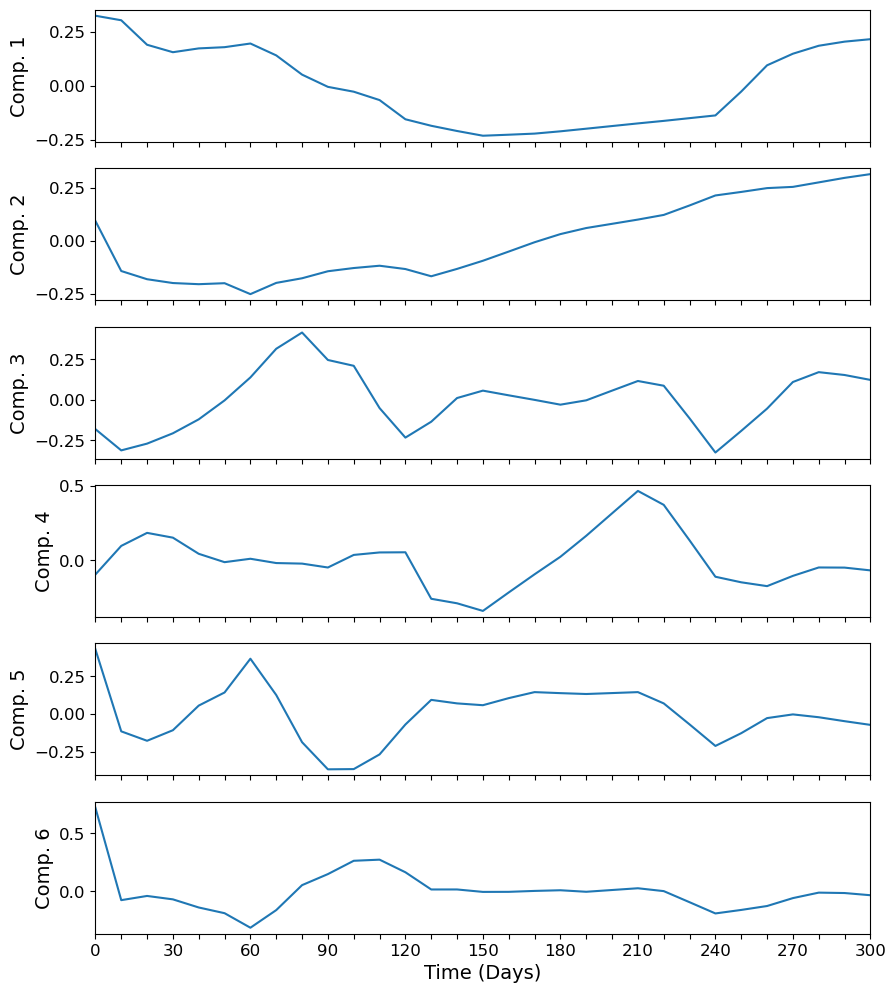

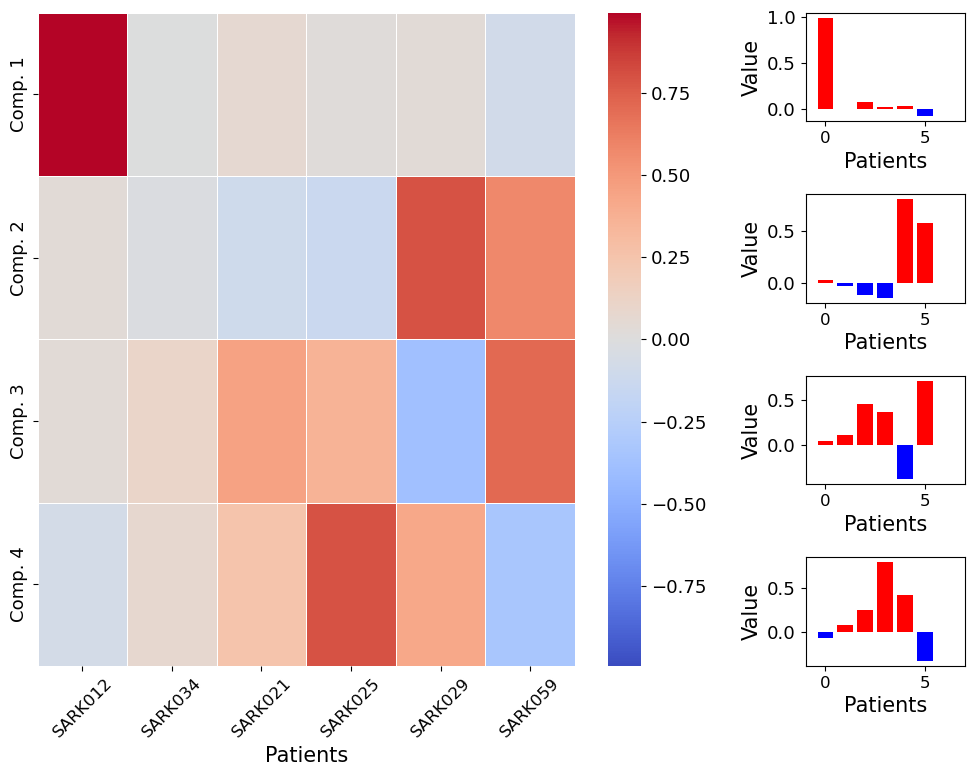

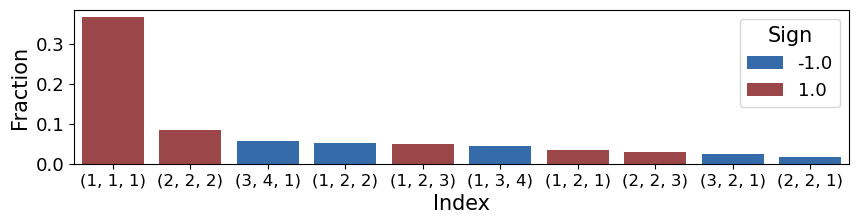

In [41]:
pat_list = ['SARK012', 'SARK034', 'SARK021', 'SARK025', 
            'SARK029', 'SARK059']
tensor_name = "tensor_300"
type_name = "cent" 
plot_all_rank_decompositions(tensor_name, type_name, tucker_results, pat_list)